In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2603.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2603.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,32.259,32.685,31.939,32.152,16.318,16352913.000,2603.TW,28.745,32.685,...,62.667,71.029,56.480,0.487,0.309,31.776,29.970,28.164,1,0
1,2000-02-01,32.472,32.472,31.513,31.726,16.102,10636015.000,2603.TW,28.745,32.685,...,62.667,72.578,61.846,0.561,0.360,31.987,30.119,28.250,0,1
2,2000-02-02,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,28.958,32.685,...,57.576,73.147,65.613,0.613,0.410,32.107,30.284,28.460,0,1
3,2000-02-03,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.384,32.685,...,63.333,72.421,67.882,0.646,0.458,32.263,30.411,28.560,0,1
4,2000-02-04,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.491,32.685,...,65.517,71.614,69.126,0.665,0.499,32.348,30.438,28.528,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2023-02-23,153.500,158.500,153.500,158.000,158.000,34299954.000,2603.TW,142.500,158.500,...,59.459,74.173,55.450,-0.771,-1.805,158.279,150.800,143.321,1,0
5757,2023-02-24,158.500,159.500,155.500,157.000,157.000,32154792.000,2603.TW,145.000,159.500,...,57.333,77.035,62.645,-0.258,-1.495,158.953,151.025,143.097,1,0
5758,2023-03-01,157.500,158.000,154.000,156.000,156.000,21240175.000,2603.TW,145.000,159.500,...,58.108,76.644,67.311,0.068,-1.183,159.512,151.300,143.088,0,1
5759,2023-03-02,158.000,161.000,157.500,160.500,160.500,33776976.000,2603.TW,145.000,161.000,...,67.532,83.388,72.670,0.680,-0.810,160.865,151.725,142.585,1,0


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4993

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5726

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4993,2020-01-02,31.500,32.000,31.500,31.750,25.206,5983333.000,2603.TW,31.000,32.000,...,60.870,47.231,47.813,0.037,-0.025,31.775,31.075,30.375,1,0
4994,2020-01-03,32.000,32.625,31.875,32.500,25.802,13275073.000,2603.TW,31.000,32.625,...,67.857,62.257,52.628,0.133,0.006,32.085,31.156,30.228,1,0
4995,2020-01-06,32.500,33.000,32.250,32.500,25.802,10429668.000,2603.TW,31.000,33.000,...,64.000,66.505,57.253,0.207,0.046,32.314,31.250,30.186,1,0
4996,2020-01-07,32.500,32.625,32.125,32.250,25.603,5552326.000,2603.TW,31.000,33.000,...,66.667,65.170,59.892,0.242,0.086,32.428,31.337,30.247,0,1
4997,2020-01-08,31.875,31.875,31.500,31.500,25.008,5703694.000,2603.TW,31.000,33.000,...,57.143,51.780,57.188,0.208,0.110,32.423,31.381,30.340,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,2022-12-26,168.500,168.500,162.500,162.500,162.500,23661784.000,2603.TW,151.000,172.000,...,62.366,67.278,64.430,3.172,2.330,170.040,159.075,148.110,0,1
5723,2022-12-27,164.000,167.000,162.000,162.500,162.500,19106328.000,2603.TW,152.500,172.000,...,59.302,61.946,63.602,3.004,2.465,170.187,159.150,148.113,0,1
5724,2022-12-28,162.000,164.000,159.000,159.000,159.000,20189077.000,2603.TW,154.000,172.000,...,54.839,50.557,59.253,2.559,2.483,169.844,158.950,148.056,0,1
5725,2022-12-29,159.000,161.000,157.500,160.000,160.000,17346004.000,2603.TW,157.500,172.000,...,55.319,39.452,52.653,2.261,2.439,169.667,158.850,148.033,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['DIF', 'MACD']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [20]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
----------------------------------
| explained_variance | -8.11e-06 |
| fps                | 10        |
| nupdates           | 1         |
| policy_entropy     | 0.693     |
| total_timesteps    | 5         |
| value_loss         | 3.44e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 288      |
| nupdates           | 100      |
| policy_entropy     | 0.576    |
| total_timesteps    | 500      |
| value_loss         | 2.09e+08 |
---------------------------------
----------------------------------
| explained_variance | -6.48e-05 |
| fps                | 338       |
| nupdates           | 200       |
| policy_entropy     | 0.603     |
| total_timesteps    | 1000      |
| value_loss         | 1.37e+06  |
----------------------------------
----------------------------------
| explained_variance | -0.000201 |
| fps                | 352       |
| nupdates           | 300  

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 3000     |
| policy_entropy     | 0.00335  |
| total_timesteps    | 15000    |
| value_loss         | 6.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 365      |
| nupdates           | 3100     |
| policy_entropy     | 0.26     |
| total_timesteps    | 15500    |
| value_loss         | 1.1e+05  |
---------------------------------
---------------------------------
| explained_variance | -0.00235 |
| fps                | 366      |
| nupdates           | 3200     |
| policy_entropy     | 0.0311   |
| total_timesteps    | 16000    |
| value_loss         | 2.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 3300     |
| policy_entropy     | 0.00472  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 347      |
| nupdates           | 6100     |
| policy_entropy     | 0.00209  |
| total_timesteps    | 30500    |
| value_loss         | 2.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 346      |
| nupdates           | 6200     |
| policy_entropy     | 0.000213 |
| total_timesteps    | 31000    |
| value_loss         | 5.68e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 346       |
| nupdates           | 6300      |
| policy_entropy     | 0.0013    |
| total_timesteps    | 31500     |
| value_loss         | 1.29e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 6400     |
| policy_entropy     | 0.00125  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 9100      |
| policy_entropy     | 0.000121  |
| total_timesteps    | 45500     |
| value_loss         | 1.2e+06   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 9200      |
| policy_entropy     | 0.00011   |
| total_timesteps    | 46000     |
| value_loss         | 3.78e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 9300      |
| policy_entropy     | 0.000121  |
| total_timesteps    | 46500     |
| value_loss         | 1.77e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.0155   |
| fps                | 350      |
| nupdates           | 9400     |
| policy_entropy     | 0

---------------------------------
| explained_variance | 0        |
| fps                | 355      |
| nupdates           | 12100    |
| policy_entropy     | 0.000134 |
| total_timesteps    | 60500    |
| value_loss         | 1.01e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 356       |
| nupdates           | 12200     |
| policy_entropy     | 0.285     |
| total_timesteps    | 61000     |
| value_loss         | 6.49e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 12300    |
| policy_entropy     | 0.000111 |
| total_timesteps    | 61500    |
| value_loss         | 3.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 12400    |
| policy_entropy     | 0.000273 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 356       |
| nupdates           | 15200     |
| policy_entropy     | 0.000104  |
| total_timesteps    | 76000     |
| value_loss         | 3.15e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 15300    |
| policy_entropy     | 8.68e-05 |
| total_timesteps    | 76500    |
| value_loss         | 6.03e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 356       |
| nupdates           | 15400     |
| policy_entropy     | 7.79e-05  |
| total_timesteps    | 77000     |
| value_loss         | 1.1e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 15500    |
| policy_entropy     | 6.59e-05 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 360      |
| nupdates           | 18200    |
| policy_entropy     | 0.15     |
| total_timesteps    | 91000    |
| value_loss         | 1.7e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 360       |
| nupdates           | 18300     |
| policy_entropy     | 2.91e-05  |
| total_timesteps    | 91500     |
| value_loss         | 3.06e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 360      |
| nupdates           | 18400    |
| policy_entropy     | 6.32e-05 |
| total_timesteps    | 92000    |
| value_loss         | 5.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 360      |
| nupdates           | 18500    |
| policy_entropy     | 0.000138 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 21200    |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 106000   |
| value_loss         | 7.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 362      |
| nupdates           | 21300    |
| policy_entropy     | 3.4e-05  |
| total_timesteps    | 106500   |
| value_loss         | 1.09e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 21400     |
| policy_entropy     | 0.0522    |
| total_timesteps    | 107000    |
| value_loss         | 6.35e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 21500    |
| policy_entropy     | 2.13e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 24200     |
| policy_entropy     | 1.99e-05  |
| total_timesteps    | 121000    |
| value_loss         | 5.12e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 363      |
| nupdates           | 24300    |
| policy_entropy     | 5.27e-05 |
| total_timesteps    | 121500   |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 24400    |
| policy_entropy     | 0.000184 |
| total_timesteps    | 122000   |
| value_loss         | 6.53e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 364      |
| nupdates           | 24500    |
| policy_entropy     | 4.69e-05 |
| tota

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 365      |
| nupdates           | 27200    |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 136000   |
| value_loss         | 3.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000112 |
| fps                | 365      |
| nupdates           | 27300    |
| policy_entropy     | 3.77e-05 |
| total_timesteps    | 136500   |
| value_loss         | 4.49e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 27400     |
| policy_entropy     | 1.71e-05  |
| total_timesteps    | 137000    |
| value_loss         | 7.43e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 365      |
| nupdates           | 27500    |
| policy_entropy     | 1.74e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 30200    |
| policy_entropy     | 2.91e-05 |
| total_timesteps    | 151000   |
| value_loss         | 1.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 30300    |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 151500   |
| value_loss         | 6.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 366      |
| nupdates           | 30400    |
| policy_entropy     | 1.78e-05 |
| total_timesteps    | 152000   |
| value_loss         | 2.94e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0604   |
| fps                | 366      |
| nupdates           | 30500    |
| policy_entropy     | 1.49e-05 |
| total_timest

---------------------------------
| explained_variance | 0.000261 |
| fps                | 367      |
| nupdates           | 33200    |
| policy_entropy     | 3.73e-05 |
| total_timesteps    | 166000   |
| value_loss         | 1.27e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 33300     |
| policy_entropy     | 0.0043    |
| total_timesteps    | 166500    |
| value_loss         | 1.33e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 33400    |
| policy_entropy     | 2.13e-05 |
| total_timesteps    | 167000   |
| value_loss         | 5.85e+07 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 367       |
| nupdates           | 33500     |
| policy_entropy     | 0.00032   |
|

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 367      |
| nupdates           | 36200    |
| policy_entropy     | 0.00026  |
| total_timesteps    | 181000   |
| value_loss         | 1.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 367      |
| nupdates           | 36300    |
| policy_entropy     | 8.24e-05 |
| total_timesteps    | 181500   |
| value_loss         | 2.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 367      |
| nupdates           | 36400    |
| policy_entropy     | 4.28e-05 |
| total_timesteps    | 182000   |
| value_loss         | 8.91e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 36500     |
| policy_entropy     | 3.41e-05  |
| total_t

----------------------------------
| explained_variance | -0.000258 |
| fps                | 367       |
| nupdates           | 39200     |
| policy_entropy     | 0.000138  |
| total_timesteps    | 196000    |
| value_loss         | 2.53e+05  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 367       |
| nupdates           | 39300     |
| policy_entropy     | 0.104     |
| total_timesteps    | 196500    |
| value_loss         | 7.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 39400    |
| policy_entropy     | 2.97e-05 |
| total_timesteps    | 197000   |
| value_loss         | 8.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 39500    |
| policy_entropy     | 0.000211 

---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 42200    |
| policy_entropy     | 2.63e-05 |
| total_timesteps    | 211000   |
| value_loss         | 1.79e+08 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 367       |
| nupdates           | 42300     |
| policy_entropy     | 0.000113  |
| total_timesteps    | 211500    |
| value_loss         | 2.76e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 367      |
| nupdates           | 42400    |
| policy_entropy     | 0.000462 |
| total_timesteps    | 212000   |
| value_loss         | 8.3e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 42500    |
| policy_entropy     | 2.52e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 368       |
| nupdates           | 45200     |
| policy_entropy     | 7.02e-05  |
| total_timesteps    | 226000    |
| value_loss         | 1.73e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 45300    |
| policy_entropy     | 2.48e-05 |
| total_timesteps    | 226500   |
| value_loss         | 8.19e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 368       |
| nupdates           | 45400     |
| policy_entropy     | 1.95e-05  |
| total_timesteps    | 227000    |
| value_loss         | 3.26e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 45500    |
| policy_entropy     | 2.9e-05  

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 368       |
| nupdates           | 48200     |
| policy_entropy     | 2.28e-05  |
| total_timesteps    | 241000    |
| value_loss         | 4.88e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.89e-05 |
| fps                | 368      |
| nupdates           | 48300    |
| policy_entropy     | 0.00308  |
| total_timesteps    | 241500   |
| value_loss         | 2.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.207    |
| fps                | 368      |
| nupdates           | 48400    |
| policy_entropy     | 3.12e-05 |
| total_timesteps    | 242000   |
| value_loss         | 3.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 48500    |
| policy_entropy     | 2.06e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 51200    |
| policy_entropy     | 0.0228   |
| total_timesteps    | 256000   |
| value_loss         | 2.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.115    |
| fps                | 369      |
| nupdates           | 51300    |
| policy_entropy     | 9.65e-05 |
| total_timesteps    | 256500   |
| value_loss         | 2.26e+08 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 369       |
| nupdates           | 51400     |
| policy_entropy     | 4.64e-05  |
| total_timesteps    | 257000    |
| value_loss         | 1.71e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.0499   |
| fps                | 369      |
| nupdates           | 51500    |
| policy_entropy     | 8.17e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 369       |
| nupdates           | 54200     |
| policy_entropy     | 2.1e-05   |
| total_timesteps    | 271000    |
| value_loss         | 2.34e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 369       |
| nupdates           | 54300     |
| policy_entropy     | 0.0544    |
| total_timesteps    | 271500    |
| value_loss         | 4.22e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 369      |
| nupdates           | 54400    |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 272000   |
| value_loss         | 6.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00547  |
| fps                | 369      |
| nupdates           | 54500    |
| policy_entropy     | 2.11e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 57200    |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 286000   |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 369      |
| nupdates           | 57300    |
| policy_entropy     | 2.13e-05 |
| total_timesteps    | 286500   |
| value_loss         | 4.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.869    |
| fps                | 369      |
| nupdates           | 57400    |
| policy_entropy     | 0.0194   |
| total_timesteps    | 287000   |
| value_loss         | 6.3e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.113    |
| fps                | 369      |
| nupdates           | 57500    |
| policy_entropy     | 1.97e-05 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 369      |
| nupdates           | 60200    |
| policy_entropy     | 8.23e-06 |
| total_timesteps    | 301000   |
| value_loss         | 1.42e+04 |
---------------------------------
---------------------------------
| explained_variance | 6.2e-06  |
| fps                | 369      |
| nupdates           | 60300    |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 301500   |
| value_loss         | 3.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 369      |
| nupdates           | 60400    |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 302000   |
| value_loss         | 7e+08    |
---------------------------------
----------------------------------
| explained_variance | -2.22e-05 |
| fps                | 369       |
| nupdates           | 60500     |
| policy_entropy     | 2.37e-05  |
| total_t

---------------------------------
| explained_variance | 0.0595   |
| fps                | 370      |
| nupdates           | 63200    |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 316000   |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.259    |
| fps                | 370      |
| nupdates           | 63300    |
| policy_entropy     | 0.000184 |
| total_timesteps    | 316500   |
| value_loss         | 5.89e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.32     |
| fps                | 370      |
| nupdates           | 63400    |
| policy_entropy     | 0.00512  |
| total_timesteps    | 317000   |
| value_loss         | 9.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 63500    |
| policy_entropy     | 5.01e-06 |
| total_timest

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 370       |
| nupdates           | 66200     |
| policy_entropy     | 4.02e-06  |
| total_timesteps    | 331000    |
| value_loss         | 2.44e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 66300    |
| policy_entropy     | 1.46e-05 |
| total_timesteps    | 331500   |
| value_loss         | 5.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 66400    |
| policy_entropy     | 9.39e-06 |
| total_timesteps    | 332000   |
| value_loss         | 1.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 66500    |
| policy_entropy     | 4.58e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 370      |
| nupdates           | 69300    |
| policy_entropy     | 9.01e-06 |
| total_timesteps    | 346500   |
| value_loss         | 2.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 69400    |
| policy_entropy     | 1.02e-05 |
| total_timesteps    | 347000   |
| value_loss         | 7.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 370      |
| nupdates           | 69500    |
| policy_entropy     | 3.54e-06 |
| total_timesteps    | 347500   |
| value_loss         | 2.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.025    |
| fps                | 370      |
| nupdates           | 69600    |
| policy_entropy     | 0.327    |
| total_timest

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 370      |
| nupdates           | 72400    |
| policy_entropy     | 7.98e-06 |
| total_timesteps    | 362000   |
| value_loss         | 5.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 370      |
| nupdates           | 72500    |
| policy_entropy     | 2.73e-06 |
| total_timesteps    | 362500   |
| value_loss         | 1.1e+07  |
---------------------------------
---------------------------------
| explained_variance | -0.00703 |
| fps                | 370      |
| nupdates           | 72600    |
| policy_entropy     | 2.74e-06 |
| total_timesteps    | 363000   |
| value_loss         | 1.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 370      |
| nupdates           | 72700    |
| policy_entropy     | 9.58e-06 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 370      |
| nupdates           | 75500    |
| policy_entropy     | 6.33e-06 |
| total_timesteps    | 377500   |
| value_loss         | 6.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00655  |
| fps                | 370      |
| nupdates           | 75600    |
| policy_entropy     | 0.000902 |
| total_timesteps    | 378000   |
| value_loss         | 3.13e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00155 |
| fps                | 370      |
| nupdates           | 75700    |
| policy_entropy     | 2.33e-05 |
| total_timesteps    | 378500   |
| value_loss         | 1.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00343  |
| fps                | 370      |
| nupdates           | 75800    |
| policy_entropy     | 1.64e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 78500    |
| policy_entropy     | 9.84e-06 |
| total_timesteps    | 392500   |
| value_loss         | 5.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 78600    |
| policy_entropy     | 2.36e-06 |
| total_timesteps    | 393000   |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.121    |
| fps                | 370      |
| nupdates           | 78700    |
| policy_entropy     | 4.21e-06 |
| total_timesteps    | 393500   |
| value_loss         | 2.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00174  |
| fps                | 370      |
| nupdates           | 78800    |
| policy_entropy     | 2.43e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0565   |
| fps                | 371      |
| nupdates           | 81500    |
| policy_entropy     | 6.42e-06 |
| total_timesteps    | 407500   |
| value_loss         | 1.95e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 371       |
| nupdates           | 81600     |
| policy_entropy     | 2.45e-06  |
| total_timesteps    | 408000    |
| value_loss         | 1.14e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.136    |
| fps                | 371      |
| nupdates           | 81700    |
| policy_entropy     | 2.52e-06 |
| total_timesteps    | 408500   |
| value_loss         | 8.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 371      |
| nupdates           | 81800    |
| policy_entropy     | 4.74e-06 |
| tota

---------------------------------
| explained_variance | -0.398   |
| fps                | 371      |
| nupdates           | 84600    |
| policy_entropy     | 3.29e-06 |
| total_timesteps    | 423000   |
| value_loss         | 7.5e+05  |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 371       |
| nupdates           | 84700     |
| policy_entropy     | 0.0386    |
| total_timesteps    | 423500    |
| value_loss         | 3.37e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 371      |
| nupdates           | 84800    |
| policy_entropy     | 3.9e-06  |
| total_timesteps    | 424000   |
| value_loss         | 5.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 84900    |
| policy_entropy     | 2.18e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 87700    |
| policy_entropy     | 2.14e-06 |
| total_timesteps    | 438500   |
| value_loss         | 2.6e+07  |
---------------------------------
---------------------------------
| explained_variance | -0.166   |
| fps                | 371      |
| nupdates           | 87800    |
| policy_entropy     | 2.78e-06 |
| total_timesteps    | 439000   |
| value_loss         | 1.11e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 371       |
| nupdates           | 87900     |
| policy_entropy     | 0.00266   |
| total_timesteps    | 439500    |
| value_loss         | 2.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 371      |
| nupdates           | 88000    |
| policy_entropy     | 4.01e-06 |
| tota

---------------------------------
| explained_variance | 0.166    |
| fps                | 370      |
| nupdates           | 90700    |
| policy_entropy     | 2.47e-06 |
| total_timesteps    | 453500   |
| value_loss         | 5.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.426    |
| fps                | 370      |
| nupdates           | 90800    |
| policy_entropy     | 6.46e-06 |
| total_timesteps    | 454000   |
| value_loss         | 6.73e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.57e-05 |
| fps                | 370       |
| nupdates           | 90900     |
| policy_entropy     | 3.83e-06  |
| total_timesteps    | 454500    |
| value_loss         | 2.28e+06  |
----------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 370       |
| nupdates           | 91000     |
| policy_entropy     | 0.0592    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 93700    |
| policy_entropy     | 2.04e-06 |
| total_timesteps    | 468500   |
| value_loss         | 4.59e+05 |
---------------------------------
---------------------------------
| explained_variance | -2.33    |
| fps                | 371      |
| nupdates           | 93800    |
| policy_entropy     | 2.07e-06 |
| total_timesteps    | 469000   |
| value_loss         | 4.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 93900    |
| policy_entropy     | 3.45e-06 |
| total_timesteps    | 469500   |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0174   |
| fps                | 371      |
| nupdates           | 94000    |
| policy_entropy     | 2.75e-06 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 372      |
| nupdates           | 96700    |
| policy_entropy     | 7.06e-05 |
| total_timesteps    | 483500   |
| value_loss         | 2.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 96800    |
| policy_entropy     | 1.73e-06 |
| total_timesteps    | 484000   |
| value_loss         | 1.03e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.233   |
| fps                | 372      |
| nupdates           | 96900    |
| policy_entropy     | 1.88e-06 |
| total_timesteps    | 484500   |
| value_loss         | 2.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 372      |
| nupdates           | 97000    |
| policy_entropy     | 2.93e-06 |
| total_timest

---------------------------------
| explained_variance | -17.7    |
| fps                | 372      |
| nupdates           | 99700    |
| policy_entropy     | 2.11e-06 |
| total_timesteps    | 498500   |
| value_loss         | 1.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 372      |
| nupdates           | 99800    |
| policy_entropy     | 2.12e-06 |
| total_timesteps    | 499000   |
| value_loss         | 4.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 372      |
| nupdates           | 99900    |
| policy_entropy     | 3.44e-06 |
| total_timesteps    | 499500   |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.024    |
| fps                | 372      |
| nupdates           | 100000   |
| policy_entropy     | 0.000109 |
| total_timest

---------------------------------
| explained_variance | 0.31     |
| fps                | 373      |
| nupdates           | 102700   |
| policy_entropy     | 3.29e-06 |
| total_timesteps    | 513500   |
| value_loss         | 2.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 102800   |
| policy_entropy     | 1.68e-06 |
| total_timesteps    | 514000   |
| value_loss         | 1.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 373      |
| nupdates           | 102900   |
| policy_entropy     | 1.73e-06 |
| total_timesteps    | 514500   |
| value_loss         | 2.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 103000   |
| policy_entropy     | 0.000128 |
| total_timest

---------------------------------
| explained_variance | 0.86     |
| fps                | 374      |
| nupdates           | 105700   |
| policy_entropy     | 2.68e-06 |
| total_timesteps    | 528500   |
| value_loss         | 1.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.275    |
| fps                | 374      |
| nupdates           | 105800   |
| policy_entropy     | 6.2e-06  |
| total_timesteps    | 529000   |
| value_loss         | 3.46e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 374       |
| nupdates           | 105900    |
| policy_entropy     | 2.38e-06  |
| total_timesteps    | 529500    |
| value_loss         | 1.28e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.329    |
| fps                | 374      |
| nupdates           | 106000   |
| policy_entropy     | 2.64e-06 |
| tota

---------------------------------
| explained_variance | 0.632    |
| fps                | 374      |
| nupdates           | 108800   |
| policy_entropy     | 1.85e-06 |
| total_timesteps    | 544000   |
| value_loss         | 3.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 374      |
| nupdates           | 108900   |
| policy_entropy     | 3.59e-06 |
| total_timesteps    | 544500   |
| value_loss         | 5.59e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 109000   |
| policy_entropy     | 1.7e-06  |
| total_timesteps    | 545000   |
| value_loss         | 6.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 375      |
| nupdates           | 109100   |
| policy_entropy     | 7.15e-06 |
| total_timest

---------------------------------
| explained_variance | 1.23e-05 |
| fps                | 375      |
| nupdates           | 111800   |
| policy_entropy     | 1.61e-06 |
| total_timesteps    | 559000   |
| value_loss         | 3.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.621    |
| fps                | 375      |
| nupdates           | 111900   |
| policy_entropy     | 1.97e-06 |
| total_timesteps    | 559500   |
| value_loss         | 1.02e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 375       |
| nupdates           | 112000    |
| policy_entropy     | 1.62e-06  |
| total_timesteps    | 560000    |
| value_loss         | 3.21e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 112100   |
| policy_entropy     | 5.18e-06 |
| tota

---------------------------------
| explained_variance | 0.00127  |
| fps                | 375      |
| nupdates           | 114800   |
| policy_entropy     | 4.73e-05 |
| total_timesteps    | 574000   |
| value_loss         | 4.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 375      |
| nupdates           | 114900   |
| policy_entropy     | 2.88e-06 |
| total_timesteps    | 574500   |
| value_loss         | 4.64e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.00167 |
| fps                | 375      |
| nupdates           | 115000   |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 575000   |
| value_loss         | 1.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.15e-05 |
| fps                | 375      |
| nupdates           | 115100   |
| policy_entropy     | 2.6e-06  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 374       |
| nupdates           | 117800    |
| policy_entropy     | 6.18e-05  |
| total_timesteps    | 589000    |
| value_loss         | 2.32e+08  |
----------------------------------
---------------------------------
| explained_variance | -2.05    |
| fps                | 374      |
| nupdates           | 117900   |
| policy_entropy     | 3.03e-06 |
| total_timesteps    | 589500   |
| value_loss         | 9.33e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 374       |
| nupdates           | 118000    |
| policy_entropy     | 7.68e-05  |
| total_timesteps    | 590000    |
| value_loss         | 1.85e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 118100   |
| policy_entropy     | 2.75e-06 

---------------------------------
| explained_variance | 0.935    |
| fps                | 372      |
| nupdates           | 120800   |
| policy_entropy     | 0.0253   |
| total_timesteps    | 604000   |
| value_loss         | 8.57e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.0817  |
| fps                | 372      |
| nupdates           | 120900   |
| policy_entropy     | 1.59e-06 |
| total_timesteps    | 604500   |
| value_loss         | 3.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.471    |
| fps                | 372      |
| nupdates           | 121000   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 605000   |
| value_loss         | 3.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 372      |
| nupdates           | 121100   |
| policy_entropy     | 1.5e-06  |
| total_timest

---------------------------------
| explained_variance | 0.336    |
| fps                | 372      |
| nupdates           | 123900   |
| policy_entropy     | 0.000445 |
| total_timesteps    | 619500   |
| value_loss         | 7.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.294    |
| fps                | 372      |
| nupdates           | 124000   |
| policy_entropy     | 4.98e-05 |
| total_timesteps    | 620000   |
| value_loss         | 2.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.346    |
| fps                | 372      |
| nupdates           | 124100   |
| policy_entropy     | 4.05e-06 |
| total_timesteps    | 620500   |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.875    |
| fps                | 372      |
| nupdates           | 124200   |
| policy_entropy     | 3.18e-06 |
| total_timest

---------------------------------
| explained_variance | 0.162    |
| fps                | 373      |
| nupdates           | 127000   |
| policy_entropy     | 5.55e-06 |
| total_timesteps    | 635000   |
| value_loss         | 2.79e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 373       |
| nupdates           | 127100    |
| policy_entropy     | 0.0177    |
| total_timesteps    | 635500    |
| value_loss         | 1.08e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 373      |
| nupdates           | 127200   |
| policy_entropy     | 3.61e-06 |
| total_timesteps    | 636000   |
| value_loss         | 5.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0742   |
| fps                | 373      |
| nupdates           | 127300   |
| policy_entropy     | 3.55e-06 |
| tota

---------------------------------
| explained_variance | -0.426   |
| fps                | 373      |
| nupdates           | 130000   |
| policy_entropy     | 1.64e-06 |
| total_timesteps    | 650000   |
| value_loss         | 2.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-05 |
| fps                | 373      |
| nupdates           | 130100   |
| policy_entropy     | 1.32e-05 |
| total_timesteps    | 650500   |
| value_loss         | 6.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.362    |
| fps                | 373      |
| nupdates           | 130200   |
| policy_entropy     | 1.49e-06 |
| total_timesteps    | 651000   |
| value_loss         | 1.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.657    |
| fps                | 373      |
| nupdates           | 130300   |
| policy_entropy     | 1.5e-06  |
| total_timest

---------------------------------
| explained_variance | 0.593    |
| fps                | 372      |
| nupdates           | 133000   |
| policy_entropy     | 2.67e-06 |
| total_timesteps    | 665000   |
| value_loss         | 1.09e+06 |
---------------------------------
---------------------------------
| explained_variance | -1.3e-05 |
| fps                | 372      |
| nupdates           | 133100   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 665500   |
| value_loss         | 1.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.337    |
| fps                | 372      |
| nupdates           | 133200   |
| policy_entropy     | 2.48e-05 |
| total_timesteps    | 666000   |
| value_loss         | 4.68e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 133300   |
| policy_entropy     | 8.61e-06 |
| total_timest

---------------------------------
| explained_variance | -0.096   |
| fps                | 371      |
| nupdates           | 136100   |
| policy_entropy     | 0.161    |
| total_timesteps    | 680500   |
| value_loss         | 1.84e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.572    |
| fps                | 371      |
| nupdates           | 136200   |
| policy_entropy     | 0.0528   |
| total_timesteps    | 681000   |
| value_loss         | 1.15e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 371       |
| nupdates           | 136300    |
| policy_entropy     | 2.23e-06  |
| total_timesteps    | 681500    |
| value_loss         | 2.34e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0973   |
| fps                | 371      |
| nupdates           | 136400   |
| policy_entropy     | 1.76e-06 |
| tota

---------------------------------
| explained_variance | 0.169    |
| fps                | 371      |
| nupdates           | 139100   |
| policy_entropy     | 1.35e-06 |
| total_timesteps    | 695500   |
| value_loss         | 2.6e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 371       |
| nupdates           | 139200    |
| policy_entropy     | 5.95e-06  |
| total_timesteps    | 696000    |
| value_loss         | 6.91e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 371      |
| nupdates           | 139300   |
| policy_entropy     | 2.5e-06  |
| total_timesteps    | 696500   |
| value_loss         | 7.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.457    |
| fps                | 371      |
| nupdates           | 139400   |
| policy_entropy     | 2.04e-06 |
| tota

---------------------------------
| explained_variance | 0.941    |
| fps                | 370      |
| nupdates           | 142100   |
| policy_entropy     | 0.152    |
| total_timesteps    | 710500   |
| value_loss         | 3.34e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.733    |
| fps                | 370      |
| nupdates           | 142200   |
| policy_entropy     | 1.83e-05 |
| total_timesteps    | 711000   |
| value_loss         | 2.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 370      |
| nupdates           | 142300   |
| policy_entropy     | 1.69e-05 |
| total_timesteps    | 711500   |
| value_loss         | 2.44e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 370      |
| nupdates           | 142400   |
| policy_entropy     | 3.3e-06  |
| total_timest

---------------------------------
| explained_variance | 0.826    |
| fps                | 370      |
| nupdates           | 145200   |
| policy_entropy     | 6.74e-06 |
| total_timesteps    | 726000   |
| value_loss         | 7.64e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.526    |
| fps                | 370      |
| nupdates           | 145300   |
| policy_entropy     | 0.000463 |
| total_timesteps    | 726500   |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 370      |
| nupdates           | 145400   |
| policy_entropy     | 9.91e-06 |
| total_timesteps    | 727000   |
| value_loss         | 2.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 370      |
| nupdates           | 145500   |
| policy_entropy     | 3.9e-06  |
| total_timest

---------------------------------
| explained_variance | -0.66    |
| fps                | 370      |
| nupdates           | 148300   |
| policy_entropy     | 1.01e-05 |
| total_timesteps    | 741500   |
| value_loss         | 1.16e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 370      |
| nupdates           | 148400   |
| policy_entropy     | 1.98e-06 |
| total_timesteps    | 742000   |
| value_loss         | 3.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 370      |
| nupdates           | 148500   |
| policy_entropy     | 1.59e-06 |
| total_timesteps    | 742500   |
| value_loss         | 3.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.862    |
| fps                | 370      |
| nupdates           | 148600   |
| policy_entropy     | 4.83e-06 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 370      |
| nupdates           | 151400   |
| policy_entropy     | 4.98e-05 |
| total_timesteps    | 757000   |
| value_loss         | 2.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000395 |
| fps                | 370      |
| nupdates           | 151500   |
| policy_entropy     | 0.00229  |
| total_timesteps    | 757500   |
| value_loss         | 2.74e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0288   |
| fps                | 369      |
| nupdates           | 151600   |
| policy_entropy     | 2.67e-06 |
| total_timesteps    | 758000   |
| value_loss         | 4.62e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 369       |
| nupdates           | 151700    |
| policy_entropy     | 1.94e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 154400   |
| policy_entropy     | 0.00205  |
| total_timesteps    | 772000   |
| value_loss         | 1.76e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0153  |
| fps                | 369      |
| nupdates           | 154500   |
| policy_entropy     | 7.58e-05 |
| total_timesteps    | 772500   |
| value_loss         | 2.46e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.196   |
| fps                | 369      |
| nupdates           | 154600   |
| policy_entropy     | 3.42e-06 |
| total_timesteps    | 773000   |
| value_loss         | 1.11e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 369       |
| nupdates           | 154700    |
| policy_entropy     | 1.44e-05  |
| total_t

---------------------------------
| explained_variance | 0.94     |
| fps                | 369      |
| nupdates           | 157500   |
| policy_entropy     | 0.0364   |
| total_timesteps    | 787500   |
| value_loss         | 2.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.152    |
| fps                | 369      |
| nupdates           | 157600   |
| policy_entropy     | 1.46e-06 |
| total_timesteps    | 788000   |
| value_loss         | 2.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.56     |
| fps                | 369      |
| nupdates           | 157700   |
| policy_entropy     | 5.04e-06 |
| total_timesteps    | 788500   |
| value_loss         | 3.16e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 368       |
| nupdates           | 157800    |
| policy_entropy     | 1.45e-06  |
| total_t

---------------------------------
| explained_variance | 0.953    |
| fps                | 368      |
| nupdates           | 160600   |
| policy_entropy     | 0.199    |
| total_timesteps    | 803000   |
| value_loss         | 5.37e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.394    |
| fps                | 368      |
| nupdates           | 160700   |
| policy_entropy     | 1.96e-05 |
| total_timesteps    | 803500   |
| value_loss         | 1.99e+08 |
---------------------------------
----------------------------------
| explained_variance | -0.000123 |
| fps                | 368       |
| nupdates           | 160800    |
| policy_entropy     | 4.29e-06  |
| total_timesteps    | 804000    |
| value_loss         | 9.53e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.0159   |
| fps                | 368      |
| nupdates           | 160900   |
| policy_entropy     | 6.62e-06 |
| tota

---------------------------------
| explained_variance | 0.891    |
| fps                | 368      |
| nupdates           | 163700   |
| policy_entropy     | 0.00128  |
| total_timesteps    | 818500   |
| value_loss         | 2.85e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 368       |
| nupdates           | 163800    |
| policy_entropy     | 0.0201    |
| total_timesteps    | 819000    |
| value_loss         | 1.08e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 163900   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 819500   |
| value_loss         | 5.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.915    |
| fps                | 368      |
| nupdates           | 164000   |
| policy_entropy     | 9.03e-06 |
| tota

---------------------------------
| explained_variance | -0.00721 |
| fps                | 368      |
| nupdates           | 166800   |
| policy_entropy     | 0.000461 |
| total_timesteps    | 834000   |
| value_loss         | 1.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.572    |
| fps                | 368      |
| nupdates           | 166900   |
| policy_entropy     | 1.75e-06 |
| total_timesteps    | 834500   |
| value_loss         | 1.18e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0356  |
| fps                | 368      |
| nupdates           | 167000   |
| policy_entropy     | 1.73e-06 |
| total_timesteps    | 835000   |
| value_loss         | 2.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 167100   |
| policy_entropy     | 3.81e-06 |
| total_timest

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 367       |
| nupdates           | 169800    |
| policy_entropy     | 6.25e-05  |
| total_timesteps    | 849000    |
| value_loss         | 1.27e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.724    |
| fps                | 367      |
| nupdates           | 169900   |
| policy_entropy     | 4.88e-05 |
| total_timesteps    | 849500   |
| value_loss         | 3.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 170000   |
| policy_entropy     | 0.000328 |
| total_timesteps    | 850000   |
| value_loss         | 1.83e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 368       |
| nupdates           | 170100    |
| policy_entropy     | 0.00387   |
|

---------------------------------
| explained_variance | 0.00462  |
| fps                | 368      |
| nupdates           | 172900   |
| policy_entropy     | 0.000169 |
| total_timesteps    | 864500   |
| value_loss         | 7.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 173000   |
| policy_entropy     | 8.65e-06 |
| total_timesteps    | 865000   |
| value_loss         | 2.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0917   |
| fps                | 368      |
| nupdates           | 173100   |
| policy_entropy     | 3.76e-06 |
| total_timesteps    | 865500   |
| value_loss         | 3.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.254    |
| fps                | 368      |
| nupdates           | 173200   |
| policy_entropy     | 1.98e-06 |
| total_timest

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 367      |
| nupdates           | 176000   |
| policy_entropy     | 2.36e-06 |
| total_timesteps    | 880000   |
| value_loss         | 7.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.542    |
| fps                | 367      |
| nupdates           | 176100   |
| policy_entropy     | 3.37e-06 |
| total_timesteps    | 880500   |
| value_loss         | 1.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.815    |
| fps                | 367      |
| nupdates           | 176200   |
| policy_entropy     | 5.19e-06 |
| total_timesteps    | 881000   |
| value_loss         | 1.32e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.25e-05 |
| fps                | 367       |
| nupdates           | 176300    |
| policy_entropy     | 2.68e-06  |
| total_t

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 367       |
| nupdates           | 179000    |
| policy_entropy     | 3.2e-05   |
| total_timesteps    | 895000    |
| value_loss         | 2.5e+06   |
----------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 367      |
| nupdates           | 179100   |
| policy_entropy     | 7.85e-06 |
| total_timesteps    | 895500   |
| value_loss         | 3.9e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.269    |
| fps                | 367      |
| nupdates           | 179200   |
| policy_entropy     | 0.0167   |
| total_timesteps    | 896000   |
| value_loss         | 4.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 367      |
| nupdates           | 179300   |
| policy_entropy     | 2.38e-05 |
| tota

---------------------------------
| explained_variance | 0.439    |
| fps                | 367      |
| nupdates           | 182000   |
| policy_entropy     | 7.22e-05 |
| total_timesteps    | 910000   |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 182100   |
| policy_entropy     | 1.46e-05 |
| total_timesteps    | 910500   |
| value_loss         | 2.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 367      |
| nupdates           | 182200   |
| policy_entropy     | 6.51e-06 |
| total_timesteps    | 911000   |
| value_loss         | 6.9e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.262    |
| fps                | 367      |
| nupdates           | 182300   |
| policy_entropy     | 2.98e-06 |
| total_timest

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 366      |
| nupdates           | 185100   |
| policy_entropy     | 3.88e-06 |
| total_timesteps    | 925500   |
| value_loss         | 3.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.142    |
| fps                | 366      |
| nupdates           | 185200   |
| policy_entropy     | 2.09e-06 |
| total_timesteps    | 926000   |
| value_loss         | 2.77e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.745    |
| fps                | 366      |
| nupdates           | 185300   |
| policy_entropy     | 6.6e-06  |
| total_timesteps    | 926500   |
| value_loss         | 8.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 366      |
| nupdates           | 185400   |
| policy_entropy     | 1.97e-06 |
| total_timest

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 365       |
| nupdates           | 188200    |
| policy_entropy     | 0.00371   |
| total_timesteps    | 941000    |
| value_loss         | 3.12e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 365      |
| nupdates           | 188300   |
| policy_entropy     | 1.67e-05 |
| total_timesteps    | 941500   |
| value_loss         | 4.57e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 188400    |
| policy_entropy     | 6.59e-06  |
| total_timesteps    | 942000    |
| value_loss         | 7.51e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.0514   |
| fps                | 365      |
| nupdates           | 188500   |
| policy_entropy     | 1.59e-05 

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 365      |
| nupdates           | 191200   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 956000   |
| value_loss         | 2.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 365      |
| nupdates           | 191300   |
| policy_entropy     | 2.95e-06 |
| total_timesteps    | 956500   |
| value_loss         | 5.5e+03  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 191400    |
| policy_entropy     | 1.67e-05  |
| total_timesteps    | 957000    |
| value_loss         | 1.81e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 191500   |
| policy_entropy     | 7.71e-05 |
| tota

---------------------------------
| explained_variance | 0.456    |
| fps                | 364      |
| nupdates           | 194300   |
| policy_entropy     | 2.49e-06 |
| total_timesteps    | 971500   |
| value_loss         | 1.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.327    |
| fps                | 364      |
| nupdates           | 194400   |
| policy_entropy     | 0.000231 |
| total_timesteps    | 972000   |
| value_loss         | 4.94e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-05 |
| fps                | 364       |
| nupdates           | 194500    |
| policy_entropy     | 2.33e-06  |
| total_timesteps    | 972500    |
| value_loss         | 7.8e+06   |
----------------------------------
---------------------------------
| explained_variance | 0.177    |
| fps                | 364      |
| nupdates           | 194600   |
| policy_entropy     | 2.54e-06 |
| tota

---------------------------------
| explained_variance | 0.813    |
| fps                | 363      |
| nupdates           | 197300   |
| policy_entropy     | 0.0366   |
| total_timesteps    | 986500   |
| value_loss         | 6.4e+05  |
---------------------------------
---------------------------------
| explained_variance | -1.59    |
| fps                | 363      |
| nupdates           | 197400   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 987000   |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 197500   |
| policy_entropy     | 0.00218  |
| total_timesteps    | 987500   |
| value_loss         | 9.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0638   |
| fps                | 363      |
| nupdates           | 197600   |
| policy_entropy     | 1.49e-05 |
| total_timest

---------------------------------
| explained_variance | 0.949    |
| fps                | 363      |
| nupdates           | 200400   |
| policy_entropy     | 0.000445 |
| total_timesteps    | 1002000  |
| value_loss         | 2.96e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 200500   |
| policy_entropy     | 0.00676  |
| total_timesteps    | 1002500  |
| value_loss         | 8.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 362      |
| nupdates           | 200600   |
| policy_entropy     | 1.63e-05 |
| total_timesteps    | 1003000  |
| value_loss         | 5.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.877    |
| fps                | 362      |
| nupdates           | 200700   |
| policy_entropy     | 1.37e-05 |
| total_timest

---------------------------------
| explained_variance | -6.16    |
| fps                | 361      |
| nupdates           | 203500   |
| policy_entropy     | 0.282    |
| total_timesteps    | 1017500  |
| value_loss         | 3.91e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.428    |
| fps                | 361      |
| nupdates           | 203600   |
| policy_entropy     | 2.59e-06 |
| total_timesteps    | 1018000  |
| value_loss         | 3.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.803    |
| fps                | 361      |
| nupdates           | 203700   |
| policy_entropy     | 2.1e-06  |
| total_timesteps    | 1018500  |
| value_loss         | 9.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 361      |
| nupdates           | 203800   |
| policy_entropy     | 8.74e-06 |
| total_timest

---------------------------------
| explained_variance | 0.0115   |
| fps                | 360      |
| nupdates           | 206600   |
| policy_entropy     | 0.337    |
| total_timesteps    | 1033000  |
| value_loss         | 4.11e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 359       |
| nupdates           | 206700    |
| policy_entropy     | 3.35e-05  |
| total_timesteps    | 1033500   |
| value_loss         | 1.67e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 359       |
| nupdates           | 206800    |
| policy_entropy     | 0.00137   |
| total_timesteps    | 1034000   |
| value_loss         | 2.53e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 206900    |
| policy_entropy     | 1.03e

---------------------------------
| explained_variance | 0.102    |
| fps                | 360      |
| nupdates           | 209600   |
| policy_entropy     | 0.00272  |
| total_timesteps    | 1048000  |
| value_loss         | 6.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 360      |
| nupdates           | 209700   |
| policy_entropy     | 3.59e-06 |
| total_timesteps    | 1048500  |
| value_loss         | 2.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.417    |
| fps                | 360      |
| nupdates           | 209800   |
| policy_entropy     | 8.1e-06  |
| total_timesteps    | 1049000  |
| value_loss         | 2.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0865   |
| fps                | 360      |
| nupdates           | 209900   |
| policy_entropy     | 2.05e-06 |
| total_timest

---------------------------------
| explained_variance | 5.01e-06 |
| fps                | 359      |
| nupdates           | 212700   |
| policy_entropy     | 4.5e-06  |
| total_timesteps    | 1063500  |
| value_loss         | 7.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.57     |
| fps                | 359      |
| nupdates           | 212800   |
| policy_entropy     | 3.76e-06 |
| total_timesteps    | 1064000  |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 359      |
| nupdates           | 212900   |
| policy_entropy     | 2.13e-06 |
| total_timesteps    | 1064500  |
| value_loss         | 3.64e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 359       |
| nupdates           | 213000    |
| policy_entropy     | 2.84e-06  |
| total_t

---------------------------------
| explained_variance | 0.962    |
| fps                | 358      |
| nupdates           | 215800   |
| policy_entropy     | 0.00263  |
| total_timesteps    | 1079000  |
| value_loss         | 2.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.155    |
| fps                | 358      |
| nupdates           | 215900   |
| policy_entropy     | 0.00512  |
| total_timesteps    | 1079500  |
| value_loss         | 3.1e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.68e-05 |
| fps                | 358       |
| nupdates           | 216000    |
| policy_entropy     | 2.39e-05  |
| total_timesteps    | 1080000   |
| value_loss         | 1.23e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 358      |
| nupdates           | 216100   |
| policy_entropy     | 4.83e-06 |
| tota

---------------------------------
| explained_variance | 0.965    |
| fps                | 358      |
| nupdates           | 218900   |
| policy_entropy     | 3.31e-06 |
| total_timesteps    | 1094500  |
| value_loss         | 9.27e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.333    |
| fps                | 358      |
| nupdates           | 219000   |
| policy_entropy     | 3.15e-06 |
| total_timesteps    | 1095000  |
| value_loss         | 4.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 219100   |
| policy_entropy     | 0.00241  |
| total_timesteps    | 1095500  |
| value_loss         | 6.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.432    |
| fps                | 358      |
| nupdates           | 219200   |
| policy_entropy     | 0.000121 |
| total_timest

---------------------------------
| explained_variance | 0.878    |
| fps                | 358      |
| nupdates           | 222000   |
| policy_entropy     | 1.57e-06 |
| total_timesteps    | 1110000  |
| value_loss         | 6.35e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 358      |
| nupdates           | 222100   |
| policy_entropy     | 1.96e-06 |
| total_timesteps    | 1110500  |
| value_loss         | 3.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 222200   |
| policy_entropy     | 7.67e-06 |
| total_timesteps    | 1111000  |
| value_loss         | 7.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 222300   |
| policy_entropy     | 1.68e-06 |
| total_timest

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 358       |
| nupdates           | 225100    |
| policy_entropy     | 2.34e-06  |
| total_timesteps    | 1125500   |
| value_loss         | 7.45e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.547    |
| fps                | 358      |
| nupdates           | 225200   |
| policy_entropy     | 1.45e-05 |
| total_timesteps    | 1126000  |
| value_loss         | 5.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.466    |
| fps                | 358      |
| nupdates           | 225300   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 1126500  |
| value_loss         | 9e+06    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 225400   |
| policy_entropy     | 1.37e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 228200   |
| policy_entropy     | 3.7e-06  |
| total_timesteps    | 1141000  |
| value_loss         | 2.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 357      |
| nupdates           | 228300   |
| policy_entropy     | 2.29e-05 |
| total_timesteps    | 1141500  |
| value_loss         | 4.31e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 357       |
| nupdates           | 228400    |
| policy_entropy     | 1.51e-06  |
| total_timesteps    | 1142000   |
| value_loss         | 1.17e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.669    |
| fps                | 357      |
| nupdates           | 228500   |
| policy_entropy     | 6.87e-07 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 231200   |
| policy_entropy     | 1.91e-06 |
| total_timesteps    | 1156000  |
| value_loss         | 7.78e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.391    |
| fps                | 357      |
| nupdates           | 231300   |
| policy_entropy     | 2.07e-06 |
| total_timesteps    | 1156500  |
| value_loss         | 7.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.248    |
| fps                | 357      |
| nupdates           | 231400   |
| policy_entropy     | 2.27e-05 |
| total_timesteps    | 1157000  |
| value_loss         | 1.65e+05 |
---------------------------------
---------------------------------
| explained_variance | -2.36    |
| fps                | 357      |
| nupdates           | 231500   |
| policy_entropy     | 0.102    |
| total_timest

---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 356      |
| nupdates           | 234200   |
| policy_entropy     | 0.000279 |
| total_timesteps    | 1171000  |
| value_loss         | 9.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.834    |
| fps                | 356      |
| nupdates           | 234300   |
| policy_entropy     | 1.51e-05 |
| total_timesteps    | 1171500  |
| value_loss         | 3.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.466    |
| fps                | 356      |
| nupdates           | 234400   |
| policy_entropy     | 0.217    |
| total_timesteps    | 1172000  |
| value_loss         | 4.41e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 356       |
| nupdates           | 234500    |
| policy_entropy     | 2.21e-06  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 356      |
| nupdates           | 237300   |
| policy_entropy     | 3.06e-06 |
| total_timesteps    | 1186500  |
| value_loss         | 5.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.782    |
| fps                | 356      |
| nupdates           | 237400   |
| policy_entropy     | 3.14e-05 |
| total_timesteps    | 1187000  |
| value_loss         | 1.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.00103  |
| fps                | 356      |
| nupdates           | 237500   |
| policy_entropy     | 1.16e-06 |
| total_timesteps    | 1187500  |
| value_loss         | 8.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 356      |
| nupdates           | 237600   |
| policy_entropy     | 0.00198  |
| total_timest

---------------------------------
| explained_variance | 0.826    |
| fps                | 355      |
| nupdates           | 240400   |
| policy_entropy     | 8.45e-07 |
| total_timesteps    | 1202000  |
| value_loss         | 1.05e+06 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 355       |
| nupdates           | 240500    |
| policy_entropy     | 1.69e-06  |
| total_timesteps    | 1202500   |
| value_loss         | 3.42e+05  |
----------------------------------
---------------------------------
| explained_variance | -0.0274  |
| fps                | 355      |
| nupdates           | 240600   |
| policy_entropy     | 4.07e-06 |
| total_timesteps    | 1203000  |
| value_loss         | 6.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.206    |
| fps                | 355      |
| nupdates           | 240700   |
| policy_entropy     | 1.18e-05 |
| tota

---------------------------------
| explained_variance | 0.0199   |
| fps                | 353      |
| nupdates           | 243500   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 1217500  |
| value_loss         | 9.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 243600   |
| policy_entropy     | 1.28e-06 |
| total_timesteps    | 1218000  |
| value_loss         | 9.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.626    |
| fps                | 353      |
| nupdates           | 243700   |
| policy_entropy     | 1.71e-06 |
| total_timesteps    | 1218500  |
| value_loss         | 8.69e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 352       |
| nupdates           | 243800    |
| policy_entropy     | 0.133     |
| total_t

---------------------------------
| explained_variance | 0.447    |
| fps                | 351      |
| nupdates           | 246600   |
| policy_entropy     | 7.03e-07 |
| total_timesteps    | 1233000  |
| value_loss         | 2.65e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0521  |
| fps                | 351      |
| nupdates           | 246700   |
| policy_entropy     | 0.111    |
| total_timesteps    | 1233500  |
| value_loss         | 7.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0492   |
| fps                | 351      |
| nupdates           | 246800   |
| policy_entropy     | 6.1e-06  |
| total_timesteps    | 1234000  |
| value_loss         | 2.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 351      |
| nupdates           | 246900   |
| policy_entropy     | 0.00104  |
| total_timest

---------------------------------
| explained_variance | 0.207    |
| fps                | 349      |
| nupdates           | 249700   |
| policy_entropy     | 7.7e-07  |
| total_timesteps    | 1248500  |
| value_loss         | 7.38e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 349      |
| nupdates           | 249800   |
| policy_entropy     | 6.11e-05 |
| total_timesteps    | 1249000  |
| value_loss         | 5.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0159   |
| fps                | 349      |
| nupdates           | 249900   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 1249500  |
| value_loss         | 1.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 349      |
| nupdates           | 250000   |
| policy_entropy     | 1.1e-06  |
| total_timest

---------------------------------
| explained_variance | 0.895    |
| fps                | 347      |
| nupdates           | 252800   |
| policy_entropy     | 5.84e-07 |
| total_timesteps    | 1264000  |
| value_loss         | 4.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.609    |
| fps                | 347      |
| nupdates           | 252900   |
| policy_entropy     | 8.93e-06 |
| total_timesteps    | 1264500  |
| value_loss         | 2.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 253000   |
| policy_entropy     | 1.21e-06 |
| total_timesteps    | 1265000  |
| value_loss         | 2.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 346      |
| nupdates           | 253100   |
| policy_entropy     | 0.0623   |
| total_timest

---------------------------------
| explained_variance | 0.533    |
| fps                | 344      |
| nupdates           | 255900   |
| policy_entropy     | 2.2e-06  |
| total_timesteps    | 1279500  |
| value_loss         | 2.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0929   |
| fps                | 344      |
| nupdates           | 256000   |
| policy_entropy     | 2.14e-06 |
| total_timesteps    | 1280000  |
| value_loss         | 1.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.308    |
| fps                | 344      |
| nupdates           | 256100   |
| policy_entropy     | 1.12e-06 |
| total_timesteps    | 1280500  |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.212    |
| fps                | 344      |
| nupdates           | 256200   |
| policy_entropy     | 4.04e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 259000   |
| policy_entropy     | 1.47e-06 |
| total_timesteps    | 1295000  |
| value_loss         | 4.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 343      |
| nupdates           | 259100   |
| policy_entropy     | 0.00464  |
| total_timesteps    | 1295500  |
| value_loss         | 6.71e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00118  |
| fps                | 343      |
| nupdates           | 259200   |
| policy_entropy     | 0.000684 |
| total_timesteps    | 1296000  |
| value_loss         | 9.07e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.00354 |
| fps                | 343      |
| nupdates           | 259300   |
| policy_entropy     | 0.000191 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 262100   |
| policy_entropy     | 1.36e-06 |
| total_timesteps    | 1310500  |
| value_loss         | 2.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 343      |
| nupdates           | 262200   |
| policy_entropy     | 1.65e-05 |
| total_timesteps    | 1311000  |
| value_loss         | 1.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.393    |
| fps                | 343      |
| nupdates           | 262300   |
| policy_entropy     | 0.136    |
| total_timesteps    | 1311500  |
| value_loss         | 2.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 343      |
| nupdates           | 262400   |
| policy_entropy     | 4.04e-06 |
| total_timest

----------------------------------
| explained_variance | -3.36e-05 |
| fps                | 342       |
| nupdates           | 265100    |
| policy_entropy     | 5.43e-07  |
| total_timesteps    | 1325500   |
| value_loss         | 1.18e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.749    |
| fps                | 342      |
| nupdates           | 265200   |
| policy_entropy     | 3.29e-07 |
| total_timesteps    | 1326000  |
| value_loss         | 2.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 342      |
| nupdates           | 265300   |
| policy_entropy     | 1.56e-06 |
| total_timesteps    | 1326500  |
| value_loss         | 7.57e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000298 |
| fps                | 342      |
| nupdates           | 265400   |
| policy_entropy     | 5.81e-07 |
| tota

---------------------------------
| explained_variance | 0.981    |
| fps                | 342      |
| nupdates           | 268200   |
| policy_entropy     | 0.0971   |
| total_timesteps    | 1341000  |
| value_loss         | 1.88e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 342      |
| nupdates           | 268300   |
| policy_entropy     | 0.000306 |
| total_timesteps    | 1341500  |
| value_loss         | 4.88e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 268400    |
| policy_entropy     | 1.37e-06  |
| total_timesteps    | 1342000   |
| value_loss         | 4.46e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 342      |
| nupdates           | 268500   |
| policy_entropy     | 0.0029   |
| tota

---------------------------------
| explained_variance | 0.445    |
| fps                | 342      |
| nupdates           | 271300   |
| policy_entropy     | 6.44e-06 |
| total_timesteps    | 1356500  |
| value_loss         | 1.86e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 271400   |
| policy_entropy     | 7.86e-05 |
| total_timesteps    | 1357000  |
| value_loss         | 2.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0507   |
| fps                | 342      |
| nupdates           | 271500   |
| policy_entropy     | 0.00154  |
| total_timesteps    | 1357500  |
| value_loss         | 2.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.695    |
| fps                | 342      |
| nupdates           | 271600   |
| policy_entropy     | 5.94e-07 |
| total_timest

---------------------------------
| explained_variance | 0.515    |
| fps                | 342      |
| nupdates           | 274300   |
| policy_entropy     | 0.0698   |
| total_timesteps    | 1371500  |
| value_loss         | 1.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 274400   |
| policy_entropy     | 4.3e-07  |
| total_timesteps    | 1372000  |
| value_loss         | 1.93e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.752    |
| fps                | 342      |
| nupdates           | 274500   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 1372500  |
| value_loss         | 8.34e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.48e-06 |
| fps                | 342      |
| nupdates           | 274600   |
| policy_entropy     | 3.47e-07 |
| total_timest

---------------------------------
| explained_variance | 0.273    |
| fps                | 342      |
| nupdates           | 277400   |
| policy_entropy     | 4.77e-06 |
| total_timesteps    | 1387000  |
| value_loss         | 1.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 9.12e-06 |
| fps                | 342      |
| nupdates           | 277500   |
| policy_entropy     | 2.22e-06 |
| total_timesteps    | 1387500  |
| value_loss         | 3.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.626    |
| fps                | 342      |
| nupdates           | 277600   |
| policy_entropy     | 0.0161   |
| total_timesteps    | 1388000  |
| value_loss         | 4.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 277700   |
| policy_entropy     | 0.000326 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 342       |
| nupdates           | 280500    |
| policy_entropy     | 0.00117   |
| total_timesteps    | 1402500   |
| value_loss         | 1.43e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.39     |
| fps                | 342      |
| nupdates           | 280600   |
| policy_entropy     | 3.85e-06 |
| total_timesteps    | 1403000  |
| value_loss         | 6.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 342      |
| nupdates           | 280700   |
| policy_entropy     | 5.95e-07 |
| total_timesteps    | 1403500  |
| value_loss         | 143      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 280800   |
| policy_entropy     | 0.00446  |
| tota

---------------------------------
| explained_variance | 0.748    |
| fps                | 342      |
| nupdates           | 283600   |
| policy_entropy     | 0.00147  |
| total_timesteps    | 1418000  |
| value_loss         | 5.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 342      |
| nupdates           | 283700   |
| policy_entropy     | 7.65e-07 |
| total_timesteps    | 1418500  |
| value_loss         | 5.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 342      |
| nupdates           | 283800   |
| policy_entropy     | 0.000328 |
| total_timesteps    | 1419000  |
| value_loss         | 1.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 342      |
| nupdates           | 283900   |
| policy_entropy     | 3.01e-07 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 342      |
| nupdates           | 286700   |
| policy_entropy     | 4.22e-07 |
| total_timesteps    | 1433500  |
| value_loss         | 1.31e+04 |
---------------------------------
---------------------------------
| explained_variance | -1.98    |
| fps                | 342      |
| nupdates           | 286800   |
| policy_entropy     | 0.156    |
| total_timesteps    | 1434000  |
| value_loss         | 1.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 342      |
| nupdates           | 286900   |
| policy_entropy     | 0.192    |
| total_timesteps    | 1434500  |
| value_loss         | 3.35e+06 |
---------------------------------
---------------------------------
| explained_variance | -1.85    |
| fps                | 342      |
| nupdates           | 287000   |
| policy_entropy     | 1.29e-06 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 342      |
| nupdates           | 289800   |
| policy_entropy     | 0.00288  |
| total_timesteps    | 1449000  |
| value_loss         | 474      |
---------------------------------
---------------------------------
| explained_variance | 0.252    |
| fps                | 342      |
| nupdates           | 289900   |
| policy_entropy     | 7.81e-06 |
| total_timesteps    | 1449500  |
| value_loss         | 1.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 342      |
| nupdates           | 290000   |
| policy_entropy     | 2.36e-07 |
| total_timesteps    | 1450000  |
| value_loss         | 7.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.875    |
| fps                | 342      |
| nupdates           | 290100   |
| policy_entropy     | 7.87e-07 |
| total_timest

---------------------------------
| explained_variance | -0.544   |
| fps                | 342      |
| nupdates           | 292900   |
| policy_entropy     | 5.84e-07 |
| total_timesteps    | 1464500  |
| value_loss         | 1.91e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.434    |
| fps                | 342      |
| nupdates           | 293000   |
| policy_entropy     | 3.06e-07 |
| total_timesteps    | 1465000  |
| value_loss         | 5.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 342      |
| nupdates           | 293100   |
| policy_entropy     | 1.68e-07 |
| total_timesteps    | 1465500  |
| value_loss         | 5.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 342      |
| nupdates           | 293200   |
| policy_entropy     | 2.62e-07 |
| total_timest

----------------------------------
| explained_variance | -0.000739 |
| fps                | 342       |
| nupdates           | 296000    |
| policy_entropy     | 2.12e-06  |
| total_timesteps    | 1480000   |
| value_loss         | 4.56e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 342      |
| nupdates           | 296100   |
| policy_entropy     | 0.112    |
| total_timesteps    | 1480500  |
| value_loss         | 3.11e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 342       |
| nupdates           | 296200    |
| policy_entropy     | 0.00303   |
| total_timesteps    | 1481000   |
| value_loss         | 4.28e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 342      |
| nupdates           | 296300   |
| policy_entropy     | 6.61e-07 

---------------------------------
| explained_variance | 0.476    |
| fps                | 341      |
| nupdates           | 299000   |
| policy_entropy     | 0.002    |
| total_timesteps    | 1495000  |
| value_loss         | 2.65e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 341       |
| nupdates           | 299100    |
| policy_entropy     | 1.65e-07  |
| total_timesteps    | 1495500   |
| value_loss         | 1.75e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 341      |
| nupdates           | 299200   |
| policy_entropy     | 2.87e-07 |
| total_timesteps    | 1496000  |
| value_loss         | 2.3e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 341      |
| nupdates           | 299300   |
| policy_entropy     | 1.45e-07 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 341      |
| nupdates           | 302100   |
| policy_entropy     | 3.11e-07 |
| total_timesteps    | 1510500  |
| value_loss         | 1.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.721    |
| fps                | 341      |
| nupdates           | 302200   |
| policy_entropy     | 2.26e-07 |
| total_timesteps    | 1511000  |
| value_loss         | 5.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 341      |
| nupdates           | 302300   |
| policy_entropy     | 1.84e-07 |
| total_timesteps    | 1511500  |
| value_loss         | 1.9e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.264    |
| fps                | 341      |
| nupdates           | 302400   |
| policy_entropy     | 1.65e-07 |
| total_timest

---------------------------------
| explained_variance | 0.931    |
| fps                | 341      |
| nupdates           | 305200   |
| policy_entropy     | 0.0149   |
| total_timesteps    | 1526000  |
| value_loss         | 1.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.62     |
| fps                | 341      |
| nupdates           | 305300   |
| policy_entropy     | 0.000374 |
| total_timesteps    | 1526500  |
| value_loss         | 1.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.446    |
| fps                | 341      |
| nupdates           | 305400   |
| policy_entropy     | 5.69e-07 |
| total_timesteps    | 1527000  |
| value_loss         | 6.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 341      |
| nupdates           | 305500   |
| policy_entropy     | 8.88e-07 |
| total_timest

---------------------------------
| explained_variance | 0.921    |
| fps                | 342      |
| nupdates           | 308300   |
| policy_entropy     | 3.53e-07 |
| total_timesteps    | 1541500  |
| value_loss         | 2.11e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.909    |
| fps                | 342      |
| nupdates           | 308400   |
| policy_entropy     | 5.27e-05 |
| total_timesteps    | 1542000  |
| value_loss         | 2.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 308500   |
| policy_entropy     | 1.7e-07  |
| total_timesteps    | 1542500  |
| value_loss         | 4.1e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 342      |
| nupdates           | 308600   |
| policy_entropy     | 0.0409   |
| total_timest

---------------------------------
| explained_variance | 0.94     |
| fps                | 342      |
| nupdates           | 311400   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 1557000  |
| value_loss         | 8.97e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.041   |
| fps                | 342      |
| nupdates           | 311500   |
| policy_entropy     | 1.92e-07 |
| total_timesteps    | 1557500  |
| value_loss         | 7.9e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.801    |
| fps                | 342      |
| nupdates           | 311600   |
| policy_entropy     | 6.3e-07  |
| total_timesteps    | 1558000  |
| value_loss         | 3.71e+06 |
---------------------------------
---------------------------------
| explained_variance | -4.48    |
| fps                | 342      |
| nupdates           | 311700   |
| policy_entropy     | 9.86e-07 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 342       |
| nupdates           | 314500    |
| policy_entropy     | 3.64e-07  |
| total_timesteps    | 1572500   |
| value_loss         | 8.04e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.5      |
| fps                | 342      |
| nupdates           | 314600   |
| policy_entropy     | 1.79e-06 |
| total_timesteps    | 1573000  |
| value_loss         | 8.66e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.8e-05  |
| fps                | 342      |
| nupdates           | 314700   |
| policy_entropy     | 0.000399 |
| total_timesteps    | 1573500  |
| value_loss         | 5.3e+07  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 342       |
| nupdates           | 314800    |
| policy_entropy     | 1.92e-07  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 317600   |
| policy_entropy     | 2.44e-07 |
| total_timesteps    | 1588000  |
| value_loss         | 6.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 342      |
| nupdates           | 317700   |
| policy_entropy     | 7.13e-06 |
| total_timesteps    | 1588500  |
| value_loss         | 3.33e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00308  |
| fps                | 342      |
| nupdates           | 317800   |
| policy_entropy     | 1.71e-07 |
| total_timesteps    | 1589000  |
| value_loss         | 4.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.891    |
| fps                | 342      |
| nupdates           | 317900   |
| policy_entropy     | 2.54e-07 |
| total_timest

---------------------------------
| explained_variance | 0.00184  |
| fps                | 342      |
| nupdates           | 320700   |
| policy_entropy     | 1.61e-07 |
| total_timesteps    | 1603500  |
| value_loss         | 3.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 320800   |
| policy_entropy     | 1.53e-07 |
| total_timesteps    | 1604000  |
| value_loss         | 3.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.909    |
| fps                | 342      |
| nupdates           | 320900   |
| policy_entropy     | 2.68e-07 |
| total_timesteps    | 1604500  |
| value_loss         | 6.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.808    |
| fps                | 342      |
| nupdates           | 321000   |
| policy_entropy     | 2.77e-07 |
| total_timest

---------------------------------
| explained_variance | 0.597    |
| fps                | 342      |
| nupdates           | 323800   |
| policy_entropy     | 3.31e-06 |
| total_timesteps    | 1619000  |
| value_loss         | 2.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.314    |
| fps                | 342      |
| nupdates           | 323900   |
| policy_entropy     | 2.33e-07 |
| total_timesteps    | 1619500  |
| value_loss         | 4.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.635    |
| fps                | 342      |
| nupdates           | 324000   |
| policy_entropy     | 3.2e-07  |
| total_timesteps    | 1620000  |
| value_loss         | 2.97e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 342       |
| nupdates           | 324100    |
| policy_entropy     | 0.000421  |
| total_t

---------------------------------
| explained_variance | 0.204    |
| fps                | 343      |
| nupdates           | 326900   |
| policy_entropy     | 1.57e-07 |
| total_timesteps    | 1634500  |
| value_loss         | 1.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.222    |
| fps                | 343      |
| nupdates           | 327000   |
| policy_entropy     | 0.0892   |
| total_timesteps    | 1635000  |
| value_loss         | 2.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0583   |
| fps                | 343      |
| nupdates           | 327100   |
| policy_entropy     | 0.000259 |
| total_timesteps    | 1635500  |
| value_loss         | 4.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.825    |
| fps                | 343      |
| nupdates           | 327200   |
| policy_entropy     | 0.0149   |
| total_timest

---------------------------------
| explained_variance | 0.737    |
| fps                | 344      |
| nupdates           | 330000   |
| policy_entropy     | 1.23e-07 |
| total_timesteps    | 1650000  |
| value_loss         | 3.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00513  |
| fps                | 344      |
| nupdates           | 330100   |
| policy_entropy     | 8.79e-06 |
| total_timesteps    | 1650500  |
| value_loss         | 7.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 344      |
| nupdates           | 330200   |
| policy_entropy     | 1.65e-07 |
| total_timesteps    | 1651000  |
| value_loss         | 3.77e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 344      |
| nupdates           | 330300   |
| policy_entropy     | 2e-07    |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 345      |
| nupdates           | 333100   |
| policy_entropy     | 1.08e-07 |
| total_timesteps    | 1665500  |
| value_loss         | 2.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.748    |
| fps                | 345      |
| nupdates           | 333200   |
| policy_entropy     | 2.25e-07 |
| total_timesteps    | 1666000  |
| value_loss         | 2.37e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 346      |
| nupdates           | 333300   |
| policy_entropy     | 1.42e-07 |
| total_timesteps    | 1666500  |
| value_loss         | 5.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 346      |
| nupdates           | 333400   |
| policy_entropy     | 0.114    |
| total_timest

----------------------------------
| explained_variance | -1.06e-05 |
| fps                | 346       |
| nupdates           | 336100    |
| policy_entropy     | 6.16e-06  |
| total_timesteps    | 1680500   |
| value_loss         | 1.24e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.869    |
| fps                | 346      |
| nupdates           | 336200   |
| policy_entropy     | 0.0359   |
| total_timesteps    | 1681000  |
| value_loss         | 1.56e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.715    |
| fps                | 346      |
| nupdates           | 336300   |
| policy_entropy     | 1.45e-07 |
| total_timesteps    | 1681500  |
| value_loss         | 3.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 346      |
| nupdates           | 336400   |
| policy_entropy     | 7.07e-07 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 347       |
| nupdates           | 339200    |
| policy_entropy     | 0.000753  |
| total_timesteps    | 1696000   |
| value_loss         | 7.08e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 347       |
| nupdates           | 339300    |
| policy_entropy     | 7.69e-08  |
| total_timesteps    | 1696500   |
| value_loss         | 1.63e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 347      |
| nupdates           | 339400   |
| policy_entropy     | 0.000139 |
| total_timesteps    | 1697000  |
| value_loss         | 4.08e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.756    |
| fps                | 347      |
| nupdates           | 339500   |
| policy_entropy     | 0.000598 

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 348      |
| nupdates           | 342300   |
| policy_entropy     | 0.00674  |
| total_timesteps    | 1711500  |
| value_loss         | 1.29e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 348       |
| nupdates           | 342400    |
| policy_entropy     | 6.76e-08  |
| total_timesteps    | 1712000   |
| value_loss         | 9.67e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 348      |
| nupdates           | 342500   |
| policy_entropy     | 2.55e-05 |
| total_timesteps    | 1712500  |
| value_loss         | 5.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.375    |
| fps                | 348      |
| nupdates           | 342600   |
| policy_entropy     | 4.4e-05  |
| tota

---------------------------------
| explained_variance | 0.0074   |
| fps                | 349      |
| nupdates           | 345400   |
| policy_entropy     | 8.29e-08 |
| total_timesteps    | 1727000  |
| value_loss         | 4.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.819    |
| fps                | 349      |
| nupdates           | 345500   |
| policy_entropy     | 1.04e-07 |
| total_timesteps    | 1727500  |
| value_loss         | 7.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 349      |
| nupdates           | 345600   |
| policy_entropy     | 7.55e-08 |
| total_timesteps    | 1728000  |
| value_loss         | 5.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.59e-05 |
| fps                | 349      |
| nupdates           | 345700   |
| policy_entropy     | 2.38e-07 |
| total_timest

---------------------------------
| explained_variance | -1.41    |
| fps                | 350      |
| nupdates           | 348500   |
| policy_entropy     | 0.0361   |
| total_timesteps    | 1742500  |
| value_loss         | 3.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.194    |
| fps                | 350      |
| nupdates           | 348600   |
| policy_entropy     | 1.74e-06 |
| total_timesteps    | 1743000  |
| value_loss         | 3.9e+06  |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 350       |
| nupdates           | 348700    |
| policy_entropy     | 8.39e-08  |
| total_timesteps    | 1743500   |
| value_loss         | 4.79e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 350      |
| nupdates           | 348800   |
| policy_entropy     | 4.08e-05 |
| tota

---------------------------------
| explained_variance | 0.781    |
| fps                | 351      |
| nupdates           | 351600   |
| policy_entropy     | 0.000235 |
| total_timesteps    | 1758000  |
| value_loss         | 3.73e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 351       |
| nupdates           | 351700    |
| policy_entropy     | 0.00525   |
| total_timesteps    | 1758500   |
| value_loss         | 9.09e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 351      |
| nupdates           | 351800   |
| policy_entropy     | 0.000345 |
| total_timesteps    | 1759000  |
| value_loss         | 1.22e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.599    |
| fps                | 351      |
| nupdates           | 351900   |
| policy_entropy     | 9.85e-08 |
| tota

---------------------------------
| explained_variance | 0.75     |
| fps                | 352      |
| nupdates           | 354700   |
| policy_entropy     | 9e-08    |
| total_timesteps    | 1773500  |
| value_loss         | 1.51e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.185    |
| fps                | 352      |
| nupdates           | 354800   |
| policy_entropy     | 0.000124 |
| total_timesteps    | 1774000  |
| value_loss         | 4.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0756   |
| fps                | 352      |
| nupdates           | 354900   |
| policy_entropy     | 1.44e-07 |
| total_timesteps    | 1774500  |
| value_loss         | 2.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 352      |
| nupdates           | 355000   |
| policy_entropy     | 3.15e-07 |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 353      |
| nupdates           | 357800   |
| policy_entropy     | 1.54e-07 |
| total_timesteps    | 1789000  |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.892    |
| fps                | 353      |
| nupdates           | 357900   |
| policy_entropy     | 0.299    |
| total_timesteps    | 1789500  |
| value_loss         | 2.7e+03  |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 353       |
| nupdates           | 358000    |
| policy_entropy     | 0.0201    |
| total_timesteps    | 1790000   |
| value_loss         | 4.07e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 353      |
| nupdates           | 358100   |
| policy_entropy     | 7.41e-08 |
| tota

---------------------------------
| explained_variance | 0.527    |
| fps                | 354      |
| nupdates           | 360900   |
| policy_entropy     | 2.28e-06 |
| total_timesteps    | 1804500  |
| value_loss         | 5.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 354      |
| nupdates           | 361000   |
| policy_entropy     | 6.18e-08 |
| total_timesteps    | 1805000  |
| value_loss         | 857      |
---------------------------------
---------------------------------
| explained_variance | 0.142    |
| fps                | 354      |
| nupdates           | 361100   |
| policy_entropy     | 0.122    |
| total_timesteps    | 1805500  |
| value_loss         | 6.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 361200   |
| policy_entropy     | 3.16e-07 |
| total_timest

---------------------------------
| explained_variance | 0.877    |
| fps                | 355      |
| nupdates           | 364000   |
| policy_entropy     | 4.32e-07 |
| total_timesteps    | 1820000  |
| value_loss         | 2.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.94     |
| fps                | 355      |
| nupdates           | 364100   |
| policy_entropy     | 0.0848   |
| total_timesteps    | 1820500  |
| value_loss         | 7.64e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0254  |
| fps                | 355      |
| nupdates           | 364200   |
| policy_entropy     | 1.16e-07 |
| total_timesteps    | 1821000  |
| value_loss         | 6.68e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.2e-06  |
| fps                | 355      |
| nupdates           | 364300   |
| policy_entropy     | 8.81e-08 |
| total_timest

---------------------------------
| explained_variance | 0.208    |
| fps                | 355      |
| nupdates           | 367100   |
| policy_entropy     | 5.67e-05 |
| total_timesteps    | 1835500  |
| value_loss         | 2.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 355      |
| nupdates           | 367200   |
| policy_entropy     | 0.000281 |
| total_timesteps    | 1836000  |
| value_loss         | 2.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 355      |
| nupdates           | 367300   |
| policy_entropy     | 1.28e-06 |
| total_timesteps    | 1836500  |
| value_loss         | 1.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.886    |
| fps                | 355      |
| nupdates           | 367400   |
| policy_entropy     | 2.46e-06 |
| total_timest

---------------------------------
| explained_variance | 0.793    |
| fps                | 356      |
| nupdates           | 370200   |
| policy_entropy     | 7.21e-07 |
| total_timesteps    | 1851000  |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 356      |
| nupdates           | 370300   |
| policy_entropy     | 6.24e-08 |
| total_timesteps    | 1851500  |
| value_loss         | 1.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 356      |
| nupdates           | 370400   |
| policy_entropy     | 1.68e-07 |
| total_timesteps    | 1852000  |
| value_loss         | 1.49e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.071   |
| fps                | 356      |
| nupdates           | 370500   |
| policy_entropy     | 1.14e-07 |
| total_timest

---------------------------------
| explained_variance | 0.585    |
| fps                | 357      |
| nupdates           | 373300   |
| policy_entropy     | 1.23e-07 |
| total_timesteps    | 1866500  |
| value_loss         | 6.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 357      |
| nupdates           | 373400   |
| policy_entropy     | 8.63e-08 |
| total_timesteps    | 1867000  |
| value_loss         | 1.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.557    |
| fps                | 357      |
| nupdates           | 373500   |
| policy_entropy     | 5.65e-08 |
| total_timesteps    | 1867500  |
| value_loss         | 1.24e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.0769  |
| fps                | 357      |
| nupdates           | 373600   |
| policy_entropy     | 1.02e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 376300   |
| policy_entropy     | 1.89e-06 |
| total_timesteps    | 1881500  |
| value_loss         | 1.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 358      |
| nupdates           | 376400   |
| policy_entropy     | 0.0282   |
| total_timesteps    | 1882000  |
| value_loss         | 1.5e+04  |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 358      |
| nupdates           | 376500   |
| policy_entropy     | 0.000301 |
| total_timesteps    | 1882500  |
| value_loss         | 9.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0189   |
| fps                | 358      |
| nupdates           | 376600   |
| policy_entropy     | 1.26e-07 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 359       |
| nupdates           | 379400    |
| policy_entropy     | 1.19e-07  |
| total_timesteps    | 1897000   |
| value_loss         | 5.7e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 359      |
| nupdates           | 379500   |
| policy_entropy     | 1.94e-07 |
| total_timesteps    | 1897500  |
| value_loss         | 596      |
---------------------------------
---------------------------------
| explained_variance | 0.785    |
| fps                | 359      |
| nupdates           | 379600   |
| policy_entropy     | 8.77e-08 |
| total_timesteps    | 1898000  |
| value_loss         | 1.82e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.161    |
| fps                | 359      |
| nupdates           | 379700   |
| policy_entropy     | 1.9e-05  |
| tota

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 359      |
| nupdates           | 382400   |
| policy_entropy     | 1.15e-07 |
| total_timesteps    | 1912000  |
| value_loss         | 1.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 359      |
| nupdates           | 382500   |
| policy_entropy     | 1.42e-07 |
| total_timesteps    | 1912500  |
| value_loss         | 9.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 359      |
| nupdates           | 382600   |
| policy_entropy     | 4.75e-08 |
| total_timesteps    | 1913000  |
| value_loss         | 3.16e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.649    |
| fps                | 359      |
| nupdates           | 382700   |
| policy_entropy     | 6.03e-08 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 360      |
| nupdates           | 385500   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 1927500  |
| value_loss         | 1.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.725    |
| fps                | 360      |
| nupdates           | 385600   |
| policy_entropy     | 0.00052  |
| total_timesteps    | 1928000  |
| value_loss         | 3.91e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.867    |
| fps                | 360      |
| nupdates           | 385700   |
| policy_entropy     | 2.06e-07 |
| total_timesteps    | 1928500  |
| value_loss         | 2.84e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 360      |
| nupdates           | 385800   |
| policy_entropy     | 4.11e-07 |
| total_timest

---------------------------------
| explained_variance | 0.989    |
| fps                | 361      |
| nupdates           | 388600   |
| policy_entropy     | 4.62e-08 |
| total_timesteps    | 1943000  |
| value_loss         | 351      |
---------------------------------
---------------------------------
| explained_variance | 0.692    |
| fps                | 361      |
| nupdates           | 388700   |
| policy_entropy     | 5.36e-07 |
| total_timesteps    | 1943500  |
| value_loss         | 1.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 388800   |
| policy_entropy     | 8.21e-08 |
| total_timesteps    | 1944000  |
| value_loss         | 1.06e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 361      |
| nupdates           | 388900   |
| policy_entropy     | 0.00037  |
| total_timest

---------------------------------
| explained_variance | 0.959    |
| fps                | 361      |
| nupdates           | 391700   |
| policy_entropy     | 8.23e-08 |
| total_timesteps    | 1958500  |
| value_loss         | 3.06e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.681    |
| fps                | 361      |
| nupdates           | 391800   |
| policy_entropy     | 4.99e-08 |
| total_timesteps    | 1959000  |
| value_loss         | 5.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.181    |
| fps                | 361      |
| nupdates           | 391900   |
| policy_entropy     | 2.43e-06 |
| total_timesteps    | 1959500  |
| value_loss         | 6.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 361      |
| nupdates           | 392000   |
| policy_entropy     | 5.28e-08 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 394800    |
| policy_entropy     | 5.76e-08  |
| total_timesteps    | 1974000   |
| value_loss         | 2.93e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 362      |
| nupdates           | 394900   |
| policy_entropy     | 1.64e-06 |
| total_timesteps    | 1974500  |
| value_loss         | 2.48e+04 |
---------------------------------
---------------------------------
| explained_variance | -21.2    |
| fps                | 362      |
| nupdates           | 395000   |
| policy_entropy     | 0.217    |
| total_timesteps    | 1975000  |
| value_loss         | 3.09e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 395100    |
| policy_entropy     | 6.98e-08  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 397900    |
| policy_entropy     | 3.58e-07  |
| total_timesteps    | 1989500   |
| value_loss         | 1.2e+09   |
----------------------------------
---------------------------------
| explained_variance | 0.949    |
| fps                | 363      |
| nupdates           | 398000   |
| policy_entropy     | 5.96e-06 |
| total_timesteps    | 1990000  |
| value_loss         | 3.23e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.257    |
| fps                | 363      |
| nupdates           | 398100   |
| policy_entropy     | 5.25e-08 |
| total_timesteps    | 1990500  |
| value_loss         | 7.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 363      |
| nupdates           | 398200   |
| policy_entropy     | 2.58e-07 |
| tota

---------------------------------
| explained_variance | -0.00408 |
| fps                | 363      |
| nupdates           | 401000   |
| policy_entropy     | 6.14e-08 |
| total_timesteps    | 2005000  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0236   |
| fps                | 363      |
| nupdates           | 401100   |
| policy_entropy     | 1.32e-07 |
| total_timesteps    | 2005500  |
| value_loss         | 1.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 363      |
| nupdates           | 401200   |
| policy_entropy     | 1.68e-06 |
| total_timesteps    | 2006000  |
| value_loss         | 5.92e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.284    |
| fps                | 363      |
| nupdates           | 401300   |
| policy_entropy     | 2.27e-07 |
| total_timest

---------------------------------
| explained_variance | 0.644    |
| fps                | 364      |
| nupdates           | 404000   |
| policy_entropy     | 2.9e-06  |
| total_timesteps    | 2020000  |
| value_loss         | 2.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.943    |
| fps                | 364      |
| nupdates           | 404100   |
| policy_entropy     | 1.37e-06 |
| total_timesteps    | 2020500  |
| value_loss         | 1.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 364      |
| nupdates           | 404200   |
| policy_entropy     | 5.42e-08 |
| total_timesteps    | 2021000  |
| value_loss         | 4.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 364      |
| nupdates           | 404300   |
| policy_entropy     | 6.43e-07 |
| total_timest

---------------------------------
| explained_variance | 0.959    |
| fps                | 365      |
| nupdates           | 407100   |
| policy_entropy     | 1.56e-07 |
| total_timesteps    | 2035500  |
| value_loss         | 1.2e+03  |
---------------------------------
---------------------------------
| explained_variance | -1.19    |
| fps                | 365      |
| nupdates           | 407200   |
| policy_entropy     | 7.94e-08 |
| total_timesteps    | 2036000  |
| value_loss         | 1.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.721    |
| fps                | 365      |
| nupdates           | 407300   |
| policy_entropy     | 2.19e-06 |
| total_timesteps    | 2036500  |
| value_loss         | 1.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00335  |
| fps                | 365      |
| nupdates           | 407400   |
| policy_entropy     | 0.000685 |
| total_timest

---------------------------------
| explained_variance | 0.608    |
| fps                | 366      |
| nupdates           | 410200   |
| policy_entropy     | 4.22e-08 |
| total_timesteps    | 2051000  |
| value_loss         | 1.06e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 366      |
| nupdates           | 410300   |
| policy_entropy     | 7.76e-08 |
| total_timesteps    | 2051500  |
| value_loss         | 2.96e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 410400   |
| policy_entropy     | 2.26e-06 |
| total_timesteps    | 2052000  |
| value_loss         | 8.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 366      |
| nupdates           | 410500   |
| policy_entropy     | 5.72e-08 |
| total_timest

---------------------------------
| explained_variance | 4.65e-06 |
| fps                | 366      |
| nupdates           | 413200   |
| policy_entropy     | 0.000521 |
| total_timesteps    | 2066000  |
| value_loss         | 9.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.12     |
| fps                | 366      |
| nupdates           | 413300   |
| policy_entropy     | 6.1e-08  |
| total_timesteps    | 2066500  |
| value_loss         | 5.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 366      |
| nupdates           | 413400   |
| policy_entropy     | 6.77e-08 |
| total_timesteps    | 2067000  |
| value_loss         | 2.65e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.475    |
| fps                | 367      |
| nupdates           | 413500   |
| policy_entropy     | 3.07e-07 |
| total_timest

---------------------------------
| explained_variance | 0.432    |
| fps                | 367      |
| nupdates           | 416300   |
| policy_entropy     | 4.28e-08 |
| total_timesteps    | 2081500  |
| value_loss         | 5.39e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 367       |
| nupdates           | 416400    |
| policy_entropy     | 1.65e-06  |
| total_timesteps    | 2082000   |
| value_loss         | 3.02e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.885    |
| fps                | 367      |
| nupdates           | 416500   |
| policy_entropy     | 0.00178  |
| total_timesteps    | 2082500  |
| value_loss         | 507      |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 367      |
| nupdates           | 416600   |
| policy_entropy     | 5.15e-08 |
| tota

---------------------------------
| explained_variance | 0.342    |
| fps                | 368      |
| nupdates           | 419400   |
| policy_entropy     | 3.9e-08  |
| total_timesteps    | 2097000  |
| value_loss         | 6.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 368      |
| nupdates           | 419500   |
| policy_entropy     | 7.64e-06 |
| total_timesteps    | 2097500  |
| value_loss         | 5.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 419600   |
| policy_entropy     | 9.04e-08 |
| total_timesteps    | 2098000  |
| value_loss         | 1.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 368      |
| nupdates           | 419700   |
| policy_entropy     | 1.16e-07 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 368      |
| nupdates           | 422500   |
| policy_entropy     | 4.26e-07 |
| total_timesteps    | 2112500  |
| value_loss         | 4.68e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 368      |
| nupdates           | 422600   |
| policy_entropy     | 1.32e-05 |
| total_timesteps    | 2113000  |
| value_loss         | 1.36e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 368       |
| nupdates           | 422700    |
| policy_entropy     | 2.59e-08  |
| total_timesteps    | 2113500   |
| value_loss         | 1.33e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 368      |
| nupdates           | 422800   |
| policy_entropy     | 6.92e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 425500   |
| policy_entropy     | 4.86e-08 |
| total_timesteps    | 2127500  |
| value_loss         | 1.06e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 369      |
| nupdates           | 425600   |
| policy_entropy     | 0.000447 |
| total_timesteps    | 2128000  |
| value_loss         | 521      |
---------------------------------
---------------------------------
| explained_variance | 0.301    |
| fps                | 369      |
| nupdates           | 425700   |
| policy_entropy     | 3.9e-08  |
| total_timesteps    | 2128500  |
| value_loss         | 7.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.865    |
| fps                | 369      |
| nupdates           | 425800   |
| policy_entropy     | 6.28e-08 |
| total_timest

---------------------------------
| explained_variance | 0.634    |
| fps                | 370      |
| nupdates           | 428600   |
| policy_entropy     | 1.55e-06 |
| total_timesteps    | 2143000  |
| value_loss         | 6.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 370      |
| nupdates           | 428700   |
| policy_entropy     | 4.41e-08 |
| total_timesteps    | 2143500  |
| value_loss         | 2.74e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 370      |
| nupdates           | 428800   |
| policy_entropy     | 0.0434   |
| total_timesteps    | 2144000  |
| value_loss         | 1.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 370      |
| nupdates           | 428900   |
| policy_entropy     | 7.09e-05 |
| total_timest

---------------------------------
| explained_variance | 0.485    |
| fps                | 370      |
| nupdates           | 431700   |
| policy_entropy     | 0.0486   |
| total_timesteps    | 2158500  |
| value_loss         | 1.34e+08 |
---------------------------------
----------------------------------
| explained_variance | -0.000851 |
| fps                | 370       |
| nupdates           | 431800    |
| policy_entropy     | 4.72e-08  |
| total_timesteps    | 2159000   |
| value_loss         | 6.33e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 370      |
| nupdates           | 431900   |
| policy_entropy     | 5.28e-07 |
| total_timesteps    | 2159500  |
| value_loss         | 1.4e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.361    |
| fps                | 370      |
| nupdates           | 432000   |
| policy_entropy     | 0.00441  |
| tota

---------------------------------
| explained_variance | 0.0802   |
| fps                | 371      |
| nupdates           | 434800   |
| policy_entropy     | 4.02e-08 |
| total_timesteps    | 2174000  |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 371      |
| nupdates           | 434900   |
| policy_entropy     | 7.59e-08 |
| total_timesteps    | 2174500  |
| value_loss         | 2.35e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 371      |
| nupdates           | 435000   |
| policy_entropy     | 3.29e-08 |
| total_timesteps    | 2175000  |
| value_loss         | 2.21e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 371      |
| nupdates           | 435100   |
| policy_entropy     | 1.16e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 371      |
| nupdates           | 437900   |
| policy_entropy     | 1.18e-06 |
| total_timesteps    | 2189500  |
| value_loss         | 2.94e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.417    |
| fps                | 371      |
| nupdates           | 438000   |
| policy_entropy     | 1.21e-07 |
| total_timesteps    | 2190000  |
| value_loss         | 1.77e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 371       |
| nupdates           | 438100    |
| policy_entropy     | 1.34e-07  |
| total_timesteps    | 2190500   |
| value_loss         | 4.2e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.753    |
| fps                | 371      |
| nupdates           | 438200   |
| policy_entropy     | 0.123    |
| tota

---------------------------------
| explained_variance | 0.915    |
| fps                | 372      |
| nupdates           | 441000   |
| policy_entropy     | 1.75e-07 |
| total_timesteps    | 2205000  |
| value_loss         | 386      |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 372      |
| nupdates           | 441100   |
| policy_entropy     | 0.000173 |
| total_timesteps    | 2205500  |
| value_loss         | 1.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.445    |
| fps                | 372      |
| nupdates           | 441200   |
| policy_entropy     | 9.03e-07 |
| total_timesteps    | 2206000  |
| value_loss         | 2.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.921    |
| fps                | 372      |
| nupdates           | 441300   |
| policy_entropy     | 3.1e-08  |
| total_timest

---------------------------------
| explained_variance | 0.335    |
| fps                | 372      |
| nupdates           | 444100   |
| policy_entropy     | 4.22e-06 |
| total_timesteps    | 2220500  |
| value_loss         | 2.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 372      |
| nupdates           | 444200   |
| policy_entropy     | 0.000622 |
| total_timesteps    | 2221000  |
| value_loss         | 1.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 372      |
| nupdates           | 444300   |
| policy_entropy     | 8.74e-08 |
| total_timesteps    | 2221500  |
| value_loss         | 2.75e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.227    |
| fps                | 372      |
| nupdates           | 444400   |
| policy_entropy     | 0.00712  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 372       |
| nupdates           | 447200    |
| policy_entropy     | 3.52e-08  |
| total_timesteps    | 2236000   |
| value_loss         | 2.36e+06  |
----------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 372      |
| nupdates           | 447300   |
| policy_entropy     | 0.0448   |
| total_timesteps    | 2236500  |
| value_loss         | 1.63e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 372      |
| nupdates           | 447400   |
| policy_entropy     | 1.01e-06 |
| total_timesteps    | 2237000  |
| value_loss         | 3.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.439    |
| fps                | 372      |
| nupdates           | 447500   |
| policy_entropy     | 6.56e-06 |
| tota

---------------------------------
| explained_variance | 0.0162   |
| fps                | 371      |
| nupdates           | 450300   |
| policy_entropy     | 3.7e-08  |
| total_timesteps    | 2251500  |
| value_loss         | 1.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 371      |
| nupdates           | 450400   |
| policy_entropy     | 0.00219  |
| total_timesteps    | 2252000  |
| value_loss         | 252      |
---------------------------------
---------------------------------
| explained_variance | 0.737    |
| fps                | 371      |
| nupdates           | 450500   |
| policy_entropy     | 0.000168 |
| total_timesteps    | 2252500  |
| value_loss         | 1.55e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 371       |
| nupdates           | 450600    |
| policy_entropy     | 3.31e-08  |
| total_t

---------------------------------
| explained_variance | 0.999    |
| fps                | 370      |
| nupdates           | 453400   |
| policy_entropy     | 9.29e-08 |
| total_timesteps    | 2267000  |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.903    |
| fps                | 370      |
| nupdates           | 453500   |
| policy_entropy     | 3.63e-07 |
| total_timesteps    | 2267500  |
| value_loss         | 6.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.841    |
| fps                | 370      |
| nupdates           | 453600   |
| policy_entropy     | 4.79e-08 |
| total_timesteps    | 2268000  |
| value_loss         | 2.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.865    |
| fps                | 370      |
| nupdates           | 453700   |
| policy_entropy     | 3.67e-08 |
| total_timest

---------------------------------
| explained_variance | 0.209    |
| fps                | 369      |
| nupdates           | 456500   |
| policy_entropy     | 0.00511  |
| total_timesteps    | 2282500  |
| value_loss         | 1.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.548    |
| fps                | 369      |
| nupdates           | 456600   |
| policy_entropy     | 2.57e-06 |
| total_timesteps    | 2283000  |
| value_loss         | 5.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.777    |
| fps                | 369      |
| nupdates           | 456700   |
| policy_entropy     | 3.15e-06 |
| total_timesteps    | 2283500  |
| value_loss         | 6.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 368      |
| nupdates           | 456800   |
| policy_entropy     | 3.44e-06 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 367       |
| nupdates           | 459600    |
| policy_entropy     | 0.0269    |
| total_timesteps    | 2298000   |
| value_loss         | 1.12e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 459700   |
| policy_entropy     | 1.71e-08 |
| total_timesteps    | 2298500  |
| value_loss         | 1.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 367      |
| nupdates           | 459800   |
| policy_entropy     | 1.36e-07 |
| total_timesteps    | 2299000  |
| value_loss         | 2.76e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 367      |
| nupdates           | 459900   |
| policy_entropy     | 3.35e-08 |
| tota

---------------------------------
| explained_variance | 0.384    |
| fps                | 366      |
| nupdates           | 462700   |
| policy_entropy     | 7.36e-08 |
| total_timesteps    | 2313500  |
| value_loss         | 1.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.82     |
| fps                | 366      |
| nupdates           | 462800   |
| policy_entropy     | 4.9e-08  |
| total_timesteps    | 2314000  |
| value_loss         | 5.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 366      |
| nupdates           | 462900   |
| policy_entropy     | 1.77e-08 |
| total_timesteps    | 2314500  |
| value_loss         | 8.54e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.359   |
| fps                | 366      |
| nupdates           | 463000   |
| policy_entropy     | 2.16e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 365      |
| nupdates           | 465800   |
| policy_entropy     | 0.113    |
| total_timesteps    | 2329000  |
| value_loss         | 4.38e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.878    |
| fps                | 365      |
| nupdates           | 465900   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 2329500  |
| value_loss         | 2.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.86     |
| fps                | 365      |
| nupdates           | 466000   |
| policy_entropy     | 4.97e-08 |
| total_timesteps    | 2330000  |
| value_loss         | 2.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 365      |
| nupdates           | 466100   |
| policy_entropy     | 1.61e-07 |
| total_timest

---------------------------------
| explained_variance | 0.858    |
| fps                | 364      |
| nupdates           | 468900   |
| policy_entropy     | 1.77e-08 |
| total_timesteps    | 2344500  |
| value_loss         | 1.77e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.648    |
| fps                | 364      |
| nupdates           | 469000   |
| policy_entropy     | 3.85e-07 |
| total_timesteps    | 2345000  |
| value_loss         | 4.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0181   |
| fps                | 364      |
| nupdates           | 469100   |
| policy_entropy     | 2.2e-06  |
| total_timesteps    | 2345500  |
| value_loss         | 3.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 364      |
| nupdates           | 469200   |
| policy_entropy     | 0.00764  |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 363      |
| nupdates           | 472000   |
| policy_entropy     | 1.74e-08 |
| total_timesteps    | 2360000  |
| value_loss         | 558      |
---------------------------------
---------------------------------
| explained_variance | 0.742    |
| fps                | 363      |
| nupdates           | 472100   |
| policy_entropy     | 2.05e-08 |
| total_timesteps    | 2360500  |
| value_loss         | 3.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.117    |
| fps                | 363      |
| nupdates           | 472200   |
| policy_entropy     | 4.34e-06 |
| total_timesteps    | 2361000  |
| value_loss         | 4.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.271    |
| fps                | 363      |
| nupdates           | 472300   |
| policy_entropy     | 1.93e-08 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 475100   |
| policy_entropy     | 1.61e-08 |
| total_timesteps    | 2375500  |
| value_loss         | 2.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 362      |
| nupdates           | 475200   |
| policy_entropy     | 6.52e-07 |
| total_timesteps    | 2376000  |
| value_loss         | 3.2e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.305    |
| fps                | 362      |
| nupdates           | 475300   |
| policy_entropy     | 0.239    |
| total_timesteps    | 2376500  |
| value_loss         | 4.5e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 475400   |
| policy_entropy     | 2.09e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 478200   |
| policy_entropy     | 4.22e-08 |
| total_timesteps    | 2391000  |
| value_loss         | 1.19e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 361      |
| nupdates           | 478300   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 2391500  |
| value_loss         | 992      |
---------------------------------
---------------------------------
| explained_variance | -0.081   |
| fps                | 361      |
| nupdates           | 478400   |
| policy_entropy     | 2.77e-08 |
| total_timesteps    | 2392000  |
| value_loss         | 5.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 361      |
| nupdates           | 478500   |
| policy_entropy     | 1.96e-08 |
| total_timest

---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 360      |
| nupdates           | 481300   |
| policy_entropy     | 2.71e-08 |
| total_timesteps    | 2406500  |
| value_loss         | 1.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0421   |
| fps                | 360      |
| nupdates           | 481400   |
| policy_entropy     | 2.19e-07 |
| total_timesteps    | 2407000  |
| value_loss         | 7.34e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 360      |
| nupdates           | 481500   |
| policy_entropy     | 0.0116   |
| total_timesteps    | 2407500  |
| value_loss         | 582      |
---------------------------------
---------------------------------
| explained_variance | 0.92     |
| fps                | 360      |
| nupdates           | 481600   |
| policy_entropy     | 0.000891 |
| total_timest

---------------------------------
| explained_variance | 0.712    |
| fps                | 359      |
| nupdates           | 484400   |
| policy_entropy     | 8.91e-08 |
| total_timesteps    | 2422000  |
| value_loss         | 4.83e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 359       |
| nupdates           | 484500    |
| policy_entropy     | 4.28e-08  |
| total_timesteps    | 2422500   |
| value_loss         | 1.53e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 359      |
| nupdates           | 484600   |
| policy_entropy     | 9.64e-07 |
| total_timesteps    | 2423000  |
| value_loss         | 1.71e+03 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 359       |
| nupdates           | 484700    |
| policy_entropy     | 3.01e-05  |
|

---------------------------------
| explained_variance | 0.949    |
| fps                | 358      |
| nupdates           | 487500   |
| policy_entropy     | 7.01e-08 |
| total_timesteps    | 2437500  |
| value_loss         | 2.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 358      |
| nupdates           | 487600   |
| policy_entropy     | 1.65e-05 |
| total_timesteps    | 2438000  |
| value_loss         | 7.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 358      |
| nupdates           | 487700   |
| policy_entropy     | 3.12e-08 |
| total_timesteps    | 2438500  |
| value_loss         | 5.95e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 358      |
| nupdates           | 487800   |
| policy_entropy     | 0.0122   |
| total_timest

---------------------------------
| explained_variance | 0.956    |
| fps                | 357      |
| nupdates           | 490600   |
| policy_entropy     | 3.73e-08 |
| total_timesteps    | 2453000  |
| value_loss         | 1.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 357      |
| nupdates           | 490700   |
| policy_entropy     | 5.42e-08 |
| total_timesteps    | 2453500  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 357      |
| nupdates           | 490800   |
| policy_entropy     | 2.77e-08 |
| total_timesteps    | 2454000  |
| value_loss         | 2.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 357      |
| nupdates           | 490900   |
| policy_entropy     | 0.0816   |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 357      |
| nupdates           | 493700   |
| policy_entropy     | 3.55e-08 |
| total_timesteps    | 2468500  |
| value_loss         | 880      |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 357      |
| nupdates           | 493800   |
| policy_entropy     | 9.94e-05 |
| total_timesteps    | 2469000  |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.84     |
| fps                | 356      |
| nupdates           | 493900   |
| policy_entropy     | 1.48e-07 |
| total_timesteps    | 2469500  |
| value_loss         | 1.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 356      |
| nupdates           | 494000   |
| policy_entropy     | 4.53e-07 |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 356      |
| nupdates           | 496800   |
| policy_entropy     | 0.000121 |
| total_timesteps    | 2484000  |
| value_loss         | 2.22e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 356      |
| nupdates           | 496900   |
| policy_entropy     | 5.97e-08 |
| total_timesteps    | 2484500  |
| value_loss         | 5.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 356      |
| nupdates           | 497000   |
| policy_entropy     | 1e-07    |
| total_timesteps    | 2485000  |
| value_loss         | 2.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0899   |
| fps                | 356      |
| nupdates           | 497100   |
| policy_entropy     | 5.89e-06 |
| total_timest

---------------------------------
| explained_variance | 0.0174   |
| fps                | 355      |
| nupdates           | 499900   |
| policy_entropy     | 2.57e-07 |
| total_timesteps    | 2499500  |
| value_loss         | 4.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 355      |
| nupdates           | 500000   |
| policy_entropy     | 2.16e-08 |
| total_timesteps    | 2500000  |
| value_loss         | 3.28e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.821    |
| fps                | 355      |
| nupdates           | 500100   |
| policy_entropy     | 0.15     |
| total_timesteps    | 2500500  |
| value_loss         | 2.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 355      |
| nupdates           | 500200   |
| policy_entropy     | 0.0156   |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 354      |
| nupdates           | 503000   |
| policy_entropy     | 8.41e-09 |
| total_timesteps    | 2515000  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.737    |
| fps                | 354      |
| nupdates           | 503100   |
| policy_entropy     | 0.00159  |
| total_timesteps    | 2515500  |
| value_loss         | 1.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0192   |
| fps                | 354      |
| nupdates           | 503200   |
| policy_entropy     | 5.5e-05  |
| total_timesteps    | 2516000  |
| value_loss         | 7e+07    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 354      |
| nupdates           | 503300   |
| policy_entropy     | 8.05e-09 |
| total_timest

---------------------------------
| explained_variance | 0.761    |
| fps                | 353      |
| nupdates           | 506100   |
| policy_entropy     | 3.73e-08 |
| total_timesteps    | 2530500  |
| value_loss         | 8.71e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.286   |
| fps                | 353      |
| nupdates           | 506200   |
| policy_entropy     | 1.68e-08 |
| total_timesteps    | 2531000  |
| value_loss         | 1.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.884    |
| fps                | 353      |
| nupdates           | 506300   |
| policy_entropy     | 4.21e-08 |
| total_timesteps    | 2531500  |
| value_loss         | 6.08e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.869    |
| fps                | 353      |
| nupdates           | 506400   |
| policy_entropy     | 1.96e-08 |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 352      |
| nupdates           | 509200   |
| policy_entropy     | 2.92e-06 |
| total_timesteps    | 2546000  |
| value_loss         | 1.93e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 352       |
| nupdates           | 509300    |
| policy_entropy     | 1.26e-06  |
| total_timesteps    | 2546500   |
| value_loss         | 3.02e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 352      |
| nupdates           | 509400   |
| policy_entropy     | 0.0616   |
| total_timesteps    | 2547000  |
| value_loss         | 1.15e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.198    |
| fps                | 352      |
| nupdates           | 509500   |
| policy_entropy     | 0.000146 |
| tota

---------------------------------
| explained_variance | 0.325    |
| fps                | 352      |
| nupdates           | 512300   |
| policy_entropy     | 0.083    |
| total_timesteps    | 2561500  |
| value_loss         | 1.87e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 352       |
| nupdates           | 512400    |
| policy_entropy     | 2.25e-08  |
| total_timesteps    | 2562000   |
| value_loss         | 2.39e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 352      |
| nupdates           | 512500   |
| policy_entropy     | 1.21e-08 |
| total_timesteps    | 2562500  |
| value_loss         | 728      |
---------------------------------
---------------------------------
| explained_variance | 0.674    |
| fps                | 352      |
| nupdates           | 512600   |
| policy_entropy     | 2.43e-08 |
| tota

---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 351      |
| nupdates           | 515400   |
| policy_entropy     | 1.66e-08 |
| total_timesteps    | 2577000  |
| value_loss         | 3.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.63     |
| fps                | 351      |
| nupdates           | 515500   |
| policy_entropy     | 1.24e-08 |
| total_timesteps    | 2577500  |
| value_loss         | 4.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 351      |
| nupdates           | 515600   |
| policy_entropy     | 8.02e-09 |
| total_timesteps    | 2578000  |
| value_loss         | 1.66e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0821   |
| fps                | 351      |
| nupdates           | 515700   |
| policy_entropy     | 1.2e-08  |
| total_timest

---------------------------------
| explained_variance | 0.983    |
| fps                | 350      |
| nupdates           | 518500   |
| policy_entropy     | 0.000289 |
| total_timesteps    | 2592500  |
| value_loss         | 1.83e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 350       |
| nupdates           | 518600    |
| policy_entropy     | 1.05e-08  |
| total_timesteps    | 2593000   |
| value_loss         | 4.31e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 350      |
| nupdates           | 518700   |
| policy_entropy     | 1.01e-08 |
| total_timesteps    | 2593500  |
| value_loss         | 8.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 350      |
| nupdates           | 518800   |
| policy_entropy     | 2.11e-07 |
| tota

---------------------------------
| explained_variance | 1.76e-05 |
| fps                | 349      |
| nupdates           | 521500   |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 2607500  |
| value_loss         | 2.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 349      |
| nupdates           | 521600   |
| policy_entropy     | 1.1e-08  |
| total_timesteps    | 2608000  |
| value_loss         | 260      |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 349      |
| nupdates           | 521700   |
| policy_entropy     | 0.000836 |
| total_timesteps    | 2608500  |
| value_loss         | 3.83e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 349      |
| nupdates           | 521800   |
| policy_entropy     | 1.4e-08  |
| total_timest

---------------------------------
| explained_variance | 0.84     |
| fps                | 348      |
| nupdates           | 524600   |
| policy_entropy     | 1.56e-08 |
| total_timesteps    | 2623000  |
| value_loss         | 1.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 348      |
| nupdates           | 524700   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 2623500  |
| value_loss         | 9.36e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.801    |
| fps                | 348      |
| nupdates           | 524800   |
| policy_entropy     | 1.43e-08 |
| total_timesteps    | 2624000  |
| value_loss         | 1.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0759   |
| fps                | 348      |
| nupdates           | 524900   |
| policy_entropy     | 2.63e-07 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 348       |
| nupdates           | 527700    |
| policy_entropy     | 0.00265   |
| total_timesteps    | 2638500   |
| value_loss         | 9.7e+07   |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 348       |
| nupdates           | 527800    |
| policy_entropy     | 7.73e-08  |
| total_timesteps    | 2639000   |
| value_loss         | 8.29e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.865    |
| fps                | 348      |
| nupdates           | 527900   |
| policy_entropy     | 5.87e-07 |
| total_timesteps    | 2639500  |
| value_loss         | 7.13e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.926    |
| fps                | 348      |
| nupdates           | 528000   |
| policy_entropy     | 5.35e-07 

---------------------------------
| explained_variance | 0.24     |
| fps                | 347      |
| nupdates           | 530800   |
| policy_entropy     | 0.0359   |
| total_timesteps    | 2654000  |
| value_loss         | 3.64e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0174  |
| fps                | 347      |
| nupdates           | 530900   |
| policy_entropy     | 8.49e-09 |
| total_timesteps    | 2654500  |
| value_loss         | 5.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.933    |
| fps                | 347      |
| nupdates           | 531000   |
| policy_entropy     | 4.19e-07 |
| total_timesteps    | 2655000  |
| value_loss         | 5.87e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.66     |
| fps                | 347      |
| nupdates           | 531100   |
| policy_entropy     | 1.27e-08 |
| total_timest

---------------------------------
| explained_variance | 0.809    |
| fps                | 347      |
| nupdates           | 533900   |
| policy_entropy     | 1.43e-08 |
| total_timesteps    | 2669500  |
| value_loss         | 3.43e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 347      |
| nupdates           | 534000   |
| policy_entropy     | 1.25e-08 |
| total_timesteps    | 2670000  |
| value_loss         | 6.74e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 347       |
| nupdates           | 534100    |
| policy_entropy     | 7.47e-09  |
| total_timesteps    | 2670500   |
| value_loss         | 1.71e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 346      |
| nupdates           | 534200   |
| policy_entropy     | 1.69e-08 |
| tota

---------------------------------
| explained_variance | 0.91     |
| fps                | 346      |
| nupdates           | 537000   |
| policy_entropy     | 2.66e-07 |
| total_timesteps    | 2685000  |
| value_loss         | 3.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 346      |
| nupdates           | 537100   |
| policy_entropy     | 0.000211 |
| total_timesteps    | 2685500  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.526    |
| fps                | 346      |
| nupdates           | 537200   |
| policy_entropy     | 1.01e-08 |
| total_timesteps    | 2686000  |
| value_loss         | 7.52e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 346      |
| nupdates           | 537300   |
| policy_entropy     | 2.02e-08 |
| total_timest

---------------------------------
| explained_variance | 0.749    |
| fps                | 345      |
| nupdates           | 540100   |
| policy_entropy     | 2.18e-08 |
| total_timesteps    | 2700500  |
| value_loss         | 2.53e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 345      |
| nupdates           | 540200   |
| policy_entropy     | 1.49e-08 |
| total_timesteps    | 2701000  |
| value_loss         | 1.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 345      |
| nupdates           | 540300   |
| policy_entropy     | 0.0404   |
| total_timesteps    | 2701500  |
| value_loss         | 2.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 345      |
| nupdates           | 540400   |
| policy_entropy     | 0.000706 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 345      |
| nupdates           | 543200   |
| policy_entropy     | 6.17e-09 |
| total_timesteps    | 2716000  |
| value_loss         | 4.91e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 345      |
| nupdates           | 543300   |
| policy_entropy     | 1.13e-08 |
| total_timesteps    | 2716500  |
| value_loss         | 6.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 345      |
| nupdates           | 543400   |
| policy_entropy     | 6.03e-08 |
| total_timesteps    | 2717000  |
| value_loss         | 5.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0906   |
| fps                | 345      |
| nupdates           | 543500   |
| policy_entropy     | 1.85e-08 |
| total_timest

----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 344       |
| nupdates           | 546300    |
| policy_entropy     | 1.34e-08  |
| total_timesteps    | 2731500   |
| value_loss         | 1.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 344      |
| nupdates           | 546400   |
| policy_entropy     | 2.93e-08 |
| total_timesteps    | 2732000  |
| value_loss         | 5e+03    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 344      |
| nupdates           | 546500   |
| policy_entropy     | 1.03e-07 |
| total_timesteps    | 2732500  |
| value_loss         | 2.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000343 |
| fps                | 344      |
| nupdates           | 546600   |
| policy_entropy     | 5.08e-09 |
| tota

---------------------------------
| explained_variance | 0.0982   |
| fps                | 344      |
| nupdates           | 549400   |
| policy_entropy     | 4.76e-08 |
| total_timesteps    | 2747000  |
| value_loss         | 6.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 344      |
| nupdates           | 549500   |
| policy_entropy     | 0.158    |
| total_timesteps    | 2747500  |
| value_loss         | 7.32e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 344      |
| nupdates           | 549600   |
| policy_entropy     | 1.48e-08 |
| total_timesteps    | 2748000  |
| value_loss         | 1.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.645    |
| fps                | 344      |
| nupdates           | 549700   |
| policy_entropy     | 1.68e-07 |
| total_timest

---------------------------------
| explained_variance | 0.21     |
| fps                | 343      |
| nupdates           | 552500   |
| policy_entropy     | 4.82e-08 |
| total_timesteps    | 2762500  |
| value_loss         | 6.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.94e-05 |
| fps                | 343      |
| nupdates           | 552600   |
| policy_entropy     | 6.93e-09 |
| total_timesteps    | 2763000  |
| value_loss         | 3.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 343      |
| nupdates           | 552700   |
| policy_entropy     | 0.0219   |
| total_timesteps    | 2763500  |
| value_loss         | 1.25e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.58     |
| fps                | 343      |
| nupdates           | 552800   |
| policy_entropy     | 0.394    |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 343       |
| nupdates           | 555600    |
| policy_entropy     | 0.00931   |
| total_timesteps    | 2778000   |
| value_loss         | 2.13e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 343       |
| nupdates           | 555700    |
| policy_entropy     | 6.24e-09  |
| total_timesteps    | 2778500   |
| value_loss         | 2.58e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 343      |
| nupdates           | 555800   |
| policy_entropy     | 4.17e-08 |
| total_timesteps    | 2779000  |
| value_loss         | 7.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.388    |
| fps                | 343      |
| nupdates           | 555900   |
| policy_entropy     | 0.000554 

---------------------------------
| explained_variance | 0.97     |
| fps                | 342      |
| nupdates           | 558600   |
| policy_entropy     | 3.67e-06 |
| total_timesteps    | 2793000  |
| value_loss         | 189      |
---------------------------------
---------------------------------
| explained_variance | -0.251   |
| fps                | 342      |
| nupdates           | 558700   |
| policy_entropy     | 7.63e-09 |
| total_timesteps    | 2793500  |
| value_loss         | 6.67e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 342      |
| nupdates           | 558800   |
| policy_entropy     | 7.27e-09 |
| total_timesteps    | 2794000  |
| value_loss         | 1.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.762    |
| fps                | 342      |
| nupdates           | 558900   |
| policy_entropy     | 4.26e-09 |
| total_timest

---------------------------------
| explained_variance | 0.55     |
| fps                | 342      |
| nupdates           | 561700   |
| policy_entropy     | 1.51e-08 |
| total_timesteps    | 2808500  |
| value_loss         | 1.56e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 342      |
| nupdates           | 561800   |
| policy_entropy     | 7.86e-05 |
| total_timesteps    | 2809000  |
| value_loss         | 245      |
---------------------------------
---------------------------------
| explained_variance | -0.0494  |
| fps                | 342      |
| nupdates           | 561900   |
| policy_entropy     | 1.87e-06 |
| total_timesteps    | 2809500  |
| value_loss         | 1.08e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 342       |
| nupdates           | 562000    |
| policy_entropy     | 8.54e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 342      |
| nupdates           | 564800   |
| policy_entropy     | 6.21e-09 |
| total_timesteps    | 2824000  |
| value_loss         | 2.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 342      |
| nupdates           | 564900   |
| policy_entropy     | 2.1e-07  |
| total_timesteps    | 2824500  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 342      |
| nupdates           | 565000   |
| policy_entropy     | 0.000605 |
| total_timesteps    | 2825000  |
| value_loss         | 2.73e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 342       |
| nupdates           | 565100    |
| policy_entropy     | 1.39e-05  |
| total_t

---------------------------------
| explained_variance | 0.998    |
| fps                | 341      |
| nupdates           | 567900   |
| policy_entropy     | 3.27e-05 |
| total_timesteps    | 2839500  |
| value_loss         | 1.76e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 341      |
| nupdates           | 568000   |
| policy_entropy     | 6.36e-09 |
| total_timesteps    | 2840000  |
| value_loss         | 8.4e+03  |
---------------------------------
---------------------------------
| explained_variance | -1.8     |
| fps                | 341      |
| nupdates           | 568100   |
| policy_entropy     | 0.101    |
| total_timesteps    | 2840500  |
| value_loss         | 8.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.801    |
| fps                | 341      |
| nupdates           | 568200   |
| policy_entropy     | 7.69e-09 |
| total_timest

---------------------------------
| explained_variance | 0.807    |
| fps                | 341      |
| nupdates           | 571000   |
| policy_entropy     | 1.33e-08 |
| total_timesteps    | 2855000  |
| value_loss         | 6.27e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 341       |
| nupdates           | 571100    |
| policy_entropy     | 1.27e-08  |
| total_timesteps    | 2855500   |
| value_loss         | 3.82e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 341      |
| nupdates           | 571200   |
| policy_entropy     | 0.043    |
| total_timesteps    | 2856000  |
| value_loss         | 1.05e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 341       |
| nupdates           | 571300    |
| policy_entropy     | 2.67e-06  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 340       |
| nupdates           | 574100    |
| policy_entropy     | 5.67e-05  |
| total_timesteps    | 2870500   |
| value_loss         | 1.39e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.00296  |
| fps                | 340      |
| nupdates           | 574200   |
| policy_entropy     | 2.69e-08 |
| total_timesteps    | 2871000  |
| value_loss         | 4.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 340      |
| nupdates           | 574300   |
| policy_entropy     | 6.31e-09 |
| total_timesteps    | 2871500  |
| value_loss         | 456      |
---------------------------------
---------------------------------
| explained_variance | 0.828    |
| fps                | 340      |
| nupdates           | 574400   |
| policy_entropy     | 0.00084  |
| tota

---------------------------------
| explained_variance | 0.317    |
| fps                | 340      |
| nupdates           | 577200   |
| policy_entropy     | 0.000577 |
| total_timesteps    | 2886000  |
| value_loss         | 2.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 340      |
| nupdates           | 577300   |
| policy_entropy     | 3.23e-08 |
| total_timesteps    | 2886500  |
| value_loss         | 8.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 340      |
| nupdates           | 577400   |
| policy_entropy     | 0.0611   |
| total_timesteps    | 2887000  |
| value_loss         | 2.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.929    |
| fps                | 340      |
| nupdates           | 577500   |
| policy_entropy     | 7.07e-09 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 339      |
| nupdates           | 580300   |
| policy_entropy     | 6.76e-09 |
| total_timesteps    | 2901500  |
| value_loss         | 3.1e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.872    |
| fps                | 339      |
| nupdates           | 580400   |
| policy_entropy     | 0.00509  |
| total_timesteps    | 2902000  |
| value_loss         | 2.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.703    |
| fps                | 339      |
| nupdates           | 580500   |
| policy_entropy     | 0.0503   |
| total_timesteps    | 2902500  |
| value_loss         | 4.28e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.844    |
| fps                | 339      |
| nupdates           | 580600   |
| policy_entropy     | 4.89e-06 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 339      |
| nupdates           | 583400   |
| policy_entropy     | 0.00171  |
| total_timesteps    | 2917000  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 0.627    |
| fps                | 339      |
| nupdates           | 583500   |
| policy_entropy     | 7.57e-05 |
| total_timesteps    | 2917500  |
| value_loss         | 1.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.667    |
| fps                | 339      |
| nupdates           | 583600   |
| policy_entropy     | 4.15e-09 |
| total_timesteps    | 2918000  |
| value_loss         | 2.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.868    |
| fps                | 339      |
| nupdates           | 583700   |
| policy_entropy     | 1.92e-08 |
| total_timest

---------------------------------
| explained_variance | 0.746    |
| fps                | 338      |
| nupdates           | 586500   |
| policy_entropy     | 1.13e-08 |
| total_timesteps    | 2932500  |
| value_loss         | 2.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.805    |
| fps                | 338      |
| nupdates           | 586600   |
| policy_entropy     | 1.45e-08 |
| total_timesteps    | 2933000  |
| value_loss         | 9.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 338      |
| nupdates           | 586700   |
| policy_entropy     | 5.81e-09 |
| total_timesteps    | 2933500  |
| value_loss         | 1.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 338      |
| nupdates           | 586800   |
| policy_entropy     | 3.69e-09 |
| total_timest

---------------------------------
| explained_variance | -0.367   |
| fps                | 338      |
| nupdates           | 589600   |
| policy_entropy     | 5.63e-07 |
| total_timesteps    | 2948000  |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 338      |
| nupdates           | 589700   |
| policy_entropy     | 0.00455  |
| total_timesteps    | 2948500  |
| value_loss         | 1.86e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 338      |
| nupdates           | 589800   |
| policy_entropy     | 1.56e-05 |
| total_timesteps    | 2949000  |
| value_loss         | 4.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.0726   |
| fps                | 338      |
| nupdates           | 589900   |
| policy_entropy     | 1.72e-08 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 337      |
| nupdates           | 592700   |
| policy_entropy     | 6.68e-09 |
| total_timesteps    | 2963500  |
| value_loss         | 1.7e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 337      |
| nupdates           | 592800   |
| policy_entropy     | 1.92e-08 |
| total_timesteps    | 2964000  |
| value_loss         | 425      |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 337      |
| nupdates           | 592900   |
| policy_entropy     | 4.68e-09 |
| total_timesteps    | 2964500  |
| value_loss         | 8.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.212    |
| fps                | 337      |
| nupdates           | 593000   |
| policy_entropy     | 0.00342  |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 337      |
| nupdates           | 595800   |
| policy_entropy     | 5.96e-09 |
| total_timesteps    | 2979000  |
| value_loss         | 1.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 337      |
| nupdates           | 595900   |
| policy_entropy     | 3.4e-09  |
| total_timesteps    | 2979500  |
| value_loss         | 6.16e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.554    |
| fps                | 337      |
| nupdates           | 596000   |
| policy_entropy     | 5.05e-09 |
| total_timesteps    | 2980000  |
| value_loss         | 4.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 337      |
| nupdates           | 596100   |
| policy_entropy     | 9.09e-07 |
| total_timest

---------------------------------
| explained_variance | 0.711    |
| fps                | 337      |
| nupdates           | 598900   |
| policy_entropy     | 0.0154   |
| total_timesteps    | 2994500  |
| value_loss         | 9.34e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 337      |
| nupdates           | 599000   |
| policy_entropy     | 4.77e-09 |
| total_timesteps    | 2995000  |
| value_loss         | 9.72e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 336      |
| nupdates           | 599100   |
| policy_entropy     | 5.28e-08 |
| total_timesteps    | 2995500  |
| value_loss         | 6.3e+03  |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 336      |
| nupdates           | 599200   |
| policy_entropy     | 0.0049   |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 336      |
| nupdates           | 602000   |
| policy_entropy     | 1.48e-07 |
| total_timesteps    | 3010000  |
| value_loss         | 1.59e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 336       |
| nupdates           | 602100    |
| policy_entropy     | 4.27e-09  |
| total_timesteps    | 3010500   |
| value_loss         | 5.34e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 336      |
| nupdates           | 602200   |
| policy_entropy     | 7e-07    |
| total_timesteps    | 3011000  |
| value_loss         | 2.85e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.297    |
| fps                | 336      |
| nupdates           | 602300   |
| policy_entropy     | 4.51e-09 |
| tota

---------------------------------
| explained_variance | 0.946    |
| fps                | 336      |
| nupdates           | 605100   |
| policy_entropy     | 4.69e-09 |
| total_timesteps    | 3025500  |
| value_loss         | 1.93e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 336      |
| nupdates           | 605200   |
| policy_entropy     | 5.93e-07 |
| total_timesteps    | 3026000  |
| value_loss         | 1.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.246    |
| fps                | 336      |
| nupdates           | 605300   |
| policy_entropy     | 5.87e-09 |
| total_timesteps    | 3026500  |
| value_loss         | 2.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.905    |
| fps                | 336      |
| nupdates           | 605400   |
| policy_entropy     | 6.21e-05 |
| total_timest

---------------------------------
| explained_variance | 0.939    |
| fps                | 335      |
| nupdates           | 608200   |
| policy_entropy     | 1.7e-07  |
| total_timesteps    | 3041000  |
| value_loss         | 5.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.772    |
| fps                | 335      |
| nupdates           | 608300   |
| policy_entropy     | 0.105    |
| total_timesteps    | 3041500  |
| value_loss         | 1.7e+07  |
---------------------------------
----------------------------------
| explained_variance | -4.77e-05 |
| fps                | 335       |
| nupdates           | 608400    |
| policy_entropy     | 5.98e-09  |
| total_timesteps    | 3042000   |
| value_loss         | 6.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 335      |
| nupdates           | 608500   |
| policy_entropy     | 5.55e-08 |
| tota

---------------------------------
| explained_variance | 0.992    |
| fps                | 335      |
| nupdates           | 611300   |
| policy_entropy     | 2.84e-07 |
| total_timesteps    | 3056500  |
| value_loss         | 698      |
---------------------------------
---------------------------------
| explained_variance | 0.267    |
| fps                | 335      |
| nupdates           | 611400   |
| policy_entropy     | 6.22e-09 |
| total_timesteps    | 3057000  |
| value_loss         | 3.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 335      |
| nupdates           | 611500   |
| policy_entropy     | 3.79e-07 |
| total_timesteps    | 3057500  |
| value_loss         | 4.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 335      |
| nupdates           | 611600   |
| policy_entropy     | 3.24e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 335      |
| nupdates           | 614400   |
| policy_entropy     | 2.78e-09 |
| total_timesteps    | 3072000  |
| value_loss         | 2.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 335      |
| nupdates           | 614500   |
| policy_entropy     | 7.3e-09  |
| total_timesteps    | 3072500  |
| value_loss         | 4.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.931    |
| fps                | 335      |
| nupdates           | 614600   |
| policy_entropy     | 6.07e-09 |
| total_timesteps    | 3073000  |
| value_loss         | 1.78e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00104  |
| fps                | 335      |
| nupdates           | 614700   |
| policy_entropy     | 5.77e-09 |
| total_timest

---------------------------------
| explained_variance | 0.726    |
| fps                | 334      |
| nupdates           | 617500   |
| policy_entropy     | 4.79e-09 |
| total_timesteps    | 3087500  |
| value_loss         | 2.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 334      |
| nupdates           | 617600   |
| policy_entropy     | 7.74e-09 |
| total_timesteps    | 3088000  |
| value_loss         | 119      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 334       |
| nupdates           | 617700    |
| policy_entropy     | 9.91e-06  |
| total_timesteps    | 3088500   |
| value_loss         | 2e+08     |
----------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 334      |
| nupdates           | 617800   |
| policy_entropy     | 4.42e-09 |
| tota

---------------------------------
| explained_variance | 0.585    |
| fps                | 334      |
| nupdates           | 620600   |
| policy_entropy     | 0.136    |
| total_timesteps    | 3103000  |
| value_loss         | 2.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.555    |
| fps                | 334      |
| nupdates           | 620700   |
| policy_entropy     | 8.88e-07 |
| total_timesteps    | 3103500  |
| value_loss         | 2.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 334      |
| nupdates           | 620800   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 3104000  |
| value_loss         | 2.62e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 334      |
| nupdates           | 620900   |
| policy_entropy     | 4.22e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 623700   |
| policy_entropy     | 7.09e-09 |
| total_timesteps    | 3118500  |
| value_loss         | 7.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 623800   |
| policy_entropy     | 3.24e-09 |
| total_timesteps    | 3119000  |
| value_loss         | 3.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 334      |
| nupdates           | 623900   |
| policy_entropy     | 4.88e-08 |
| total_timesteps    | 3119500  |
| value_loss         | 1.5e+03  |
---------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 334      |
| nupdates           | 624000   |
| policy_entropy     | 0.000113 |
| total_timest

---------------------------------
| explained_variance | 0.777    |
| fps                | 333      |
| nupdates           | 626800   |
| policy_entropy     | 1.6e-06  |
| total_timesteps    | 3134000  |
| value_loss         | 2.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.911    |
| fps                | 333      |
| nupdates           | 626900   |
| policy_entropy     | 2.95e-09 |
| total_timesteps    | 3134500  |
| value_loss         | 3.93e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 333      |
| nupdates           | 627000   |
| policy_entropy     | 0.0198   |
| total_timesteps    | 3135000  |
| value_loss         | 9.45e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 333      |
| nupdates           | 627100   |
| policy_entropy     | 1.32e-05 |
| total_timest

---------------------------------
| explained_variance | 0.926    |
| fps                | 333      |
| nupdates           | 629900   |
| policy_entropy     | 7.35e-09 |
| total_timesteps    | 3149500  |
| value_loss         | 5.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 333      |
| nupdates           | 630000   |
| policy_entropy     | 1.32e-08 |
| total_timesteps    | 3150000  |
| value_loss         | 3.29e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 333      |
| nupdates           | 630100   |
| policy_entropy     | 2.9e-08  |
| total_timesteps    | 3150500  |
| value_loss         | 3.48e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.929    |
| fps                | 333      |
| nupdates           | 630200   |
| policy_entropy     | 6.47e-09 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 333      |
| nupdates           | 633000   |
| policy_entropy     | 2.19e-06 |
| total_timesteps    | 3165000  |
| value_loss         | 1.81e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 333      |
| nupdates           | 633100   |
| policy_entropy     | 0.00496  |
| total_timesteps    | 3165500  |
| value_loss         | 5.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.00655  |
| fps                | 333      |
| nupdates           | 633200   |
| policy_entropy     | 1.38e-07 |
| total_timesteps    | 3166000  |
| value_loss         | 4.44e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 333      |
| nupdates           | 633300   |
| policy_entropy     | 0.00337  |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 332      |
| nupdates           | 636100   |
| policy_entropy     | 4e-07    |
| total_timesteps    | 3180500  |
| value_loss         | 703      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 332       |
| nupdates           | 636200    |
| policy_entropy     | 0.000876  |
| total_timesteps    | 3181000   |
| value_loss         | 9.34e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 332       |
| nupdates           | 636300    |
| policy_entropy     | 2.43e-09  |
| total_timesteps    | 3181500   |
| value_loss         | 5.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.896    |
| fps                | 332      |
| nupdates           | 636400   |
| policy_entropy     | 3.31e-08 

---------------------------------
| explained_variance | 0.992    |
| fps                | 332      |
| nupdates           | 639100   |
| policy_entropy     | 4.6e-09  |
| total_timesteps    | 3195500  |
| value_loss         | 1.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 332      |
| nupdates           | 639200   |
| policy_entropy     | 2.47e-09 |
| total_timesteps    | 3196000  |
| value_loss         | 2.88e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 332      |
| nupdates           | 639300   |
| policy_entropy     | 5.48e-09 |
| total_timesteps    | 3196500  |
| value_loss         | 1.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.826    |
| fps                | 332      |
| nupdates           | 639400   |
| policy_entropy     | 8.96e-09 |
| total_timest

---------------------------------
| explained_variance | 0.775    |
| fps                | 332      |
| nupdates           | 642200   |
| policy_entropy     | 1.54e-07 |
| total_timesteps    | 3211000  |
| value_loss         | 9.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.385    |
| fps                | 332      |
| nupdates           | 642300   |
| policy_entropy     | 2.54e-09 |
| total_timesteps    | 3211500  |
| value_loss         | 6.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 332      |
| nupdates           | 642400   |
| policy_entropy     | 1.32e-07 |
| total_timesteps    | 3212000  |
| value_loss         | 3.4e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.771    |
| fps                | 332      |
| nupdates           | 642500   |
| policy_entropy     | 0.00183  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 331      |
| nupdates           | 645300   |
| policy_entropy     | 7.83e-05 |
| total_timesteps    | 3226500  |
| value_loss         | 8.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.08e-05 |
| fps                | 331      |
| nupdates           | 645400   |
| policy_entropy     | 2.67e-06 |
| total_timesteps    | 3227000  |
| value_loss         | 1.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 331      |
| nupdates           | 645500   |
| policy_entropy     | 2.48e-09 |
| total_timesteps    | 3227500  |
| value_loss         | 194      |
---------------------------------
---------------------------------
| explained_variance | 0.698    |
| fps                | 331      |
| nupdates           | 645600   |
| policy_entropy     | 2.33e-07 |
| total_timest

---------------------------------
| explained_variance | 0.318    |
| fps                | 331      |
| nupdates           | 648400   |
| policy_entropy     | 0.00443  |
| total_timesteps    | 3242000  |
| value_loss         | 3.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.407    |
| fps                | 331      |
| nupdates           | 648500   |
| policy_entropy     | 3.86e-09 |
| total_timesteps    | 3242500  |
| value_loss         | 2.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 331      |
| nupdates           | 648600   |
| policy_entropy     | 0.0058   |
| total_timesteps    | 3243000  |
| value_loss         | 2.13e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.58     |
| fps                | 331      |
| nupdates           | 648700   |
| policy_entropy     | 4.03e-09 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 330      |
| nupdates           | 651500   |
| policy_entropy     | 0.021    |
| total_timesteps    | 3257500  |
| value_loss         | 202      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 330      |
| nupdates           | 651600   |
| policy_entropy     | 6.88e-07 |
| total_timesteps    | 3258000  |
| value_loss         | 7.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.166    |
| fps                | 330      |
| nupdates           | 651700   |
| policy_entropy     | 4e-09    |
| total_timesteps    | 3258500  |
| value_loss         | 2.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.817    |
| fps                | 330      |
| nupdates           | 651800   |
| policy_entropy     | 4.65e-07 |
| total_timest

---------------------------------
| explained_variance | 0.968    |
| fps                | 330      |
| nupdates           | 654600   |
| policy_entropy     | 3.1e-09  |
| total_timesteps    | 3273000  |
| value_loss         | 2.29e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.949    |
| fps                | 330      |
| nupdates           | 654700   |
| policy_entropy     | 0.139    |
| total_timesteps    | 3273500  |
| value_loss         | 3.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000108 |
| fps                | 330      |
| nupdates           | 654800   |
| policy_entropy     | 3.03e-09 |
| total_timesteps    | 3274000  |
| value_loss         | 1.19e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 330      |
| nupdates           | 654900   |
| policy_entropy     | 2.35e-07 |
| total_timest

---------------------------------
| explained_variance | 0.951    |
| fps                | 329      |
| nupdates           | 657700   |
| policy_entropy     | 0.00449  |
| total_timesteps    | 3288500  |
| value_loss         | 1.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.451    |
| fps                | 329      |
| nupdates           | 657800   |
| policy_entropy     | 3.85e-09 |
| total_timesteps    | 3289000  |
| value_loss         | 9.09e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.66e-05 |
| fps                | 329       |
| nupdates           | 657900    |
| policy_entropy     | 3.62e-09  |
| total_timesteps    | 3289500   |
| value_loss         | 1.07e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.182    |
| fps                | 329      |
| nupdates           | 658000   |
| policy_entropy     | 2.68e-09 |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 328      |
| nupdates           | 660800   |
| policy_entropy     | 2.95e-07 |
| total_timesteps    | 3304000  |
| value_loss         | 3.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 328      |
| nupdates           | 660900   |
| policy_entropy     | 1.54e-05 |
| total_timesteps    | 3304500  |
| value_loss         | 8.36e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.803    |
| fps                | 328      |
| nupdates           | 661000   |
| policy_entropy     | 4.74e-09 |
| total_timesteps    | 3305000  |
| value_loss         | 4.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 328      |
| nupdates           | 661100   |
| policy_entropy     | 3.71e-09 |
| total_timest

---------------------------------
| explained_variance | 0.719    |
| fps                | 328      |
| nupdates           | 663900   |
| policy_entropy     | 2.78e-09 |
| total_timesteps    | 3319500  |
| value_loss         | 3.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 328      |
| nupdates           | 664000   |
| policy_entropy     | 8.4e-06  |
| total_timesteps    | 3320000  |
| value_loss         | 85.6     |
---------------------------------
---------------------------------
| explained_variance | 0.626    |
| fps                | 328      |
| nupdates           | 664100   |
| policy_entropy     | 4.09e-09 |
| total_timesteps    | 3320500  |
| value_loss         | 3.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 328      |
| nupdates           | 664200   |
| policy_entropy     | 2.42e-08 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 327      |
| nupdates           | 667000   |
| policy_entropy     | 3.16e-09 |
| total_timesteps    | 3335000  |
| value_loss         | 1.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.883    |
| fps                | 327      |
| nupdates           | 667100   |
| policy_entropy     | 2.2e-09  |
| total_timesteps    | 3335500  |
| value_loss         | 2.73e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.596    |
| fps                | 327      |
| nupdates           | 667200   |
| policy_entropy     | 4.61e-09 |
| total_timesteps    | 3336000  |
| value_loss         | 7.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 327      |
| nupdates           | 667300   |
| policy_entropy     | 8.72e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 327      |
| nupdates           | 670100   |
| policy_entropy     | 4.03e-06 |
| total_timesteps    | 3350500  |
| value_loss         | 8.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.197    |
| fps                | 327      |
| nupdates           | 670200   |
| policy_entropy     | 3.75e-09 |
| total_timesteps    | 3351000  |
| value_loss         | 3.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 327      |
| nupdates           | 670300   |
| policy_entropy     | 4.57e-09 |
| total_timesteps    | 3351500  |
| value_loss         | 5.6e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.496    |
| fps                | 327      |
| nupdates           | 670400   |
| policy_entropy     | 4.33e-06 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 327      |
| nupdates           | 673200   |
| policy_entropy     | 3.55e-09 |
| total_timesteps    | 3366000  |
| value_loss         | 1.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.472    |
| fps                | 327      |
| nupdates           | 673300   |
| policy_entropy     | 9.12e-07 |
| total_timesteps    | 3366500  |
| value_loss         | 1.81e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.133   |
| fps                | 327      |
| nupdates           | 673400   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 3367000  |
| value_loss         | 5.61e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 327      |
| nupdates           | 673500   |
| policy_entropy     | 9.06e-09 |
| total_timest

---------------------------------
| explained_variance | 0.847    |
| fps                | 326      |
| nupdates           | 676300   |
| policy_entropy     | 3.43e-09 |
| total_timesteps    | 3381500  |
| value_loss         | 1.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 326      |
| nupdates           | 676400   |
| policy_entropy     | 3.13e-06 |
| total_timesteps    | 3382000  |
| value_loss         | 5.23e+06 |
---------------------------------
----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 326       |
| nupdates           | 676500    |
| policy_entropy     | 2.88e-09  |
| total_timesteps    | 3382500   |
| value_loss         | 1.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 326      |
| nupdates           | 676600   |
| policy_entropy     | 5.67e-05 |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 326      |
| nupdates           | 679400   |
| policy_entropy     | 2.92e-08 |
| total_timesteps    | 3397000  |
| value_loss         | 380      |
---------------------------------
---------------------------------
| explained_variance | 0.0274   |
| fps                | 326      |
| nupdates           | 679500   |
| policy_entropy     | 3.58e-06 |
| total_timesteps    | 3397500  |
| value_loss         | 1.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 326      |
| nupdates           | 679600   |
| policy_entropy     | 1.68e-09 |
| total_timesteps    | 3398000  |
| value_loss         | 1.29e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 326      |
| nupdates           | 679700   |
| policy_entropy     | 0.000103 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 326      |
| nupdates           | 682500   |
| policy_entropy     | 2.63e-07 |
| total_timesteps    | 3412500  |
| value_loss         | 1.28e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.219    |
| fps                | 326      |
| nupdates           | 682600   |
| policy_entropy     | 2.23e-09 |
| total_timesteps    | 3413000  |
| value_loss         | 5.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 326      |
| nupdates           | 682700   |
| policy_entropy     | 7.3e-09  |
| total_timesteps    | 3413500  |
| value_loss         | 2.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.649    |
| fps                | 326      |
| nupdates           | 682800   |
| policy_entropy     | 2.17e-09 |
| total_timest

---------------------------------
| explained_variance | 0.181    |
| fps                | 325      |
| nupdates           | 685600   |
| policy_entropy     | 2.05e-09 |
| total_timesteps    | 3428000  |
| value_loss         | 2.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 325      |
| nupdates           | 685700   |
| policy_entropy     | 0.158    |
| total_timesteps    | 3428500  |
| value_loss         | 2.26e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.87     |
| fps                | 325      |
| nupdates           | 685800   |
| policy_entropy     | 7.45e-08 |
| total_timesteps    | 3429000  |
| value_loss         | 1.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.796    |
| fps                | 325      |
| nupdates           | 685900   |
| policy_entropy     | 1.87e-09 |
| total_timest

---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 325      |
| nupdates           | 688700   |
| policy_entropy     | 2.13e-09 |
| total_timesteps    | 3443500  |
| value_loss         | 6.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 325      |
| nupdates           | 688800   |
| policy_entropy     | 4.78e-08 |
| total_timesteps    | 3444000  |
| value_loss         | 2.6e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.248    |
| fps                | 325      |
| nupdates           | 688900   |
| policy_entropy     | 0.0965   |
| total_timesteps    | 3444500  |
| value_loss         | 2.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 325      |
| nupdates           | 689000   |
| policy_entropy     | 3.33e-08 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 324      |
| nupdates           | 691800   |
| policy_entropy     | 1.61e-08 |
| total_timesteps    | 3459000  |
| value_loss         | 3.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.921    |
| fps                | 324      |
| nupdates           | 691900   |
| policy_entropy     | 1.7e-09  |
| total_timesteps    | 3459500  |
| value_loss         | 2.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 324      |
| nupdates           | 692000   |
| policy_entropy     | 3.34e-08 |
| total_timesteps    | 3460000  |
| value_loss         | 6.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.489    |
| fps                | 324      |
| nupdates           | 692100   |
| policy_entropy     | 3.05e-09 |
| total_timest

---------------------------------
| explained_variance | 0.887    |
| fps                | 323      |
| nupdates           | 694900   |
| policy_entropy     | 6.49e-09 |
| total_timesteps    | 3474500  |
| value_loss         | 2.22e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 323       |
| nupdates           | 695000    |
| policy_entropy     | 3.54e-09  |
| total_timesteps    | 3475000   |
| value_loss         | 4.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 323      |
| nupdates           | 695100   |
| policy_entropy     | 0.00217  |
| total_timesteps    | 3475500  |
| value_loss         | 5.22e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 323      |
| nupdates           | 695200   |
| policy_entropy     | 1.02e-08 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 323      |
| nupdates           | 698000   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 3490000  |
| value_loss         | 1.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.817    |
| fps                | 323      |
| nupdates           | 698100   |
| policy_entropy     | 4.09e-08 |
| total_timesteps    | 3490500  |
| value_loss         | 9.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 323      |
| nupdates           | 698200   |
| policy_entropy     | 2.8e-09  |
| total_timesteps    | 3491000  |
| value_loss         | 278      |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 323      |
| nupdates           | 698300   |
| policy_entropy     | 0.0213   |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 323      |
| nupdates           | 701100   |
| policy_entropy     | 0.000217 |
| total_timesteps    | 3505500  |
| value_loss         | 5.42e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 323      |
| nupdates           | 701200   |
| policy_entropy     | 2.01e-08 |
| total_timesteps    | 3506000  |
| value_loss         | 2.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.829    |
| fps                | 323      |
| nupdates           | 701300   |
| policy_entropy     | 0.000184 |
| total_timesteps    | 3506500  |
| value_loss         | 1.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.687    |
| fps                | 323      |
| nupdates           | 701400   |
| policy_entropy     | 3.59e-09 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 323      |
| nupdates           | 704200   |
| policy_entropy     | 0.0233   |
| total_timesteps    | 3521000  |
| value_loss         | 318      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 323      |
| nupdates           | 704300   |
| policy_entropy     | 7.57e-07 |
| total_timesteps    | 3521500  |
| value_loss         | 2.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.732    |
| fps                | 323      |
| nupdates           | 704400   |
| policy_entropy     | 0.000151 |
| total_timesteps    | 3522000  |
| value_loss         | 2.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 323      |
| nupdates           | 704500   |
| policy_entropy     | 2.94e-05 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 322      |
| nupdates           | 707300   |
| policy_entropy     | 0.000969 |
| total_timesteps    | 3536500  |
| value_loss         | 1.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.717    |
| fps                | 322      |
| nupdates           | 707400   |
| policy_entropy     | 4.94e-06 |
| total_timesteps    | 3537000  |
| value_loss         | 2.96e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 322      |
| nupdates           | 707500   |
| policy_entropy     | 1.7e-09  |
| total_timesteps    | 3537500  |
| value_loss         | 5.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 322      |
| nupdates           | 707600   |
| policy_entropy     | 3.95e-06 |
| total_timest

---------------------------------
| explained_variance | 0.935    |
| fps                | 322      |
| nupdates           | 710400   |
| policy_entropy     | 5.18e-08 |
| total_timesteps    | 3552000  |
| value_loss         | 1.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 322      |
| nupdates           | 710500   |
| policy_entropy     | 3.22e-09 |
| total_timesteps    | 3552500  |
| value_loss         | 4.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.812    |
| fps                | 322      |
| nupdates           | 710600   |
| policy_entropy     | 2.62e-09 |
| total_timesteps    | 3553000  |
| value_loss         | 3.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.602    |
| fps                | 322      |
| nupdates           | 710700   |
| policy_entropy     | 1.93e-09 |
| total_timest

---------------------------------
| explained_variance | 0.524    |
| fps                | 322      |
| nupdates           | 713500   |
| policy_entropy     | 5.23e-08 |
| total_timesteps    | 3567500  |
| value_loss         | 3.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 322      |
| nupdates           | 713600   |
| policy_entropy     | 2.16e-06 |
| total_timesteps    | 3568000  |
| value_loss         | 3.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 322      |
| nupdates           | 713700   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 3568500  |
| value_loss         | 4.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.121    |
| fps                | 322      |
| nupdates           | 713800   |
| policy_entropy     | 2.38e-09 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 322       |
| nupdates           | 716600    |
| policy_entropy     | 1.65e-09  |
| total_timesteps    | 3583000   |
| value_loss         | 1.37e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 322      |
| nupdates           | 716700   |
| policy_entropy     | 1.5e-08  |
| total_timesteps    | 3583500  |
| value_loss         | 8.29e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 322      |
| nupdates           | 716800   |
| policy_entropy     | 7.95e-09 |
| total_timesteps    | 3584000  |
| value_loss         | 3.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.638    |
| fps                | 322      |
| nupdates           | 716900   |
| policy_entropy     | 7.75e-05 |
| tota

---------------------------------
| explained_variance | 0.632    |
| fps                | 322      |
| nupdates           | 719600   |
| policy_entropy     | 9.19e-09 |
| total_timesteps    | 3598000  |
| value_loss         | 8.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.827    |
| fps                | 322      |
| nupdates           | 719700   |
| policy_entropy     | 5.51e-09 |
| total_timesteps    | 3598500  |
| value_loss         | 4.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 322      |
| nupdates           | 719800   |
| policy_entropy     | 1.61e-09 |
| total_timesteps    | 3599000  |
| value_loss         | 186      |
---------------------------------
---------------------------------
| explained_variance | 0.829    |
| fps                | 322      |
| nupdates           | 719900   |
| policy_entropy     | 2.68e-09 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 321      |
| nupdates           | 722700   |
| policy_entropy     | 0.00447  |
| total_timesteps    | 3613500  |
| value_loss         | 4.17e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 321      |
| nupdates           | 722800   |
| policy_entropy     | 0.0024   |
| total_timesteps    | 3614000  |
| value_loss         | 2.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.892    |
| fps                | 321      |
| nupdates           | 722900   |
| policy_entropy     | 5.69e-09 |
| total_timesteps    | 3614500  |
| value_loss         | 2.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 321      |
| nupdates           | 723000   |
| policy_entropy     | 8.3e-09  |
| total_timest

---------------------------------
| explained_variance | 0.868    |
| fps                | 321      |
| nupdates           | 725800   |
| policy_entropy     | 1.83e-09 |
| total_timesteps    | 3629000  |
| value_loss         | 5.14e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.691    |
| fps                | 321      |
| nupdates           | 725900   |
| policy_entropy     | 0.000846 |
| total_timesteps    | 3629500  |
| value_loss         | 3.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.653    |
| fps                | 321      |
| nupdates           | 726000   |
| policy_entropy     | 2.25e-09 |
| total_timesteps    | 3630000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 321      |
| nupdates           | 726100   |
| policy_entropy     | 0.000124 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 321      |
| nupdates           | 728900   |
| policy_entropy     | 5.22e-09 |
| total_timesteps    | 3644500  |
| value_loss         | 2.71e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.903    |
| fps                | 321      |
| nupdates           | 729000   |
| policy_entropy     | 2.54e-09 |
| total_timesteps    | 3645000  |
| value_loss         | 5.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 321      |
| nupdates           | 729100   |
| policy_entropy     | 1.29e-08 |
| total_timesteps    | 3645500  |
| value_loss         | 4.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.331    |
| fps                | 321      |
| nupdates           | 729200   |
| policy_entropy     | 1.39e-09 |
| total_timest

---------------------------------
| explained_variance | 0.181    |
| fps                | 321      |
| nupdates           | 732000   |
| policy_entropy     | 3.69e-09 |
| total_timesteps    | 3660000  |
| value_loss         | 8.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 321      |
| nupdates           | 732100   |
| policy_entropy     | 7.79e-07 |
| total_timesteps    | 3660500  |
| value_loss         | 1.49e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 321      |
| nupdates           | 732200   |
| policy_entropy     | 4.74e-05 |
| total_timesteps    | 3661000  |
| value_loss         | 5.88e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 321       |
| nupdates           | 732300    |
| policy_entropy     | 1.55e-09  |
| total_t

---------------------------------
| explained_variance | 0.623    |
| fps                | 320      |
| nupdates           | 735100   |
| policy_entropy     | 1.88e-09 |
| total_timesteps    | 3675500  |
| value_loss         | 2.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 320      |
| nupdates           | 735200   |
| policy_entropy     | 4.26e-08 |
| total_timesteps    | 3676000  |
| value_loss         | 1.11e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.142    |
| fps                | 320      |
| nupdates           | 735300   |
| policy_entropy     | 2.6e-09  |
| total_timesteps    | 3676500  |
| value_loss         | 4.53e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 320      |
| nupdates           | 735400   |
| policy_entropy     | 2.12e-09 |
| total_timest

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 320       |
| nupdates           | 738200    |
| policy_entropy     | 2.66e-09  |
| total_timesteps    | 3691000   |
| value_loss         | 1.54e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.141    |
| fps                | 320      |
| nupdates           | 738300   |
| policy_entropy     | 2e-09    |
| total_timesteps    | 3691500  |
| value_loss         | 5.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 320      |
| nupdates           | 738400   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 3692000  |
| value_loss         | 7.81e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.94     |
| fps                | 320      |
| nupdates           | 738500   |
| policy_entropy     | 3.81e-08 |
| tota

---------------------------------
| explained_variance | 0.997    |
| fps                | 320      |
| nupdates           | 741300   |
| policy_entropy     | 8.74e-09 |
| total_timesteps    | 3706500  |
| value_loss         | 6.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00431  |
| fps                | 320      |
| nupdates           | 741400   |
| policy_entropy     | 1.82e-09 |
| total_timesteps    | 3707000  |
| value_loss         | 1.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 320      |
| nupdates           | 741500   |
| policy_entropy     | 0.000113 |
| total_timesteps    | 3707500  |
| value_loss         | 4.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 320      |
| nupdates           | 741600   |
| policy_entropy     | 2.15e-07 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 320      |
| nupdates           | 744400   |
| policy_entropy     | 4.83e-09 |
| total_timesteps    | 3722000  |
| value_loss         | 1.57e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 320      |
| nupdates           | 744500   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 3722500  |
| value_loss         | 1.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 320      |
| nupdates           | 744600   |
| policy_entropy     | 5.18e-09 |
| total_timesteps    | 3723000  |
| value_loss         | 339      |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 320      |
| nupdates           | 744700   |
| policy_entropy     | 0.0265   |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 320      |
| nupdates           | 747500   |
| policy_entropy     | 8.72e-09 |
| total_timesteps    | 3737500  |
| value_loss         | 1.32e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.234    |
| fps                | 320      |
| nupdates           | 747600   |
| policy_entropy     | 8.99e-09 |
| total_timesteps    | 3738000  |
| value_loss         | 6.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0231   |
| fps                | 320      |
| nupdates           | 747700   |
| policy_entropy     | 1.62e-09 |
| total_timesteps    | 3738500  |
| value_loss         | 2.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 320      |
| nupdates           | 747800   |
| policy_entropy     | 0.0412   |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 319      |
| nupdates           | 750600   |
| policy_entropy     | 3.99e-09 |
| total_timesteps    | 3753000  |
| value_loss         | 232      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 319      |
| nupdates           | 750700   |
| policy_entropy     | 1.01e-05 |
| total_timesteps    | 3753500  |
| value_loss         | 1.1e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.894    |
| fps                | 319      |
| nupdates           | 750800   |
| policy_entropy     | 6.51e-09 |
| total_timesteps    | 3754000  |
| value_loss         | 8.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 319      |
| nupdates           | 750900   |
| policy_entropy     | 3.25e-08 |
| total_timest

---------------------------------
| explained_variance | 0.912    |
| fps                | 319      |
| nupdates           | 753700   |
| policy_entropy     | 0.000144 |
| total_timesteps    | 3768500  |
| value_loss         | 4.55e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 319      |
| nupdates           | 753800   |
| policy_entropy     | 3.78e-05 |
| total_timesteps    | 3769000  |
| value_loss         | 3.36e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 319      |
| nupdates           | 753900   |
| policy_entropy     | 4.37e-08 |
| total_timesteps    | 3769500  |
| value_loss         | 3.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.743    |
| fps                | 319      |
| nupdates           | 754000   |
| policy_entropy     | 3.77e-07 |
| total_timest

---------------------------------
| explained_variance | 0.00691  |
| fps                | 319      |
| nupdates           | 756800   |
| policy_entropy     | 2.1e-09  |
| total_timesteps    | 3784000  |
| value_loss         | 3.78e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 319      |
| nupdates           | 756900   |
| policy_entropy     | 4.91e-09 |
| total_timesteps    | 3784500  |
| value_loss         | 2.07e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.809    |
| fps                | 319      |
| nupdates           | 757000   |
| policy_entropy     | 0.185    |
| total_timesteps    | 3785000  |
| value_loss         | 3.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 319      |
| nupdates           | 757100   |
| policy_entropy     | 7.48e-05 |
| total_timest

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 319      |
| nupdates           | 759900   |
| policy_entropy     | 1.25e-09 |
| total_timesteps    | 3799500  |
| value_loss         | 1.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.935    |
| fps                | 319      |
| nupdates           | 760000   |
| policy_entropy     | 0.0283   |
| total_timesteps    | 3800000  |
| value_loss         | 1.3e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.212    |
| fps                | 319      |
| nupdates           | 760100   |
| policy_entropy     | 3.89e-07 |
| total_timesteps    | 3800500  |
| value_loss         | 4.73e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 319       |
| nupdates           | 760200    |
| policy_entropy     | 1.2e-09   |
| total_t

---------------------------------
| explained_variance | 0.717    |
| fps                | 319      |
| nupdates           | 763000   |
| policy_entropy     | 2.22e-08 |
| total_timesteps    | 3815000  |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.38     |
| fps                | 319      |
| nupdates           | 763100   |
| policy_entropy     | 2.37e-09 |
| total_timesteps    | 3815500  |
| value_loss         | 5.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.861    |
| fps                | 319      |
| nupdates           | 763200   |
| policy_entropy     | 4.77e-09 |
| total_timesteps    | 3816000  |
| value_loss         | 1.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.767    |
| fps                | 319      |
| nupdates           | 763300   |
| policy_entropy     | 2.57e-09 |
| total_timest

---------------------------------
| explained_variance | 0.556    |
| fps                | 319      |
| nupdates           | 766100   |
| policy_entropy     | 0.000528 |
| total_timesteps    | 3830500  |
| value_loss         | 3.77e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 319      |
| nupdates           | 766200   |
| policy_entropy     | 2.48e-09 |
| total_timesteps    | 3831000  |
| value_loss         | 2.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 318      |
| nupdates           | 766300   |
| policy_entropy     | 0.00348  |
| total_timesteps    | 3831500  |
| value_loss         | 4.52e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.207    |
| fps                | 318      |
| nupdates           | 766400   |
| policy_entropy     | 0.000767 |
| total_timest

---------------------------------
| explained_variance | 0.555    |
| fps                | 318      |
| nupdates           | 769200   |
| policy_entropy     | 0.000486 |
| total_timesteps    | 3846000  |
| value_loss         | 3.04e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 318       |
| nupdates           | 769300    |
| policy_entropy     | 3.97e-09  |
| total_timesteps    | 3846500   |
| value_loss         | 2.34e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 318      |
| nupdates           | 769400   |
| policy_entropy     | 1.73e-09 |
| total_timesteps    | 3847000  |
| value_loss         | 3.78e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.695    |
| fps                | 318      |
| nupdates           | 769500   |
| policy_entropy     | 6.75e-06 |
| tota

---------------------------------
| explained_variance | 6.44e-06 |
| fps                | 318      |
| nupdates           | 772300   |
| policy_entropy     | 4.66e-09 |
| total_timesteps    | 3861500  |
| value_loss         | 3.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 318      |
| nupdates           | 772400   |
| policy_entropy     | 3.07e-09 |
| total_timesteps    | 3862000  |
| value_loss         | 9.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 318      |
| nupdates           | 772500   |
| policy_entropy     | 1.9e-09  |
| total_timesteps    | 3862500  |
| value_loss         | 1.29e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.858    |
| fps                | 318      |
| nupdates           | 772600   |
| policy_entropy     | 2.33e-09 |
| total_timest

---------------------------------
| explained_variance | 0.944    |
| fps                | 318      |
| nupdates           | 775400   |
| policy_entropy     | 4.15e-05 |
| total_timesteps    | 3877000  |
| value_loss         | 2.25e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 318      |
| nupdates           | 775500   |
| policy_entropy     | 7.7e-09  |
| total_timesteps    | 3877500  |
| value_loss         | 4.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 318      |
| nupdates           | 775600   |
| policy_entropy     | 3.31e-08 |
| total_timesteps    | 3878000  |
| value_loss         | 4.48e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 318      |
| nupdates           | 775700   |
| policy_entropy     | 1.49e-06 |
| total_timest

---------------------------------
| explained_variance | 0.97     |
| fps                | 318      |
| nupdates           | 778500   |
| policy_entropy     | 1.78e-09 |
| total_timesteps    | 3892500  |
| value_loss         | 283      |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 318      |
| nupdates           | 778600   |
| policy_entropy     | 0.000145 |
| total_timesteps    | 3893000  |
| value_loss         | 1.49e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.612    |
| fps                | 318      |
| nupdates           | 778700   |
| policy_entropy     | 4.1e-09  |
| total_timesteps    | 3893500  |
| value_loss         | 2.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 318      |
| nupdates           | 778800   |
| policy_entropy     | 8.26e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 318      |
| nupdates           | 781600   |
| policy_entropy     | 2.6e-05  |
| total_timesteps    | 3908000  |
| value_loss         | 381      |
---------------------------------
---------------------------------
| explained_variance | 0.876    |
| fps                | 318      |
| nupdates           | 781700   |
| policy_entropy     | 1.94e-09 |
| total_timesteps    | 3908500  |
| value_loss         | 1.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.257    |
| fps                | 318      |
| nupdates           | 781800   |
| policy_entropy     | 7.51e-09 |
| total_timesteps    | 3909000  |
| value_loss         | 7.36e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.319    |
| fps                | 318      |
| nupdates           | 781900   |
| policy_entropy     | 2.03e-09 |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 317      |
| nupdates           | 784700   |
| policy_entropy     | 1.94e-08 |
| total_timesteps    | 3923500  |
| value_loss         | 7.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 317      |
| nupdates           | 784800   |
| policy_entropy     | 1.52e-06 |
| total_timesteps    | 3924000  |
| value_loss         | 1.67e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 317      |
| nupdates           | 784900   |
| policy_entropy     | 1.7e-08  |
| total_timesteps    | 3924500  |
| value_loss         | 1.49e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 317      |
| nupdates           | 785000   |
| policy_entropy     | 1.34e-09 |
| total_timest

---------------------------------
| explained_variance | 0.0215   |
| fps                | 317      |
| nupdates           | 787800   |
| policy_entropy     | 1.37e-09 |
| total_timesteps    | 3939000  |
| value_loss         | 5.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 317      |
| nupdates           | 787900   |
| policy_entropy     | 1.07e-06 |
| total_timesteps    | 3939500  |
| value_loss         | 1.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.811    |
| fps                | 317      |
| nupdates           | 788000   |
| policy_entropy     | 4.02e-09 |
| total_timesteps    | 3940000  |
| value_loss         | 5.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 317      |
| nupdates           | 788100   |
| policy_entropy     | 0.00172  |
| total_timest

---------------------------------
| explained_variance | 0.637    |
| fps                | 317      |
| nupdates           | 790900   |
| policy_entropy     | 1.77e-09 |
| total_timesteps    | 3954500  |
| value_loss         | 7.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 317      |
| nupdates           | 791000   |
| policy_entropy     | 1.38e-09 |
| total_timesteps    | 3955000  |
| value_loss         | 7.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 317      |
| nupdates           | 791100   |
| policy_entropy     | 3.56e-09 |
| total_timesteps    | 3955500  |
| value_loss         | 4.26e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.871    |
| fps                | 317      |
| nupdates           | 791200   |
| policy_entropy     | 3.2e-09  |
| total_timest

---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 317      |
| nupdates           | 794000   |
| policy_entropy     | 8.81e-07 |
| total_timesteps    | 3970000  |
| value_loss         | 9.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.605    |
| fps                | 317      |
| nupdates           | 794100   |
| policy_entropy     | 1.36e-09 |
| total_timesteps    | 3970500  |
| value_loss         | 4.22e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 317      |
| nupdates           | 794200   |
| policy_entropy     | 3.02e-09 |
| total_timesteps    | 3971000  |
| value_loss         | 618      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 317      |
| nupdates           | 794300   |
| policy_entropy     | 1.73e-05 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 317      |
| nupdates           | 797100   |
| policy_entropy     | 8.73e-09 |
| total_timesteps    | 3985500  |
| value_loss         | 1.36e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.01     |
| fps                | 317      |
| nupdates           | 797200   |
| policy_entropy     | 0.0601   |
| total_timesteps    | 3986000  |
| value_loss         | 8.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 317      |
| nupdates           | 797300   |
| policy_entropy     | 2.88e-07 |
| total_timesteps    | 3986500  |
| value_loss         | 2.49e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 317      |
| nupdates           | 797400   |
| policy_entropy     | 0.00373  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 316      |
| nupdates           | 800200   |
| policy_entropy     | 2.07e-09 |
| total_timesteps    | 4001000  |
| value_loss         | 1.09e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 316       |
| nupdates           | 800300    |
| policy_entropy     | 3.34e-08  |
| total_timesteps    | 4001500   |
| value_loss         | 5.22e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.27     |
| fps                | 316      |
| nupdates           | 800400   |
| policy_entropy     | 1.87e-09 |
| total_timesteps    | 4002000  |
| value_loss         | 1.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 316      |
| nupdates           | 800500   |
| policy_entropy     | 1.62e-09 |
| tota

---------------------------------
| explained_variance | 0.982    |
| fps                | 316      |
| nupdates           | 803300   |
| policy_entropy     | 1.07e-08 |
| total_timesteps    | 4016500  |
| value_loss         | 5.38e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 316      |
| nupdates           | 803400   |
| policy_entropy     | 0.00629  |
| total_timesteps    | 4017000  |
| value_loss         | 1.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.158    |
| fps                | 316      |
| nupdates           | 803500   |
| policy_entropy     | 1.03e-09 |
| total_timesteps    | 4017500  |
| value_loss         | 3.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.908    |
| fps                | 316      |
| nupdates           | 803600   |
| policy_entropy     | 0.0179   |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 316      |
| nupdates           | 806400   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 4032000  |
| value_loss         | 238      |
---------------------------------
---------------------------------
| explained_variance | 0.835    |
| fps                | 316      |
| nupdates           | 806500   |
| policy_entropy     | 1.07e-08 |
| total_timesteps    | 4032500  |
| value_loss         | 2.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.647    |
| fps                | 316      |
| nupdates           | 806600   |
| policy_entropy     | 1.09e-07 |
| total_timesteps    | 4033000  |
| value_loss         | 5.59e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.899    |
| fps                | 316      |
| nupdates           | 806700   |
| policy_entropy     | 1.03e-08 |
| total_timest

---------------------------------
| explained_variance | 0.725    |
| fps                | 316      |
| nupdates           | 809500   |
| policy_entropy     | 9.83e-10 |
| total_timesteps    | 4047500  |
| value_loss         | 2.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 316      |
| nupdates           | 809600   |
| policy_entropy     | 0.00831  |
| total_timesteps    | 4048000  |
| value_loss         | 3.32e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.626    |
| fps                | 316      |
| nupdates           | 809700   |
| policy_entropy     | 0.184    |
| total_timesteps    | 4048500  |
| value_loss         | 1.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.368    |
| fps                | 316      |
| nupdates           | 809800   |
| policy_entropy     | 1.19e-08 |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 316       |
| nupdates           | 812600    |
| policy_entropy     | 1.2e-09   |
| total_timesteps    | 4063000   |
| value_loss         | 2.42e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 316      |
| nupdates           | 812700   |
| policy_entropy     | 8.73e-09 |
| total_timesteps    | 4063500  |
| value_loss         | 1.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.398    |
| fps                | 316      |
| nupdates           | 812800   |
| policy_entropy     | 0.000594 |
| total_timesteps    | 4064000  |
| value_loss         | 1.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 316      |
| nupdates           | 812900   |
| policy_entropy     | 1.7e-09  |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 315      |
| nupdates           | 815700   |
| policy_entropy     | 1.55e-09 |
| total_timesteps    | 4078500  |
| value_loss         | 2.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 315      |
| nupdates           | 815800   |
| policy_entropy     | 9.98e-10 |
| total_timesteps    | 4079000  |
| value_loss         | 3.57e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 315      |
| nupdates           | 815900   |
| policy_entropy     | 2.72e-09 |
| total_timesteps    | 4079500  |
| value_loss         | 1.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 315      |
| nupdates           | 816000   |
| policy_entropy     | 1.85e-09 |
| total_timest

---------------------------------
| explained_variance | -0.223   |
| fps                | 315      |
| nupdates           | 818800   |
| policy_entropy     | 9.43e-07 |
| total_timesteps    | 4094000  |
| value_loss         | 1.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.764    |
| fps                | 315      |
| nupdates           | 818900   |
| policy_entropy     | 1.45e-09 |
| total_timesteps    | 4094500  |
| value_loss         | 1.91e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 315      |
| nupdates           | 819000   |
| policy_entropy     | 9.13e-07 |
| total_timesteps    | 4095000  |
| value_loss         | 1.43e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.751    |
| fps                | 315      |
| nupdates           | 819100   |
| policy_entropy     | 0.00591  |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 315      |
| nupdates           | 821900   |
| policy_entropy     | 2.54e-06 |
| total_timesteps    | 4109500  |
| value_loss         | 2.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 315      |
| nupdates           | 822000   |
| policy_entropy     | 9.02e-06 |
| total_timesteps    | 4110000  |
| value_loss         | 2e+08    |
---------------------------------
---------------------------------
| explained_variance | 0.886    |
| fps                | 315      |
| nupdates           | 822100   |
| policy_entropy     | 1.28e-09 |
| total_timesteps    | 4110500  |
| value_loss         | 6.88e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 315      |
| nupdates           | 822200   |
| policy_entropy     | 1.35e-07 |
| total_timest

---------------------------------
| explained_variance | 0.845    |
| fps                | 315      |
| nupdates           | 825000   |
| policy_entropy     | 0.01     |
| total_timesteps    | 4125000  |
| value_loss         | 6.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.784    |
| fps                | 315      |
| nupdates           | 825100   |
| policy_entropy     | 1.67e-09 |
| total_timesteps    | 4125500  |
| value_loss         | 3.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 315      |
| nupdates           | 825200   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 4126000  |
| value_loss         | 1.25e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.461    |
| fps                | 315      |
| nupdates           | 825300   |
| policy_entropy     | 1.8e-09  |
| total_timest

---------------------------------
| explained_variance | 0.793    |
| fps                | 315      |
| nupdates           | 828100   |
| policy_entropy     | 0.0699   |
| total_timesteps    | 4140500  |
| value_loss         | 2.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 315      |
| nupdates           | 828200   |
| policy_entropy     | 3.94e-07 |
| total_timesteps    | 4141000  |
| value_loss         | 1.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 315      |
| nupdates           | 828300   |
| policy_entropy     | 2.84e-08 |
| total_timesteps    | 4141500  |
| value_loss         | 6.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 315      |
| nupdates           | 828400   |
| policy_entropy     | 5.36e-07 |
| total_timest

---------------------------------
| explained_variance | 0.953    |
| fps                | 315      |
| nupdates           | 831200   |
| policy_entropy     | 1.69e-09 |
| total_timesteps    | 4156000  |
| value_loss         | 5.17e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.846    |
| fps                | 315      |
| nupdates           | 831300   |
| policy_entropy     | 6.68e-06 |
| total_timesteps    | 4156500  |
| value_loss         | 1.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 315      |
| nupdates           | 831400   |
| policy_entropy     | 1.73e-09 |
| total_timesteps    | 4157000  |
| value_loss         | 6.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 315      |
| nupdates           | 831500   |
| policy_entropy     | 3.22e-07 |
| total_timest

---------------------------------
| explained_variance | 0.951    |
| fps                | 314      |
| nupdates           | 834300   |
| policy_entropy     | 0.157    |
| total_timesteps    | 4171500  |
| value_loss         | 5.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.913    |
| fps                | 314      |
| nupdates           | 834400   |
| policy_entropy     | 1.8e-09  |
| total_timesteps    | 4172000  |
| value_loss         | 4.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 314      |
| nupdates           | 834500   |
| policy_entropy     | 1.55e-09 |
| total_timesteps    | 4172500  |
| value_loss         | 3.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00511  |
| fps                | 314      |
| nupdates           | 834600   |
| policy_entropy     | 1.55e-09 |
| total_timest

---------------------------------
| explained_variance | 0.828    |
| fps                | 314      |
| nupdates           | 837400   |
| policy_entropy     | 0.0016   |
| total_timesteps    | 4187000  |
| value_loss         | 4.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.891    |
| fps                | 314      |
| nupdates           | 837500   |
| policy_entropy     | 6.02e-06 |
| total_timesteps    | 4187500  |
| value_loss         | 1.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.417    |
| fps                | 314      |
| nupdates           | 837600   |
| policy_entropy     | 2.8e-07  |
| total_timesteps    | 4188000  |
| value_loss         | 6.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.721    |
| fps                | 314      |
| nupdates           | 837700   |
| policy_entropy     | 1.9e-09  |
| total_timest

---------------------------------
| explained_variance | 0.574    |
| fps                | 314      |
| nupdates           | 840500   |
| policy_entropy     | 1.25e-09 |
| total_timesteps    | 4202500  |
| value_loss         | 2.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 314      |
| nupdates           | 840600   |
| policy_entropy     | 1.88e-07 |
| total_timesteps    | 4203000  |
| value_loss         | 211      |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 314      |
| nupdates           | 840700   |
| policy_entropy     | 4.27e-09 |
| total_timesteps    | 4203500  |
| value_loss         | 3.19e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.617    |
| fps                | 314      |
| nupdates           | 840800   |
| policy_entropy     | 0.00241  |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 314      |
| nupdates           | 843500   |
| policy_entropy     | 2.18e-09 |
| total_timesteps    | 4217500  |
| value_loss         | 1.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 314      |
| nupdates           | 843600   |
| policy_entropy     | 1.71e-09 |
| total_timesteps    | 4218000  |
| value_loss         | 2.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 314      |
| nupdates           | 843700   |
| policy_entropy     | 1.06e-09 |
| total_timesteps    | 4218500  |
| value_loss         | 2.29e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 314      |
| nupdates           | 843800   |
| policy_entropy     | 2.38e-09 |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 314      |
| nupdates           | 846600   |
| policy_entropy     | 0.186    |
| total_timesteps    | 4233000  |
| value_loss         | 6.5e+03  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 314      |
| nupdates           | 846700   |
| policy_entropy     | 7.15e-05 |
| total_timesteps    | 4233500  |
| value_loss         | 3.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 314      |
| nupdates           | 846800   |
| policy_entropy     | 6.7e-09  |
| total_timesteps    | 4234000  |
| value_loss         | 6.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 314      |
| nupdates           | 846900   |
| policy_entropy     | 2.86e-09 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 314      |
| nupdates           | 849700   |
| policy_entropy     | 3.37e-09 |
| total_timesteps    | 4248500  |
| value_loss         | 882      |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 314      |
| nupdates           | 849800   |
| policy_entropy     | 1.56e-09 |
| total_timesteps    | 4249000  |
| value_loss         | 7.3e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.000222 |
| fps                | 314      |
| nupdates           | 849900   |
| policy_entropy     | 2.1e-07  |
| total_timesteps    | 4249500  |
| value_loss         | 8.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.612    |
| fps                | 314      |
| nupdates           | 850000   |
| policy_entropy     | 0.242    |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 314      |
| nupdates           | 852800   |
| policy_entropy     | 9.68e-10 |
| total_timesteps    | 4264000  |
| value_loss         | 3.99e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 314      |
| nupdates           | 852900   |
| policy_entropy     | 1.27e-09 |
| total_timesteps    | 4264500  |
| value_loss         | 8.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 314      |
| nupdates           | 853000   |
| policy_entropy     | 1.16e-05 |
| total_timesteps    | 4265000  |
| value_loss         | 5.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.00468  |
| fps                | 314      |
| nupdates           | 853100   |
| policy_entropy     | 9.04e-10 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 313      |
| nupdates           | 855900   |
| policy_entropy     | 2.46e-07 |
| total_timesteps    | 4279500  |
| value_loss         | 1.89e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 313      |
| nupdates           | 856000   |
| policy_entropy     | 1.98e-08 |
| total_timesteps    | 4280000  |
| value_loss         | 3.08e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 313      |
| nupdates           | 856100   |
| policy_entropy     | 5.22e-05 |
| total_timesteps    | 4280500  |
| value_loss         | 1.22e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 313      |
| nupdates           | 856200   |
| policy_entropy     | 1.25e-09 |
| total_timest

---------------------------------
| explained_variance | 9.66e-06 |
| fps                | 313      |
| nupdates           | 859000   |
| policy_entropy     | 6.81e-09 |
| total_timesteps    | 4295000  |
| value_loss         | 1.08e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 313      |
| nupdates           | 859100   |
| policy_entropy     | 8.53e-08 |
| total_timesteps    | 4295500  |
| value_loss         | 6.73e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.65e-05 |
| fps                | 313      |
| nupdates           | 859200   |
| policy_entropy     | 1.67e-09 |
| total_timesteps    | 4296000  |
| value_loss         | 4.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.703    |
| fps                | 313      |
| nupdates           | 859300   |
| policy_entropy     | 1.84e-09 |
| total_timest

---------------------------------
| explained_variance | 0.869    |
| fps                | 313      |
| nupdates           | 862100   |
| policy_entropy     | 5.51e-05 |
| total_timesteps    | 4310500  |
| value_loss         | 4.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.316    |
| fps                | 313      |
| nupdates           | 862200   |
| policy_entropy     | 1.29e-09 |
| total_timesteps    | 4311000  |
| value_loss         | 2.55e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 313      |
| nupdates           | 862300   |
| policy_entropy     | 5.43e-07 |
| total_timesteps    | 4311500  |
| value_loss         | 2.23e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 313      |
| nupdates           | 862400   |
| policy_entropy     | 1.07e-06 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 313      |
| nupdates           | 865200   |
| policy_entropy     | 0.000158 |
| total_timesteps    | 4326000  |
| value_loss         | 1.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 313      |
| nupdates           | 865300   |
| policy_entropy     | 1.87e-09 |
| total_timesteps    | 4326500  |
| value_loss         | 6.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 313      |
| nupdates           | 865400   |
| policy_entropy     | 3.29e-05 |
| total_timesteps    | 4327000  |
| value_loss         | 1.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 313      |
| nupdates           | 865500   |
| policy_entropy     | 1.36e-05 |
| total_timest

---------------------------------
| explained_variance | 0.574    |
| fps                | 313      |
| nupdates           | 868300   |
| policy_entropy     | 2.15e-09 |
| total_timesteps    | 4341500  |
| value_loss         | 4.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 313      |
| nupdates           | 868400   |
| policy_entropy     | 0.000321 |
| total_timesteps    | 4342000  |
| value_loss         | 4.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 313      |
| nupdates           | 868500   |
| policy_entropy     | 1.14e-09 |
| total_timesteps    | 4342500  |
| value_loss         | 1.1e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.415    |
| fps                | 313      |
| nupdates           | 868600   |
| policy_entropy     | 2.25e-06 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 313      |
| nupdates           | 871400   |
| policy_entropy     | 2.37e-09 |
| total_timesteps    | 4357000  |
| value_loss         | 1.06e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 313      |
| nupdates           | 871500   |
| policy_entropy     | 2.07e-08 |
| total_timesteps    | 4357500  |
| value_loss         | 1.26e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 313       |
| nupdates           | 871600    |
| policy_entropy     | 1.47e-09  |
| total_timesteps    | 4358000   |
| value_loss         | 1.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.89     |
| fps                | 313      |
| nupdates           | 871700   |
| policy_entropy     | 0.0078   |
| tota

---------------------------------
| explained_variance | 0.988    |
| fps                | 313      |
| nupdates           | 874500   |
| policy_entropy     | 5.98e-09 |
| total_timesteps    | 4372500  |
| value_loss         | 133      |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 313       |
| nupdates           | 874600    |
| policy_entropy     | 4.25e-06  |
| total_timesteps    | 4373000   |
| value_loss         | 1.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 313      |
| nupdates           | 874700   |
| policy_entropy     | 1.01e-08 |
| total_timesteps    | 4373500  |
| value_loss         | 3.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 313      |
| nupdates           | 874800   |
| policy_entropy     | 1.5e-09  |
| tota

---------------------------------
| explained_variance | 0.867    |
| fps                | 313      |
| nupdates           | 877600   |
| policy_entropy     | 9.84e-07 |
| total_timesteps    | 4388000  |
| value_loss         | 6.36e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 313      |
| nupdates           | 877700   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 4388500  |
| value_loss         | 2.11e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 313      |
| nupdates           | 877800   |
| policy_entropy     | 1.12e-08 |
| total_timesteps    | 4389000  |
| value_loss         | 1.08e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.494   |
| fps                | 313      |
| nupdates           | 877900   |
| policy_entropy     | 0.0996   |
| total_timest

---------------------------------
| explained_variance | 0.2      |
| fps                | 313      |
| nupdates           | 880700   |
| policy_entropy     | 1.1e-09  |
| total_timesteps    | 4403500  |
| value_loss         | 2.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 313      |
| nupdates           | 880800   |
| policy_entropy     | 1.18e-09 |
| total_timesteps    | 4404000  |
| value_loss         | 560      |
---------------------------------
---------------------------------
| explained_variance | 0.000476 |
| fps                | 313      |
| nupdates           | 880900   |
| policy_entropy     | 0.0221   |
| total_timesteps    | 4404500  |
| value_loss         | 1.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.804    |
| fps                | 313      |
| nupdates           | 881000   |
| policy_entropy     | 0.0648   |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 312      |
| nupdates           | 883800   |
| policy_entropy     | 1.56e-09 |
| total_timesteps    | 4419000  |
| value_loss         | 5.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.821    |
| fps                | 312      |
| nupdates           | 883900   |
| policy_entropy     | 0.00187  |
| total_timesteps    | 4419500  |
| value_loss         | 3.36e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.142   |
| fps                | 312      |
| nupdates           | 884000   |
| policy_entropy     | 0.0856   |
| total_timesteps    | 4420000  |
| value_loss         | 5.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 312      |
| nupdates           | 884100   |
| policy_entropy     | 1.55e-09 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 312      |
| nupdates           | 886900   |
| policy_entropy     | 6.73e-09 |
| total_timesteps    | 4434500  |
| value_loss         | 5.28e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.349    |
| fps                | 312      |
| nupdates           | 887000   |
| policy_entropy     | 1.26e-08 |
| total_timesteps    | 4435000  |
| value_loss         | 6.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 312      |
| nupdates           | 887100   |
| policy_entropy     | 2.22e-09 |
| total_timesteps    | 4435500  |
| value_loss         | 8.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 312      |
| nupdates           | 887200   |
| policy_entropy     | 1.46e-09 |
| total_timest

---------------------------------
| explained_variance | 0.907    |
| fps                | 312      |
| nupdates           | 890000   |
| policy_entropy     | 0.354    |
| total_timesteps    | 4450000  |
| value_loss         | 2.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 312      |
| nupdates           | 890100   |
| policy_entropy     | 1.51e-08 |
| total_timesteps    | 4450500  |
| value_loss         | 1.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.941    |
| fps                | 312      |
| nupdates           | 890200   |
| policy_entropy     | 0.00582  |
| total_timesteps    | 4451000  |
| value_loss         | 4.87e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 312       |
| nupdates           | 890300    |
| policy_entropy     | 6.89e-06  |
| total_t

---------------------------------
| explained_variance | 0.918    |
| fps                | 312      |
| nupdates           | 893100   |
| policy_entropy     | 0.0641   |
| total_timesteps    | 4465500  |
| value_loss         | 7.8e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 312      |
| nupdates           | 893200   |
| policy_entropy     | 1.27e-09 |
| total_timesteps    | 4466000  |
| value_loss         | 5.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 312      |
| nupdates           | 893300   |
| policy_entropy     | 5.3e-09  |
| total_timesteps    | 4466500  |
| value_loss         | 4.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 312      |
| nupdates           | 893400   |
| policy_entropy     | 2.4e-09  |
| total_timest

---------------------------------
| explained_variance | 0.228    |
| fps                | 312      |
| nupdates           | 896200   |
| policy_entropy     | 3.87e-09 |
| total_timesteps    | 4481000  |
| value_loss         | 4.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.857    |
| fps                | 312      |
| nupdates           | 896300   |
| policy_entropy     | 1.73e-09 |
| total_timesteps    | 4481500  |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 312      |
| nupdates           | 896400   |
| policy_entropy     | 7.58e-10 |
| total_timesteps    | 4482000  |
| value_loss         | 2.9e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 312      |
| nupdates           | 896500   |
| policy_entropy     | 1.21e-09 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 312      |
| nupdates           | 899300   |
| policy_entropy     | 1.66e-08 |
| total_timesteps    | 4496500  |
| value_loss         | 2.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 312      |
| nupdates           | 899400   |
| policy_entropy     | 0.000649 |
| total_timesteps    | 4497000  |
| value_loss         | 2.83e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 312      |
| nupdates           | 899500   |
| policy_entropy     | 1.32e-08 |
| total_timesteps    | 4497500  |
| value_loss         | 3.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 312      |
| nupdates           | 899600   |
| policy_entropy     | 5.14e-09 |
| total_timest

---------------------------------
| explained_variance | 0.921    |
| fps                | 312      |
| nupdates           | 902400   |
| policy_entropy     | 9.31e-10 |
| total_timesteps    | 4512000  |
| value_loss         | 5.14e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 312      |
| nupdates           | 902500   |
| policy_entropy     | 0.000241 |
| total_timesteps    | 4512500  |
| value_loss         | 1.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.746    |
| fps                | 312      |
| nupdates           | 902600   |
| policy_entropy     | 5.45e-09 |
| total_timesteps    | 4513000  |
| value_loss         | 2.29e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.86     |
| fps                | 312      |
| nupdates           | 902700   |
| policy_entropy     | 7.88e-08 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 312      |
| nupdates           | 905500   |
| policy_entropy     | 0.00472  |
| total_timesteps    | 4527500  |
| value_loss         | 1.22e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.799    |
| fps                | 312      |
| nupdates           | 905600   |
| policy_entropy     | 1.38e-09 |
| total_timesteps    | 4528000  |
| value_loss         | 6.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.605    |
| fps                | 312      |
| nupdates           | 905700   |
| policy_entropy     | 0.000454 |
| total_timesteps    | 4528500  |
| value_loss         | 6.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.261    |
| fps                | 312      |
| nupdates           | 905800   |
| policy_entropy     | 8.12e-10 |
| total_timest

---------------------------------
| explained_variance | 0.295    |
| fps                | 312      |
| nupdates           | 908600   |
| policy_entropy     | 2.16e-08 |
| total_timesteps    | 4543000  |
| value_loss         | 2.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 312      |
| nupdates           | 908700   |
| policy_entropy     | 2.02e-06 |
| total_timesteps    | 4543500  |
| value_loss         | 1.69e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.412    |
| fps                | 312      |
| nupdates           | 908800   |
| policy_entropy     | 0.00124  |
| total_timesteps    | 4544000  |
| value_loss         | 5.44e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 312      |
| nupdates           | 908900   |
| policy_entropy     | 7.26e-10 |
| total_timest

---------------------------------
| explained_variance | 0.524    |
| fps                | 312      |
| nupdates           | 911700   |
| policy_entropy     | 1.28e-09 |
| total_timesteps    | 4558500  |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.943    |
| fps                | 312      |
| nupdates           | 911800   |
| policy_entropy     | 8.8e-09  |
| total_timesteps    | 4559000  |
| value_loss         | 4.14e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.586    |
| fps                | 312      |
| nupdates           | 911900   |
| policy_entropy     | 1.69e-09 |
| total_timesteps    | 4559500  |
| value_loss         | 5.93e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 312      |
| nupdates           | 912000   |
| policy_entropy     | 9.68e-06 |
| total_timest

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 312       |
| nupdates           | 914800    |
| policy_entropy     | 1.41e-09  |
| total_timesteps    | 4574000   |
| value_loss         | 1.04e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.213    |
| fps                | 312      |
| nupdates           | 914900   |
| policy_entropy     | 1.26e-09 |
| total_timesteps    | 4574500  |
| value_loss         | 1.38e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 312      |
| nupdates           | 915000   |
| policy_entropy     | 4.45e-06 |
| total_timesteps    | 4575000  |
| value_loss         | 2.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.877    |
| fps                | 312      |
| nupdates           | 915100   |
| policy_entropy     | 3.25e-09 |
| tota

---------------------------------
| explained_variance | 0.831    |
| fps                | 312      |
| nupdates           | 917900   |
| policy_entropy     | 7.08e-07 |
| total_timesteps    | 4589500  |
| value_loss         | 3.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 312      |
| nupdates           | 918000   |
| policy_entropy     | 8.51e-10 |
| total_timesteps    | 4590000  |
| value_loss         | 3.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.828    |
| fps                | 312      |
| nupdates           | 918100   |
| policy_entropy     | 1.46e-05 |
| total_timesteps    | 4590500  |
| value_loss         | 805      |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 312       |
| nupdates           | 918200    |
| policy_entropy     | 1.12e-06  |
| total_t

---------------------------------
| explained_variance | 0.351    |
| fps                | 311      |
| nupdates           | 921000   |
| policy_entropy     | 3.08e-09 |
| total_timesteps    | 4605000  |
| value_loss         | 2.71e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 311      |
| nupdates           | 921100   |
| policy_entropy     | 2.31e-08 |
| total_timesteps    | 4605500  |
| value_loss         | 6.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 311      |
| nupdates           | 921200   |
| policy_entropy     | 1.85e-08 |
| total_timesteps    | 4606000  |
| value_loss         | 5.45e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 311      |
| nupdates           | 921300   |
| policy_entropy     | 0.01     |
| total_timest

---------------------------------
| explained_variance | 0.609    |
| fps                | 311      |
| nupdates           | 924100   |
| policy_entropy     | 5.08e-09 |
| total_timesteps    | 4620500  |
| value_loss         | 1.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 311      |
| nupdates           | 924200   |
| policy_entropy     | 3.43e-09 |
| total_timesteps    | 4621000  |
| value_loss         | 7.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 311      |
| nupdates           | 924300   |
| policy_entropy     | 6.36e-10 |
| total_timesteps    | 4621500  |
| value_loss         | 1.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 311      |
| nupdates           | 924400   |
| policy_entropy     | 0.0105   |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 311      |
| nupdates           | 927200   |
| policy_entropy     | 4.17e-09 |
| total_timesteps    | 4636000  |
| value_loss         | 1.98e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.52     |
| fps                | 311      |
| nupdates           | 927300   |
| policy_entropy     | 0.000632 |
| total_timesteps    | 4636500  |
| value_loss         | 2.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.794    |
| fps                | 311      |
| nupdates           | 927400   |
| policy_entropy     | 1.59e-09 |
| total_timesteps    | 4637000  |
| value_loss         | 2.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 311      |
| nupdates           | 927500   |
| policy_entropy     | 0.0127   |
| total_timest

---------------------------------
| explained_variance | 0.956    |
| fps                | 311      |
| nupdates           | 930300   |
| policy_entropy     | 0.00269  |
| total_timesteps    | 4651500  |
| value_loss         | 3.99e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 311      |
| nupdates           | 930400   |
| policy_entropy     | 2.66e-09 |
| total_timesteps    | 4652000  |
| value_loss         | 955      |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 311      |
| nupdates           | 930500   |
| policy_entropy     | 4.95e-09 |
| total_timesteps    | 4652500  |
| value_loss         | 5.57e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.704    |
| fps                | 311      |
| nupdates           | 930600   |
| policy_entropy     | 1.23e-06 |
| total_timest

---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 311      |
| nupdates           | 933400   |
| policy_entropy     | 6.06e-10 |
| total_timesteps    | 4667000  |
| value_loss         | 1.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 311      |
| nupdates           | 933500   |
| policy_entropy     | 3.19e-08 |
| total_timesteps    | 4667500  |
| value_loss         | 4.33e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.767    |
| fps                | 311      |
| nupdates           | 933600   |
| policy_entropy     | 1.93e-06 |
| total_timesteps    | 4668000  |
| value_loss         | 7.43e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 311      |
| nupdates           | 933700   |
| policy_entropy     | 0.000337 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 311      |
| nupdates           | 936500   |
| policy_entropy     | 6.2e-10  |
| total_timesteps    | 4682500  |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 311      |
| nupdates           | 936600   |
| policy_entropy     | 9.03e-06 |
| total_timesteps    | 4683000  |
| value_loss         | 1.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.867    |
| fps                | 311      |
| nupdates           | 936700   |
| policy_entropy     | 0.000823 |
| total_timesteps    | 4683500  |
| value_loss         | 2.93e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 311       |
| nupdates           | 936800    |
| policy_entropy     | 7.33e-10  |
| total_t

---------------------------------
| explained_variance | 0.959    |
| fps                | 311      |
| nupdates           | 939600   |
| policy_entropy     | 6.29e-09 |
| total_timesteps    | 4698000  |
| value_loss         | 8.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 311      |
| nupdates           | 939700   |
| policy_entropy     | 1.24e-09 |
| total_timesteps    | 4698500  |
| value_loss         | 1.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 311      |
| nupdates           | 939800   |
| policy_entropy     | 2.52e-09 |
| total_timesteps    | 4699000  |
| value_loss         | 1.59e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.763    |
| fps                | 311      |
| nupdates           | 939900   |
| policy_entropy     | 1.38e-09 |
| total_timest

---------------------------------
| explained_variance | 0.931    |
| fps                | 311      |
| nupdates           | 942700   |
| policy_entropy     | 1.12e-08 |
| total_timesteps    | 4713500  |
| value_loss         | 1.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 311      |
| nupdates           | 942800   |
| policy_entropy     | 5.99e-10 |
| total_timesteps    | 4714000  |
| value_loss         | 5.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 311      |
| nupdates           | 942900   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 4714500  |
| value_loss         | 1.07e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.897    |
| fps                | 311      |
| nupdates           | 943000   |
| policy_entropy     | 0.000917 |
| total_timest

---------------------------------
| explained_variance | 0.346    |
| fps                | 310      |
| nupdates           | 945800   |
| policy_entropy     | 0.00543  |
| total_timesteps    | 4729000  |
| value_loss         | 6.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 945900   |
| policy_entropy     | 4.7e-07  |
| total_timesteps    | 4729500  |
| value_loss         | 1.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.938    |
| fps                | 310      |
| nupdates           | 946000   |
| policy_entropy     | 8.28e-10 |
| total_timesteps    | 4730000  |
| value_loss         | 1.3e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.726    |
| fps                | 310      |
| nupdates           | 946100   |
| policy_entropy     | 5.98e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 948900   |
| policy_entropy     | 7.17e-09 |
| total_timesteps    | 4744500  |
| value_loss         | 5.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.91     |
| fps                | 310      |
| nupdates           | 949000   |
| policy_entropy     | 1.28e-09 |
| total_timesteps    | 4745000  |
| value_loss         | 9.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 310      |
| nupdates           | 949100   |
| policy_entropy     | 4.87e-09 |
| total_timesteps    | 4745500  |
| value_loss         | 1.76e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.746    |
| fps                | 310      |
| nupdates           | 949200   |
| policy_entropy     | 1.11e-09 |
| total_timest

---------------------------------
| explained_variance | 0.86     |
| fps                | 310      |
| nupdates           | 952000   |
| policy_entropy     | 8.04e-05 |
| total_timesteps    | 4760000  |
| value_loss         | 5.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 310      |
| nupdates           | 952100   |
| policy_entropy     | 7.02e-08 |
| total_timesteps    | 4760500  |
| value_loss         | 1.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.346    |
| fps                | 310      |
| nupdates           | 952200   |
| policy_entropy     | 9.39e-09 |
| total_timesteps    | 4761000  |
| value_loss         | 6.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 310      |
| nupdates           | 952300   |
| policy_entropy     | 1.68e-07 |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 310      |
| nupdates           | 955100   |
| policy_entropy     | 9.39e-10 |
| total_timesteps    | 4775500  |
| value_loss         | 3.15e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 310      |
| nupdates           | 955200   |
| policy_entropy     | 0.00572  |
| total_timesteps    | 4776000  |
| value_loss         | 3.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.776    |
| fps                | 310      |
| nupdates           | 955300   |
| policy_entropy     | 1.86e-09 |
| total_timesteps    | 4776500  |
| value_loss         | 3.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.658    |
| fps                | 310      |
| nupdates           | 955400   |
| policy_entropy     | 2.88e-07 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 310      |
| nupdates           | 958200   |
| policy_entropy     | 9.19e-08 |
| total_timesteps    | 4791000  |
| value_loss         | 1.12e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.0866  |
| fps                | 310      |
| nupdates           | 958300   |
| policy_entropy     | 1e-09    |
| total_timesteps    | 4791500  |
| value_loss         | 2.87e+06 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 310       |
| nupdates           | 958400    |
| policy_entropy     | 1.01e-09  |
| total_timesteps    | 4792000   |
| value_loss         | 1.5e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 310      |
| nupdates           | 958500   |
| policy_entropy     | 1.03e-09 |
| tota

---------------------------------
| explained_variance | 0.837    |
| fps                | 310      |
| nupdates           | 961300   |
| policy_entropy     | 0.0792   |
| total_timesteps    | 4806500  |
| value_loss         | 4.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 310      |
| nupdates           | 961400   |
| policy_entropy     | 1.85e-06 |
| total_timesteps    | 4807000  |
| value_loss         | 4.8e+03  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 310      |
| nupdates           | 961500   |
| policy_entropy     | 3.77e-09 |
| total_timesteps    | 4807500  |
| value_loss         | 2.02e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 310       |
| nupdates           | 961600    |
| policy_entropy     | 7.42e-10  |
| total_t

---------------------------------
| explained_variance | -0.533   |
| fps                | 310      |
| nupdates           | 964400   |
| policy_entropy     | 1.01e-09 |
| total_timesteps    | 4822000  |
| value_loss         | 4.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.558    |
| fps                | 310      |
| nupdates           | 964500   |
| policy_entropy     | 0.000472 |
| total_timesteps    | 4822500  |
| value_loss         | 2.97e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.923    |
| fps                | 310      |
| nupdates           | 964600   |
| policy_entropy     | 1.26e-09 |
| total_timesteps    | 4823000  |
| value_loss         | 3.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 310      |
| nupdates           | 964700   |
| policy_entropy     | 0.109    |
| total_timest

---------------------------------
| explained_variance | -27.1    |
| fps                | 310      |
| nupdates           | 967500   |
| policy_entropy     | 1.2e-09  |
| total_timesteps    | 4837500  |
| value_loss         | 1.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.665    |
| fps                | 310      |
| nupdates           | 967600   |
| policy_entropy     | 6.49e-10 |
| total_timesteps    | 4838000  |
| value_loss         | 7.82e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 310      |
| nupdates           | 967700   |
| policy_entropy     | 3e-09    |
| total_timesteps    | 4838500  |
| value_loss         | 5.67e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.276    |
| fps                | 310      |
| nupdates           | 967800   |
| policy_entropy     | 1.07e-08 |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 310      |
| nupdates           | 970600   |
| policy_entropy     | 4.73e-08 |
| total_timesteps    | 4853000  |
| value_loss         | 4.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.163    |
| fps                | 310      |
| nupdates           | 970700   |
| policy_entropy     | 1.07e-09 |
| total_timesteps    | 4853500  |
| value_loss         | 2.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 310      |
| nupdates           | 970800   |
| policy_entropy     | 2e-09    |
| total_timesteps    | 4854000  |
| value_loss         | 5.01e+03 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 310       |
| nupdates           | 970900    |
| policy_entropy     | 0.00696   |
| total_t

---------------------------------
| explained_variance | 0.997    |
| fps                | 310      |
| nupdates           | 973700   |
| policy_entropy     | 4.56e-09 |
| total_timesteps    | 4868500  |
| value_loss         | 1.69e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.791    |
| fps                | 310      |
| nupdates           | 973800   |
| policy_entropy     | 3.3e-05  |
| total_timesteps    | 4869000  |
| value_loss         | 8.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 310      |
| nupdates           | 973900   |
| policy_entropy     | 5.93e-07 |
| total_timesteps    | 4869500  |
| value_loss         | 2.36e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 310      |
| nupdates           | 974000   |
| policy_entropy     | 0.000169 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 310      |
| nupdates           | 976800   |
| policy_entropy     | 8.71e-10 |
| total_timesteps    | 4884000  |
| value_loss         | 7.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 310      |
| nupdates           | 976900   |
| policy_entropy     | 7.67e-07 |
| total_timesteps    | 4884500  |
| value_loss         | 2.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0171   |
| fps                | 310      |
| nupdates           | 977000   |
| policy_entropy     | 5.41e-10 |
| total_timesteps    | 4885000  |
| value_loss         | 3.53e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 310      |
| nupdates           | 977100   |
| policy_entropy     | 1.1e-09  |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 310      |
| nupdates           | 979900   |
| policy_entropy     | 1.64e-09 |
| total_timesteps    | 4899500  |
| value_loss         | 511      |
---------------------------------
---------------------------------
| explained_variance | 6.14e-06 |
| fps                | 310      |
| nupdates           | 980000   |
| policy_entropy     | 8.14e-06 |
| total_timesteps    | 4900000  |
| value_loss         | 3.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 310      |
| nupdates           | 980100   |
| policy_entropy     | 6.01e-10 |
| total_timesteps    | 4900500  |
| value_loss         | 1.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 310      |
| nupdates           | 980200   |
| policy_entropy     | 0.00479  |
| total_timest

---------------------------------
| explained_variance | 0.974    |
| fps                | 310      |
| nupdates           | 983000   |
| policy_entropy     | 8.24e-06 |
| total_timesteps    | 4915000  |
| value_loss         | 1.7e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.85     |
| fps                | 310      |
| nupdates           | 983100   |
| policy_entropy     | 1.8e-09  |
| total_timesteps    | 4915500  |
| value_loss         | 1.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 310      |
| nupdates           | 983200   |
| policy_entropy     | 2.58e-09 |
| total_timesteps    | 4916000  |
| value_loss         | 4.91e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.41     |
| fps                | 310      |
| nupdates           | 983300   |
| policy_entropy     | 1.23e-09 |
| total_timest

---------------------------------
| explained_variance | 0.423    |
| fps                | 310      |
| nupdates           | 986100   |
| policy_entropy     | 4.85e-10 |
| total_timesteps    | 4930500  |
| value_loss         | 2.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 310      |
| nupdates           | 986200   |
| policy_entropy     | 0.000416 |
| total_timesteps    | 4931000  |
| value_loss         | 361      |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 310      |
| nupdates           | 986300   |
| policy_entropy     | 3.16e-08 |
| total_timesteps    | 4931500  |
| value_loss         | 6.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 310      |
| nupdates           | 986400   |
| policy_entropy     | 6.67e-10 |
| total_timest

---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 310      |
| nupdates           | 989200   |
| policy_entropy     | 6.21e-10 |
| total_timesteps    | 4946000  |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.943    |
| fps                | 310      |
| nupdates           | 989300   |
| policy_entropy     | 1.78e-09 |
| total_timesteps    | 4946500  |
| value_loss         | 1.25e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.109    |
| fps                | 310      |
| nupdates           | 989400   |
| policy_entropy     | 0.0234   |
| total_timesteps    | 4947000  |
| value_loss         | 2.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 310      |
| nupdates           | 989500   |
| policy_entropy     | 4.47e-09 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 310      |
| nupdates           | 992300   |
| policy_entropy     | 1.68e-09 |
| total_timesteps    | 4961500  |
| value_loss         | 9.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 310      |
| nupdates           | 992400   |
| policy_entropy     | 4.88e-10 |
| total_timesteps    | 4962000  |
| value_loss         | 2.07e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000497 |
| fps                | 310      |
| nupdates           | 992500   |
| policy_entropy     | 5.5e-09  |
| total_timesteps    | 4962500  |
| value_loss         | 4.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 310      |
| nupdates           | 992600   |
| policy_entropy     | 8.71e-10 |
| total_timest

---------------------------------
| explained_variance | 0.983    |
| fps                | 310      |
| nupdates           | 995400   |
| policy_entropy     | 6.95e-09 |
| total_timesteps    | 4977000  |
| value_loss         | 1.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.391    |
| fps                | 310      |
| nupdates           | 995500   |
| policy_entropy     | 4.48e-10 |
| total_timesteps    | 4977500  |
| value_loss         | 6.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.899    |
| fps                | 310      |
| nupdates           | 995600   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 4978000  |
| value_loss         | 3.92e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 310      |
| nupdates           | 995700   |
| policy_entropy     | 1.87e-06 |
| total_timest

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 310      |
| nupdates           | 998500   |
| policy_entropy     | 2.57e-05 |
| total_timesteps    | 4992500  |
| value_loss         | 1.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 998600   |
| policy_entropy     | 9.1e-06  |
| total_timesteps    | 4993000  |
| value_loss         | 2.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 310      |
| nupdates           | 998700   |
| policy_entropy     | 6.19e-10 |
| total_timesteps    | 4993500  |
| value_loss         | 510      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 310      |
| nupdates           | 998800   |
| policy_entropy     | 0.036    |
| total_timest

In [21]:
model.save("2603TW_5MTimestep_20200102_20220831Training_128_64_64_MACD")

In [10]:
model = A2C.load("2603TW_5MTimestep_20200102_20220831Training_128_64_64_MACD")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [20]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 288.2875000000058
Day 2 Rewards 1302.2749999999942
Day 3 Rewards 801.9187499999825
Day 4 Rewards -1699.8625000000175
Day 5 Rewards -187.73125000001164
Day 6 Rewards 806.34375
Day 7 Rewards 303.7749999999942
Day 8 Rewards -2180.381250000006
Day 9 Rewards -176.66875000001164
Day 10 Rewards 1322.1875
Day 11 Rewards -176.66875000001164
Day 12 Rewards 828.46875
Day 13 Rewards -174.45624999998836
Day 14 Rewards 1319.9750000000058
Day 15 Rewards 1800.4187500000116
Day 16 Rewards -1691.0124999999825
Day 17 Rewards 328.11250000001746
Day 18 Rewards 328.11250000001746
Day 19 Rewards -670.3875000000116
Day 20 Rewards 332.5375000000058
Day 21 Rewards -1646.7624999999825
Day 22 Rewards 1357.5874999999942
Day 23 Rewards -659.3250000000116
Day 24 Rewards -150.11874999999418
Day 25 Rewards -2149.3312500000175
Day 26 Rewards -646.0499999999884
Day 27 Rewards 843.9562500000175
Day 28 Rewards -1682.1625000000058
Day 29 Rewards 321.4750000000058
Day 30 Rewards 0
info {'total_reward': -1605.4

In [13]:
for i in range(10000):
    open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
    env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
    obs = env.reset()#初始化「環境」（特徵初始化）
    env.seed()
    Day = 0
    while True: 
        obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
        action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
        obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
        Day+=1
        print("Day",Day, "Rewards", rewards, end="\n")
        if done:#4.如果完成迴圈，則輸出資料
            print("info", info)
            break
    if(info['total_profit']>1):
        break

Day 1 Rewards 288.2875000000058
Day 2 Rewards 1302.2749999999942
Day 3 Rewards 801.9187499999825
Day 4 Rewards -1699.8625000000175
Day 5 Rewards -187.73125000001164
Day 6 Rewards 806.34375
Day 7 Rewards 303.7749999999942
Day 8 Rewards -2180.381250000006
Day 9 Rewards -176.66875000001164
Day 10 Rewards 1322.1875
Day 11 Rewards -176.66875000001164
Day 12 Rewards 828.46875
Day 13 Rewards -174.45624999998836
Day 14 Rewards 1319.9750000000058
Day 15 Rewards 1800.4187500000116
Day 16 Rewards -1691.0124999999825
Day 17 Rewards 328.11250000001746
Day 18 Rewards 328.11250000001746
Day 19 Rewards -670.3875000000116
Day 20 Rewards 332.5375000000058
Day 21 Rewards -1646.7624999999825
Day 22 Rewards 1357.5874999999942
Day 23 Rewards -659.3250000000116
Day 24 Rewards -150.11874999999418
Day 25 Rewards -2149.3312500000175
Day 26 Rewards -646.0499999999884
Day 27 Rewards 843.9562500000175
Day 28 Rewards -1682.1625000000058
Day 29 Rewards 321.4750000000058
Day 30 Rewards 0
info {'total_reward': -1605.4

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


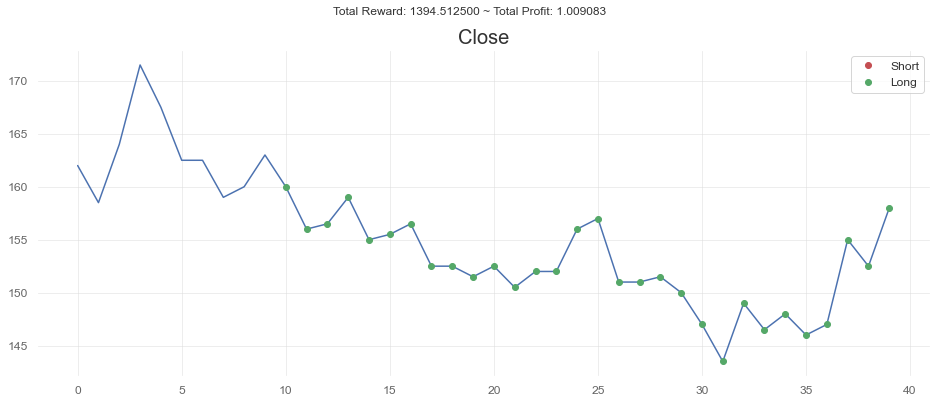

In [14]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


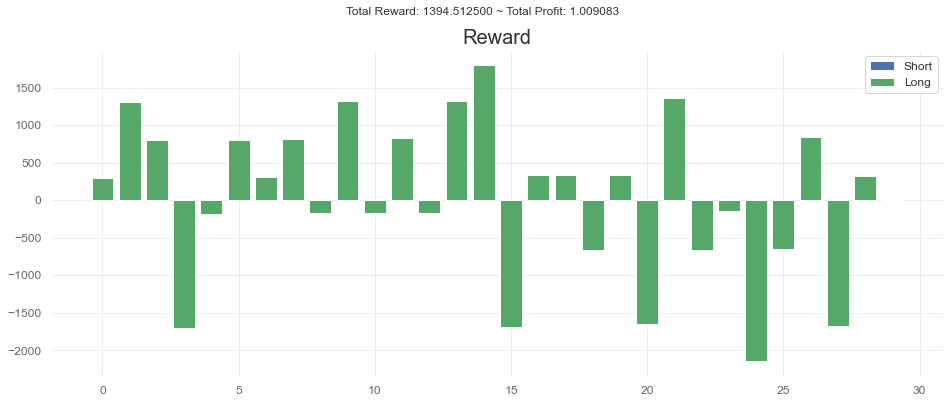

In [15]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


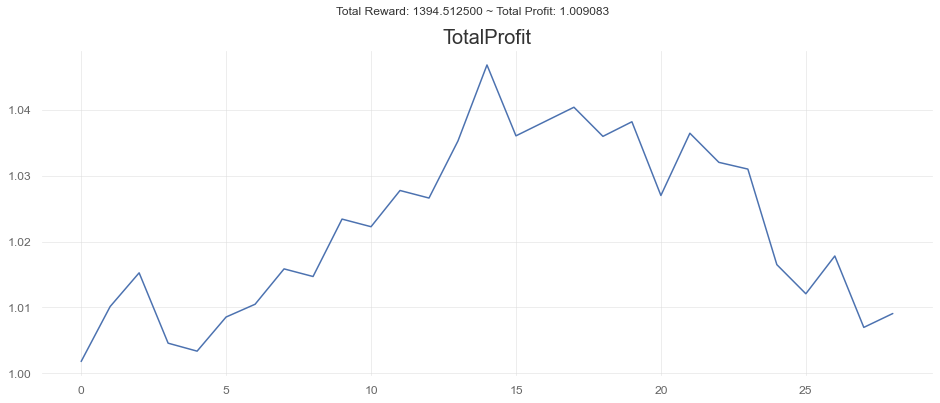

In [16]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)